In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import json


C:\Users\Kari\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Import and Verify Data

In [2]:
climate_df = pd.read_csv("C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\climate_hour.csv", delimiter=",", index_col=None, header=0)


In [3]:
print(climate_df.shape)
print(climate_df.dtypes)
print(climate_df.head())


(70037, 15)
Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
1  01.01.2009 02:00:00    996.62     -8.88    264.54        -9.77    93.2   
2  01.01.2009 03:00:00    996.84     -8.81    264.59        -9.66    93.5   
3  01.01.2009 04:00:00    996.99     -9.05    264.34       -10.02    92.6   
4  01.01.2009 05:00:00    997.46     -9.63    263.72       -10.65    92.2   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.14  

In [4]:
climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [5]:
climate_df.columns = ['date_time', 'atm_pressure', 'temperature', 'pot_temp_K', 'dew_temp_C', 'relative_humidity', 
                      'sat_water_vap_pressure', 'act_water_vap_pressure', 'water_vap_pressure_deficit', 
                      'specific_humidity', 'water_vap_concentration', 'air_density', 'wind_velocity',
                      'max_wind_velocity', 'wind_dir']


In [6]:
print(climate_df.dtypes)
print(climate_df.head())


date_time                     datetime64[ns]
atm_pressure                         float64
temperature                          float64
pot_temp_K                           float64
dew_temp_C                           float64
relative_humidity                    float64
sat_water_vap_pressure               float64
act_water_vap_pressure               float64
water_vap_pressure_deficit           float64
specific_humidity                    float64
water_vap_concentration              float64
air_density                          float64
wind_velocity                        float64
max_wind_velocity                    float64
wind_dir                             float64
dtype: object
            date_time  atm_pressure  temperature  pot_temp_K  dew_temp_C  \
0 2009-01-01 01:00:00        996.50        -8.05      265.38       -8.78   
1 2009-01-01 02:00:00        996.62        -8.88      264.54       -9.77   
2 2009-01-01 03:00:00        996.84        -8.81      264.59       -9.66   
3 2009-

In [7]:
climate_df.isnull().sum().sum()

0

In [8]:
dup_ndx = climate_df.index.duplicated(keep = False)
sum(dup_ndx)

0

Text(0.5,1,'Temperature (C) Over Time')

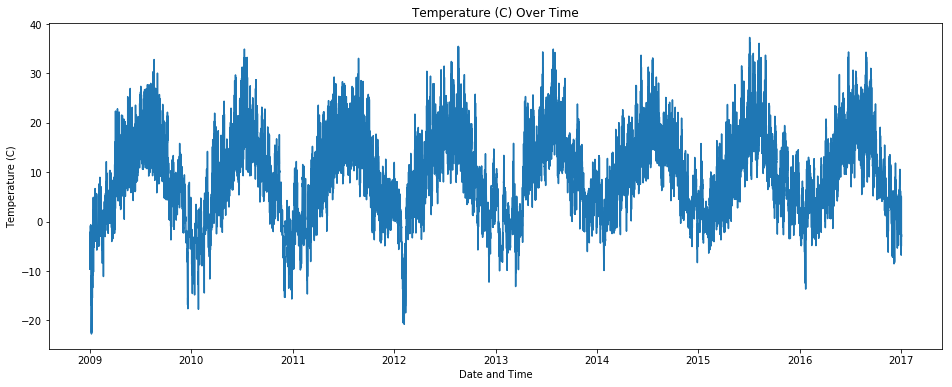

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(climate_df['date_time'], climate_df['temperature'])
plt.xlabel('Date and Time')
plt.ylabel('Temperature (C)')
plt.title('Temperature (C) Over Time')

In [10]:
climate_df.set_index(['date_time'], inplace = True)
print(climate_df.head())

                     atm_pressure  temperature  pot_temp_K  dew_temp_C  \
date_time                                                                
2009-01-01 01:00:00        996.50        -8.05      265.38       -8.78   
2009-01-01 02:00:00        996.62        -8.88      264.54       -9.77   
2009-01-01 03:00:00        996.84        -8.81      264.59       -9.66   
2009-01-01 04:00:00        996.99        -9.05      264.34      -10.02   
2009-01-01 05:00:00        997.46        -9.63      263.72      -10.65   

                     relative_humidity  sat_water_vap_pressure  \
date_time                                                        
2009-01-01 01:00:00               94.4                    3.33   
2009-01-01 02:00:00               93.2                    3.12   
2009-01-01 03:00:00               93.5                    3.13   
2009-01-01 04:00:00               92.6                    3.07   
2009-01-01 05:00:00               92.2                    2.94   

                  

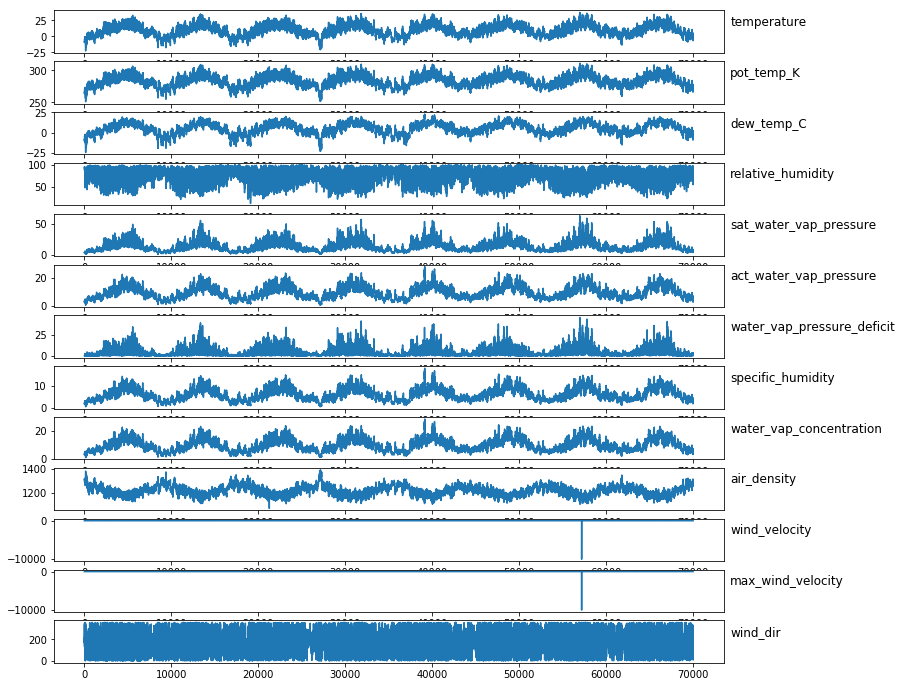

In [11]:
values = climate_df.values
groups = range(1, climate_df.shape[1])

# plot each column
i = 1
plt.figure(figsize=(12, 12))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(climate_df.columns[group], y = 0.5, x = 1.01, loc = 'left')
    i += 1
plt.show()


In [12]:
climate_corr = climate_df.corr(method = "pearson")
print(climate_corr)


                            atm_pressure  temperature  pot_temp_K  dew_temp_C  \
atm_pressure                    1.000000    -0.045327   -0.124718   -0.066707   
temperature                    -0.045327     1.000000    0.996823    0.895986   
pot_temp_K                     -0.124718     0.996823    1.000000    0.895185   
dew_temp_C                     -0.066707     0.895986    0.895185    1.000000   
relative_humidity              -0.018423    -0.571708   -0.566415   -0.156375   
sat_water_vap_pressure         -0.031463     0.951090    0.947264    0.799511   
act_water_vap_pressure         -0.054373     0.867999    0.866530    0.968323   
water_vap_pressure_deficit     -0.003241     0.761453    0.756659    0.435892   
specific_humidity              -0.069758     0.867077    0.866855    0.967578   
water_vap_concentration        -0.069796     0.867501    0.867278    0.968024   
air_density                     0.307737    -0.963371   -0.981327   -0.885434   
wind_velocity               

# Normalize Data

In [13]:
date_time = pd.Series(climate_df.index.values)
date_time.head()


0   2009-01-01 01:00:00
1   2009-01-01 02:00:00
2   2009-01-01 03:00:00
3   2009-01-01 04:00:00
4   2009-01-01 05:00:00
dtype: datetime64[ns]

In [14]:
var_names = list(climate_df.columns)
print(var_names)

['atm_pressure', 'temperature', 'pot_temp_K', 'dew_temp_C', 'relative_humidity', 'sat_water_vap_pressure', 'act_water_vap_pressure', 'water_vap_pressure_deficit', 'specific_humidity', 'water_vap_concentration', 'air_density', 'wind_velocity', 'max_wind_velocity', 'wind_dir']


In [15]:
date_time = pd.Series(climate_df.index.values)
date_time.head()


0   2009-01-01 01:00:00
1   2009-01-01 02:00:00
2   2009-01-01 03:00:00
3   2009-01-01 04:00:00
4   2009-01-01 05:00:00
dtype: datetime64[ns]

In [16]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1)).fit(climate_df)
climate_norm_np = min_max_scaler.transform(climate_df)


In [17]:
climate_norm_df = pd.DataFrame(climate_norm_np, columns = var_names, index = date_time)
climate_norm_df.head()


atm_pressure  temperature  pot_temp_K  dew_temp_C  \
2009-01-01 01:00:00      0.805868     0.245003    0.240722    0.335568   
2009-01-01 02:00:00      0.807108     0.231179    0.226806    0.314830   
2009-01-01 03:00:00      0.809381     0.232345    0.227634    0.317134   
2009-01-01 04:00:00      0.810931     0.228348    0.223492    0.309594   
2009-01-01 05:00:00      0.815787     0.218688    0.213221    0.296397   

                     relative_humidity  sat_water_vap_pressure  \
2009-01-01 01:00:00           0.935588                0.037580   
2009-01-01 02:00:00           0.921785                0.034236   
2009-01-01 03:00:00           0.925236                0.034395   
2009-01-01 04:00:00           0.914884                0.033439   
2009-01-01 05:00:00           0.910283                0.031369   

                     act_water_vap_pressure  water_vap_pressure_deficit  \
2009-01-01 01:00:00                0.085567                    0.004130   
2009-01-01 02:00:00                0.076754                    0.004564   
2009-01-01 03:00:00                0.077855                    0.004347   
2009-01-01 04:00:00                0.074917                    0.004999   
2009-01-01 05:00:00                0.069776                    0.004999   

                     specific_humidity  water_vap_concentration  air_density  \
2009-01-01 01:00:00           0.083190                 0.084416     0.740479   
2009-01-01 02:00:00           0.074584                 0.075758     0.753930   
2009-01-01 03:00:00           0.075731                 0.076840     0.753715   
2009-01-01 04:00:00           0.072863                 0.073593     0.758097   
2009-01-01 05:00:00           0.067699                 0.068543     0.769066   

                     wind_velocity  max_wind_velocity  wind_dir  
2009-01-01 01:00:00       0.998764           0.998034  0.535278  
2009-01-01 02:00:00       0.998768           0.998034  0.528611  
2009-01-01 03:00:00       0.998761           0.998034  0.464444  
2009-01-01 04:00:00       0.998753           0.998009  0.666667  
2009-01-01 05:00:00       0.998783           0.998059  0.436111

In [18]:
print(climate_norm_df.min().min())
print(climate_norm_df.max().max())


0.0
1.0


In [19]:
print(np.shape(climate_norm_np))
print(climate_df.shape)

(70037, 14)
(70037, 14)


# Split Data Into Train and Test Sets

In [20]:
datetime_cutoff = datetime.strptime('2015-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
test_pts = date_time >= datetime_cutoff
test_ndx = np.where(test_pts == True)
train_ndx = np.where(test_pts == False)
train_norm_df = climate_norm_df.iloc[train_ndx]
test_norm_df = climate_norm_df.iloc[test_ndx]


In [21]:
train_norm_df.tail()

atm_pressure  temperature  pot_temp_K  dew_temp_C  \
2014-12-31 19:00:00      0.906085     0.416889    0.399105    0.560536   
2014-12-31 20:00:00      0.906912     0.414724    0.396952    0.559070   
2014-12-31 21:00:00      0.911148     0.411726    0.393472    0.555509   
2014-12-31 22:00:00      0.913524     0.411392    0.392810    0.556137   
2014-12-31 23:00:00      0.915487     0.415390    0.396455    0.561584   

                     relative_humidity  sat_water_vap_pressure  \
2014-12-31 19:00:00           0.974695                0.099045   
2014-12-31 20:00:00           0.979296                0.098089   
2014-12-31 21:00:00           0.980446                0.096656   
2014-12-31 22:00:00           0.983897                0.096497   
2014-12-31 23:00:00           0.986197                0.098408   

                     act_water_vap_pressure  water_vap_pressure_deficit  \
2014-12-31 19:00:00                0.228792                    0.003478   
2014-12-31 20:00:00                0.227323                    0.002825   
2014-12-31 21:00:00                0.224385                    0.002608   
2014-12-31 22:00:00                0.224752                    0.002173   
2014-12-31 23:00:00                0.229526                    0.001956   

                     specific_humidity  water_vap_concentration  air_density  \
2014-12-31 19:00:00           0.220884                 0.222944     0.622300   
2014-12-31 20:00:00           0.219736                 0.221861     0.624383   
2014-12-31 21:00:00           0.216867                 0.218615     0.628642   
2014-12-31 22:00:00           0.216867                 0.218975     0.629807   
2014-12-31 23:00:00           0.221457                 0.223665     0.626988   

                     wind_velocity  max_wind_velocity  wind_dir  
2014-12-31 19:00:00       0.998791           0.998099  0.334167  
2014-12-31 20:00:00       0.998811           0.998139  0.331389  
2014-12-31 21:00:00       0.998810           0.998127  0.403611  
2014-12-31 22:00:00       0.998814           0.998151  0.360000  
2014-12-31 23:00:00       0.998778           0.998057  0.391111

In [22]:
test_norm_df.head()

atm_pressure  temperature  pot_temp_K  dew_temp_C  \
2015-01-01 00:00:00      0.916314     0.413391    0.394301    0.559070   
2015-01-01 01:00:00      0.914971     0.416056    0.397117    0.562631   
2015-01-01 02:00:00      0.918793     0.413058    0.393638    0.558651   
2015-01-01 03:00:00      0.923339     0.408894    0.389165    0.553624   
2015-01-01 04:00:00      0.922513     0.414390    0.394467    0.561165   

                     relative_humidity  sat_water_vap_pressure  \
2015-01-01 00:00:00           0.986197                0.097452   
2015-01-01 01:00:00           0.987348                0.098726   
2015-01-01 02:00:00           0.986197                0.097293   
2015-01-01 03:00:00           0.986197                0.095223   
2015-01-01 04:00:00           0.989648                0.097930   

                     act_water_vap_pressure  water_vap_pressure_deficit  \
2015-01-01 00:00:00                0.227323                    0.001956   
2015-01-01 01:00:00                0.230628                    0.001739   
2015-01-01 02:00:00                0.226956                    0.001739   
2015-01-01 03:00:00                0.222549                    0.001739   
2015-01-01 04:00:00                0.229159                    0.001304   

                     specific_humidity  water_vap_concentration  air_density  \
2015-01-01 00:00:00           0.219736                 0.221501     0.629102   
2015-01-01 01:00:00           0.222605                 0.224747     0.626252   
2015-01-01 02:00:00           0.219162                 0.221140     0.630389   
2015-01-01 03:00:00           0.214573                 0.216811     0.635690   
2015-01-01 04:00:00           0.220884                 0.223304     0.630542   

                     wind_velocity  max_wind_velocity  wind_dir  
2015-01-01 00:00:00       0.998784           0.998063  0.760556  
2015-01-01 01:00:00       0.998786           0.998059  0.330833  
2015-01-01 02:00:00       0.998829           0.998135  0.405278  
2015-01-01 03:00:00       0.998825           0.998143  0.390556  
2015-01-01 04:00:00       0.998786           0.998075  0.239444

# Transform Data in Keras RNN Input Format

In [23]:
def create_RNN_input(in_df, timestep, dropnan, output_var):
    
    var_names = list(in_df.columns.values)
    num_vars = len(var_names)

    x_df_list = []
    x_df_names = []

    # input sequence (t-n, ... t-1)
    for i in range(timestep, 0, -1):
        x_df_list.append(in_df.shift(i))
        x_df_names += [('%s(t-%d)' % (var_names[j], i)) for j in range(len(var_names))]

    # put it all together
    x_df = pd.concat(x_df_list, axis = 1)
    x_df.columns = x_df_names

    # forecast sequence (t, t+1, ... t+n)
    y_df = in_df[output_var].shift(-timestep)

    # drop rows with NaN values
    if dropnan:
        x_df.dropna(inplace = True)
        y_df.dropna(inplace = True)

    out_ndx = list(x_df.index.values)
    y_df.index = out_ndx
    
    return x_df, y_df


In [24]:
train_x_df, train_y_df = create_RNN_input(train_norm_df, 24, True, 'temperature')


In [25]:
print(train_x_df.shape)
print(train_y_df.shape)


(52542, 336)
(52542,)


In [26]:
train_x_df.head(3)

atm_pressure(t-24)  temperature(t-24)  pot_temp_K(t-24)  \
2009-01-02 01:00:00            0.805868           0.245003          0.240722   
2009-01-02 02:00:00            0.807108           0.231179          0.226806   
2009-01-02 03:00:00            0.809381           0.232345          0.227634   

                     dew_temp_C(t-24)  relative_humidity(t-24)  \
2009-01-02 01:00:00          0.335568                 0.935588   
2009-01-02 02:00:00          0.314830                 0.921785   
2009-01-02 03:00:00          0.317134                 0.925236   

                     sat_water_vap_pressure(t-24)  \
2009-01-02 01:00:00                      0.037580   
2009-01-02 02:00:00                      0.034236   
2009-01-02 03:00:00                      0.034395   

                     act_water_vap_pressure(t-24)  \
2009-01-02 01:00:00                      0.085567   
2009-01-02 02:00:00                      0.076754   
2009-01-02 03:00:00                      0.077855   

                     water_vap_pressure_deficit(t-24)  \
2009-01-02 01:00:00                          0.004130   
2009-01-02 02:00:00                          0.004564   
2009-01-02 03:00:00                          0.004347   

                     specific_humidity(t-24)  water_vap_concentration(t-24)  \
2009-01-02 01:00:00                 0.083190                       0.084416   
2009-01-02 02:00:00                 0.074584                       0.075758   
2009-01-02 03:00:00                 0.075731                       0.076840   

                         ...        relative_humidity(t-1)  \
2009-01-02 01:00:00      ...                      0.921785   
2009-01-02 02:00:00      ...                      0.935588   
2009-01-02 03:00:00      ...                      0.936738   

                     sat_water_vap_pressure(t-1)  act_water_vap_pressure(t-1)  \
2009-01-02 01:00:00                     0.053981                     0.119354   
2009-01-02 02:00:00                     0.054459                     0.122659   
2009-01-02 03:00:00                     0.055255                     0.124495   

                     water_vap_pressure_deficit(t-1)  specific_humidity(t-1)  \
2009-01-02 01:00:00                         0.006520                0.115892   
2009-01-02 02:00:00                         0.005434                0.118761   
2009-01-02 03:00:00                         0.005216                0.121056   

                     water_vap_concentration(t-1)  air_density(t-1)  \
2009-01-02 01:00:00                      0.117244          0.699023   
2009-01-02 02:00:00                      0.120491          0.696388   
2009-01-02 03:00:00                      0.122294          0.692558   

                     wind_velocity(t-1)  max_wind_velocity(t-1)  wind_dir(t-1)  
2009-01-02 01:00:00            0.998784                0.998059       0.430556  
2009-01-02 02:00:00            0.998771                0.998071       0.411389  
2009-01-02 03:00:00            0.998792                0.998059       0.582778  

[3 rows x 336 columns]

In [27]:
train_y_df.head(3)

2009-01-02 01:00:00    0.305130
2009-01-02 02:00:00    0.307628
2009-01-02 03:00:00    0.304963
Name: temperature, dtype: float64

In [28]:
train_norm_df.iloc[0:3]

atm_pressure  temperature  pot_temp_K  dew_temp_C  \
2009-01-01 01:00:00      0.805868     0.245003    0.240722    0.335568   
2009-01-01 02:00:00      0.807108     0.231179    0.226806    0.314830   
2009-01-01 03:00:00      0.809381     0.232345    0.227634    0.317134   

                     relative_humidity  sat_water_vap_pressure  \
2009-01-01 01:00:00           0.935588                0.037580   
2009-01-01 02:00:00           0.921785                0.034236   
2009-01-01 03:00:00           0.925236                0.034395   

                     act_water_vap_pressure  water_vap_pressure_deficit  \
2009-01-01 01:00:00                0.085567                    0.004130   
2009-01-01 02:00:00                0.076754                    0.004564   
2009-01-01 03:00:00                0.077855                    0.004347   

                     specific_humidity  water_vap_concentration  air_density  \
2009-01-01 01:00:00           0.083190                 0.084416     0.740479   
2009-01-01 02:00:00           0.074584                 0.075758     0.753930   
2009-01-01 03:00:00           0.075731                 0.076840     0.753715   

                     wind_velocity  max_wind_velocity  wind_dir  
2009-01-01 01:00:00       0.998764           0.998034  0.535278  
2009-01-01 02:00:00       0.998768           0.998034  0.528611  
2009-01-01 03:00:00       0.998761           0.998034  0.464444

In [29]:
train_norm_df.iloc[23:26]

atm_pressure  temperature  pot_temp_K  dew_temp_C  \
2009-01-02 00:00:00      0.837793     0.303464    0.294897    0.405111   
2009-01-02 01:00:00      0.835210     0.305130    0.296885    0.410767   
2009-01-02 02:00:00      0.830974     0.307628    0.299867    0.413909   

                     relative_humidity  sat_water_vap_pressure  \
2009-01-02 00:00:00           0.921785                0.053981   
2009-01-02 01:00:00           0.935588                0.054459   
2009-01-02 02:00:00           0.936738                0.055255   

                     act_water_vap_pressure  water_vap_pressure_deficit  \
2009-01-02 00:00:00                0.119354                    0.006520   
2009-01-02 01:00:00                0.122659                    0.005434   
2009-01-02 02:00:00                0.124495                    0.005216   

                     specific_humidity  water_vap_concentration  air_density  \
2009-01-02 00:00:00           0.115892                 0.117244     0.699023   
2009-01-02 01:00:00           0.118761                 0.120491     0.696388   
2009-01-02 02:00:00           0.121056                 0.122294     0.692558   

                     wind_velocity  max_wind_velocity  wind_dir  
2009-01-02 00:00:00       0.998784           0.998059  0.430556  
2009-01-02 01:00:00       0.998771           0.998071  0.411389  
2009-01-02 02:00:00       0.998792           0.998059  0.582778

In [30]:
train_df_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\train_norm_df.csv'
train_norm_df.to_csv(train_df_file, header  = True, index  = False)


In [31]:
train_x_df_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\train_x_df.csv'
train_x_df.to_csv(train_x_df_file, header  = True, index  = False)

train_y_df_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\train_y_df.csv'
train_y_df.to_csv(train_y_df_file, header  = True, index  = False)


In [32]:
test_x_df, test_y_df = create_RNN_input(test_norm_df, 24, True, 'temperature')


In [33]:
test_df_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\test_norm_df.csv'
test_norm_df.to_csv(test_df_file, header  = True, index  = False)


In [34]:
test_x_df_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\test_x_df.csv'
test_x_df.to_csv(test_x_df_file, header  = True, index  = False)

test_y_df_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\test_y_df.csv'
test_y_df.to_csv(test_y_df_file, header  = True, index  = False)


In [35]:
train_x_np = np.array(train_x_df)
train_x_np = train_x_np.reshape((train_x_df.shape[0], 24, train_norm_df.shape[1]))
print(train_x_df.shape)
print(train_x_np.shape)


(52542, 336)
(52542, 24, 14)


In [36]:
test_x_np = np.array(test_x_df)
test_x_np = test_x_np.reshape((test_x_df.shape[0], 24, test_norm_df.shape[1]))
print(test_x_df.shape)
print(test_x_np.shape)


(17447, 336)
(17447, 24, 14)


In [37]:
train_y_np = np.array(train_y_df)
test_y_np = np.array(test_y_df)


# Create Kaggle Test Set and Transform to RNN Input

In [38]:
datetime_pred_cutoff = datetime.strptime('2014-12-31 00:00:00', '%Y-%m-%d %H:%M:%S')
pred_test_pts = date_time >= datetime_pred_cutoff
pred_test_ndx = np.where(pred_test_pts == True)
pred_test_norm_df = climate_norm_df.iloc[pred_test_ndx]

In [39]:
pred_test_x_df, pred_test_y_df = create_RNN_input(pred_test_norm_df, 24, True, 'temperature')


In [40]:
pred_test_df_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\pred_test_norm_df.csv'
pred_test_norm_df.to_csv(pred_test_df_file, header  = True, index  = False)


In [41]:
pred_test_x_df_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\pred_test_x_df.csv'
pred_test_x_df.to_csv(pred_test_x_df_file, header  = True, index  = False)

pred_test_y_df_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\pred_test_y_df.csv'
pred_test_y_df.to_csv(pred_test_y_df_file, header  = True, index  = False)


In [42]:
pred_test_x_np = np.array(pred_test_x_df)
pred_test_x_np = pred_test_x_np.reshape((pred_test_x_df.shape[0], 24, pred_test_norm_df.shape[1]))
print(pred_test_x_df.shape)
print(pred_test_x_np.shape)


(17471, 336)
(17471, 24, 14)


In [43]:
pred_test_y_np = np.array(pred_test_y_df)


# Common Model Evaluation and Prediction Functions

In [44]:
def plot_model_losses(model_hist_dict, model_desc):
    model_loss = model_hist_dict['loss']
    model_val_loss = model_hist_dict['val_loss']

    model_epochs = range(1, len(model_loss) + 1)
    
    # "bo" is for "blue dot"
    plt.plot(model_epochs, model_loss, 'bo', label = 'Training Loss')
    
    # b is for "solid blue line"
    plot_title = model_desc + ' Training and Validation Loss'
    plt.plot(model_epochs, model_val_loss, 'b', label = 'Validation Loss')
    plt.title(plot_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()   
    

In [45]:
def evaluate_model(model, model_hist_dict, x_test_np, y_test_np, pred_x_test_np, pred_y_test_np, model_batch, 
                   model_num):
    
    score = model.evaluate(x_test_np, y_test_np, batch_size = model_batch)
    print('Model %d Test Loss Score: ' % model_num, score)
    
    plot_model_losses(model_hist_dict, 'Model %d' % model_num)
    
    pred_score = model.evaluate(pred_x_test_np, pred_y_test_np, batch_size = model_batch)
    print('Model %d Kaggle Test Loss Score: ' % model_num, pred_score)
    
    plot_model_losses(model_hist_dict, 'Model %d Kaggle' % model_num)
    
    return score, pred_score


In [46]:
def create_model_predictions(model, x_test_np, norm_test_df, y_test_np):
    
    model_predictions = model.predict(x_test_np)
    
    num_test_pts = norm_test_df.shape[0]
    test_x_norm = norm_test_df.iloc[24:(num_test_pts + 1), :]
    date_time_x = pd.Series(test_x_norm.index.values)

    # invert scaling for forecast
    inv_x_y_norm = test_x_norm[:]
    inv_x_y_norm['temperature'] = model_predictions
    inv_x_y = min_max_scaler.inverse_transform(inv_x_y_norm)
    inv_x_y_df = pd.DataFrame(inv_x_y, columns = var_names, index = date_time_x)
    inv_yhat = inv_x_y_df['temperature']

    # invert scaling for actual
    inv_x_y_test_norm = test_x_norm[:]
    inv_x_y_test_norm['temperature'] = y_test_np
    inv_x_y_test = min_max_scaler.inverse_transform(inv_x_y_test_norm)
    inv_x_y_test_df = pd.DataFrame(inv_x_y_test, columns = var_names, index = date_time_x)
    inv_y = inv_x_y_test_df['temperature']

    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = mean_absolute_error(inv_y, inv_yhat)

    return inv_yhat, inv_y, date_time_x, rmse, mae 
                             

In [47]:
def plot_predict_data(date_time_x, inv_y, inv_yhat, model_desc):
    
    plt.figure(figsize=(16, 6))
    plt.plot(date_time_x, inv_y, 'r', label = 'Inverse Temperature')
    
    plot_title = model_desc + ' Temperature Outputs'
    plt.plot(date_time_x, inv_yhat, 'b', label = 'Inverse Predicted Temperature')
    plt.title(plot_title)
    plt.xlabel('Time')
    plt.ylabel('Temperature (C)')
    plt.legend()

    plt.show()

In [48]:
def create_pred_output(date_time_x, inv_yhat):

    date_time_list = []
    for i in range(len(date_time_x)):
        date_time_list.append(date_time_x.iloc[i].strftime('%d.%m.%Y_%H:%M:%S'))

    pred_out_df = pd.DataFrame(date_time_list, columns = ['date_time'])
    pred_out_df['temperature'] = inv_yhat.values
    
    return pred_out_df
    

In [49]:
def create_and_save_pred_data(model, x_test_np, norm_test_df, y_test_np, pred_x_test_np, pred_norm_test_df, 
                              pred_y_test_np, model_num):
     
    inv_yhat, inv_y, date_time_x, rmse, mae = create_model_predictions(model, x_test_np, norm_test_df, y_test_np)
    print('Model %d Test RMSE: %.6f' % (model_num, rmse))
    print('Model %d Test MAE: %.6f' % (model_num, mae))
    print('\n')
    
    plot_predict_data(date_time_x, inv_y, inv_yhat, 'Model %d' % model_num)
    pred_out_df = create_pred_output(date_time_x, inv_yhat)
    
    pred_inv_yhat, pred_inv_y, pred_date_time_x, pred_rmse, pred_mae = create_model_predictions(model,  
            pred_x_test_np, pred_norm_test_df, pred_y_test_np)
    
    print('Model %d Kaggle Prediction Test RMSE: %.6f' % (model_num, pred_rmse))
    print('Model %d Kaggle Prediction Test MAE: %.6f' % (model_num, pred_mae))   
    
    plot_predict_data(pred_date_time_x, pred_inv_y, pred_inv_yhat, 'Model %d Kaggle Prediction' % model_num)
    kaggle_pred_out_df = create_pred_output(pred_date_time_x, pred_inv_yhat)
    kaggle_act_out_df = create_pred_output(pred_date_time_x, pred_inv_y)
    
    out_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\Model_' + \
        str(model_num) + '_Predictions.csv'
    kaggle_pred_out_df.to_csv(out_file, header  = True, index  = False)
    
    act_out_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\Model_' + \
        str(model_num) + '_Actual.csv'
    kaggle_act_out_df.to_csv(act_out_file, header  = True, index  = False)
    
    return rmse, mae, pred_rmse, pred_mae
    

In [50]:
model_nums = []
scores = []
pred_scores = []
rmse_vals = []
pred_rmse_vals = []
mae_vals = []
pred_mae_vals = []

# Model 1 - 1 LSTM Layer With 50 Nodes, 20 Epochs, Batch Size 10

In [51]:
model1 = Sequential()
model1.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model1.add(Dense(1))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [52]:
model1.compile(loss = 'mae', optimizer = 'adam')


In [53]:
batch_model1 = 10
model1_history = model1.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model1, 
                          validation_data = (test_x_np, test_y_np))


Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 63s 1ms/step - loss: 0.0137 - val_loss: 0.0109
Epoch 2/20
52542/52542 [==============================] - 63s 1ms/step - loss: 0.0098 - val_loss: 0.0083
Epoch 3/20
52542/52542 [==============================] - 65s 1ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 4/20
52542/52542 [==============================] - 66s 1ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 5/20
52542/52542 [==============================] - 66s 1ms/step - loss: 0.0090 - val_loss: 0.0107
Epoch 6/20
52542/52542 [==============================] - 66s 1ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 7/20
52542/52542 [==============================] - 67s 1ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 8/20
52542/52542 [==============================] - 65s 1ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 9/20
52542/52542 [==============================] - 65s 1ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch

In [54]:
model1.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model1.h5')

model1_hist_dict = model1_history.history
model1_hist_json = json.dumps(model1_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model1_hist.json', 'w')
f.write(model1_hist_json)
f.close()


In [55]:
#model1 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model1.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model1_hist.json', 'r')
#model1_hist_json = f.read()
#f.close()
#model1_hist_dict = json.loads(model1_hist_json)

#print(model1.summary())
#print(model1_hist_dict)


17447/17447 [==============================] - ETA:  - 4s 201us/step
Model 1 Test Loss Score:  0.008438976671563353


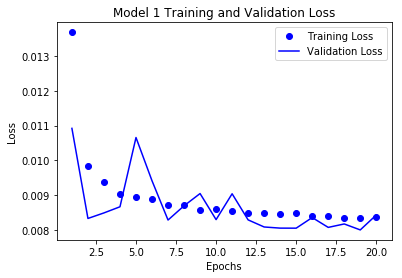

17471/17471 [==============================] - 4s 216us/step
Model 1 Kaggle Test Loss Score:  0.008438175601354214


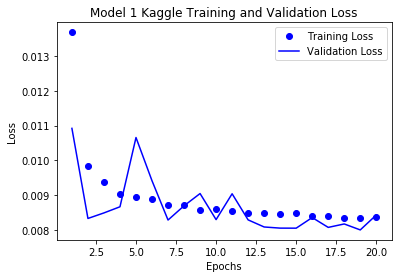

In [56]:
score1, pred_score1 = evaluate_model(model1, model1_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model1, 1)

Model 1 Test RMSE: 0.727960
Model 1 Test MAE: 0.506676




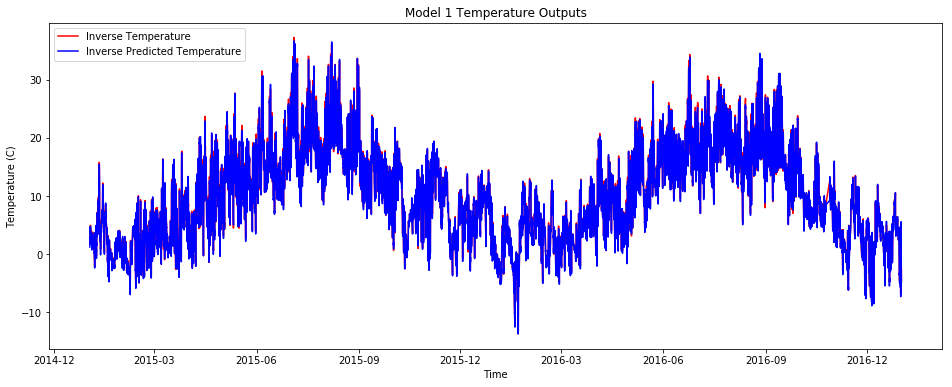

Model 1 Kaggle Prediction Test RMSE: 0.727830
Model 1 Kaggle Prediction Test MAE: 0.506628


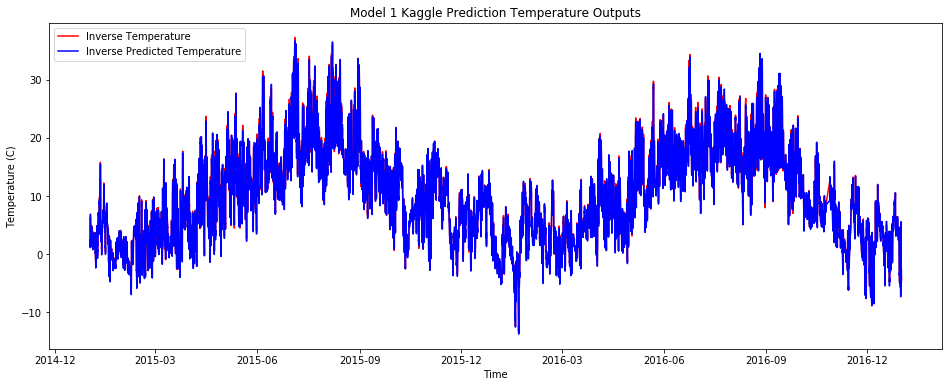

In [57]:
rmse1, mae1, pred_rmse1, pred_mae1 = create_and_save_pred_data(model1, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 1)

In [58]:
model_nums.append(1)
scores.append(score1)
pred_scores.append(pred_score1)
rmse_vals.append(rmse1)
pred_rmse_vals.append(pred_rmse1)
mae_vals.append(mae1)
pred_mae_vals.append(pred_mae1)


# Model 2 - 1 LSTM Layer With 150 Nodes, 20 Epochs, Batch Size 10

In [59]:
model2 = Sequential()
model2.add(LSTM(150, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model2.add(Dense(1))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               99000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 99,151
Trainable params: 99,151
Non-trainable params: 0
_________________________________________________________________


In [60]:
model2.compile(loss = 'mae', optimizer = 'adam')

In [61]:
batch_model2 = 10
model2_history = model2.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model2, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 84s 2ms/step - loss: 0.0129 - val_loss: 0.0085
Epoch 2/20
52542/52542 [==============================] - 84s 2ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 3/20
52542/52542 [==============================] - 84s 2ms/step - loss: 0.0093 - val_loss: 0.0123
Epoch 4/20
52542/52542 [==============================] - 84s 2ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 5/20
52542/52542 [==============================] - 84s 2ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 6/20
52542/52542 [==============================] - 85s 2ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 7/20
52542/52542 [==============================] - 84s 2ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 8/20
52542/52542 [==============================] - 85s 2ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 9/20
52542/52542 [==============================] - 85s 2ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch

In [62]:
model2.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model2.h5')

model2_hist_dict = model2_history.history
model2_hist_json = json.dumps(model2_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model2_hist.json', 'w')
f.write(model2_hist_json)
f.close()


In [63]:
#model2 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model2.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model2_hist.json', 'r')
#model2_hist_json = f.read()
#f.close()
#model2_hist_dict = json.loads(model2_hist_json)

#print(model2.summary())
#print(model2_hist_dict)


17447/17447 [==============================] - 6s 333us/step
Model 2 Test Loss Score:  0.00820291326510179


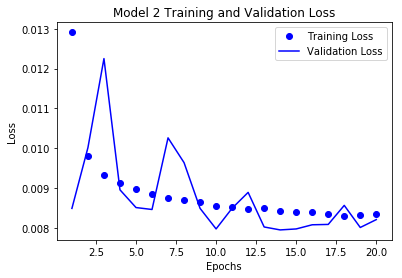

17471/17471 [==============================] - 6s 320us/step
Model 2 Kaggle Test Loss Score:  0.008202303351072023


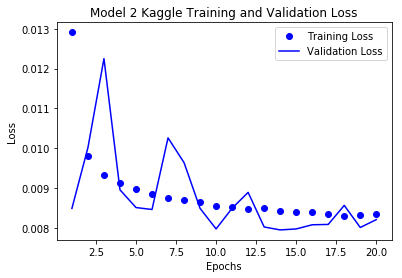

In [64]:
score2, pred_score2 = evaluate_model(model2, model2_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model2, 2)

Model 2 Test RMSE: 0.716376
Model 2 Test MAE: 0.492503




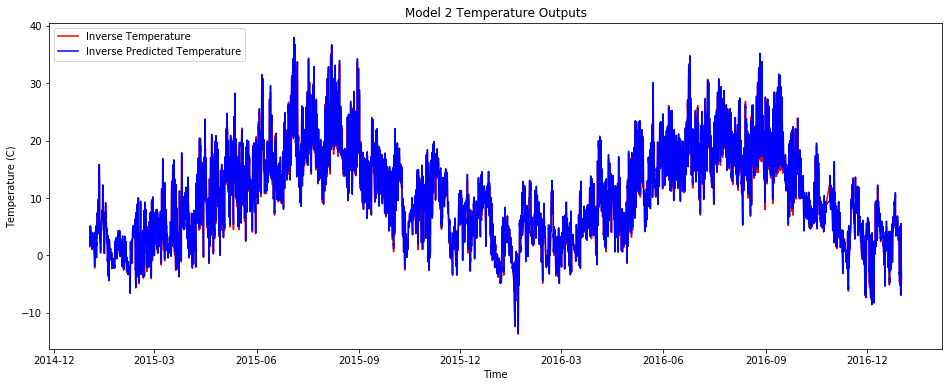

Model 2 Kaggle Prediction Test RMSE: 0.716250
Model 2 Kaggle Prediction Test MAE: 0.492466


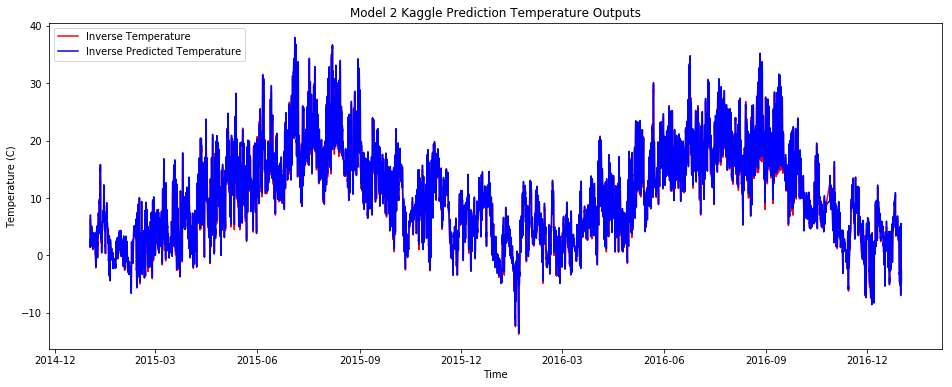

In [65]:
rmse2, mae2, pred_rmse2, pred_mae2 = create_and_save_pred_data(model2, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 2)

In [66]:
model_nums.append(2)
scores.append(score2)
pred_scores.append(pred_score2)
rmse_vals.append(rmse2)
pred_rmse_vals.append(pred_rmse2)
mae_vals.append(mae2)
pred_mae_vals.append(pred_mae2)


# Model 3 - 2 LSTM Layer With 50 Nodes Each, 20 Epochs, Batch Size 10

In [67]:
model3 = Sequential()
model3.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences=True))
model3.add(LSTM(50))
model3.add(Dense(1))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24, 50)            13000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 33,251
Trainable params: 33,251
Non-trainable params: 0
_________________________________________________________________


In [68]:
model3.compile(loss = 'mae', optimizer = 'adam')

In [69]:
batch_model3 = 10
model3_history = model3.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model3, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 114s 2ms/step - loss: 0.0132 - val_loss: 0.0103
Epoch 2/20
52542/52542 [==============================] - 112s 2ms/step - loss: 0.0100 - val_loss: 0.0088
Epoch 3/20
52542/52542 [==============================] - 114s 2ms/step - loss: 0.0096 - val_loss: 0.0087
Epoch 4/20
52542/52542 [==============================] - 115s 2ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 5/20
52542/52542 [==============================] - 115s 2ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 6/20
52542/52542 [==============================] - 114s 2ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 7/20
52542/52542 [==============================] - 114s 2ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 8/20
52542/52542 [==============================] - 114s 2ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 9/20
52542/52542 [==============================] - 114s 2ms/step - loss: 0.0087 - val_loss: 0.0

In [70]:
model3.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model3.h5')

model3_hist_dict = model3_history.history
model3_hist_json = json.dumps(model3_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model3_hist.json', 'w')
f.write(model3_hist_json)
f.close()


In [71]:
#model3 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model3.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model3_hist.json', 'r')
#model3_hist_json = f.read()
#f.close()
#model3_hist_dict = json.loads(model3_hist_json)

#print(model3.summary())
#print(model3_hist_dict)


17447/17447 [==============================] - 7s 385us/step
Model 3 Test Loss Score:  0.007939631885254766


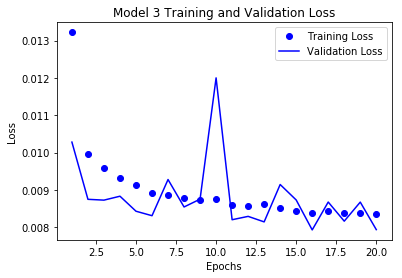

17471/17471 [==============================] - 7s 383us/step
Model 3 Kaggle Test Loss Score:  0.007939323775151375


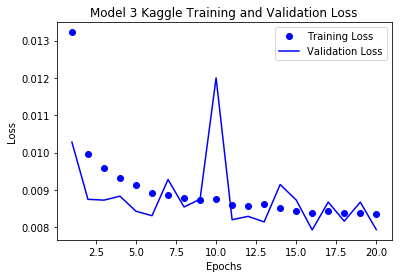

In [72]:
score3, pred_score3 = evaluate_model(model3, model3_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model3, 3)

Model 3 Test RMSE: 0.702191
Model 3 Test MAE: 0.476696




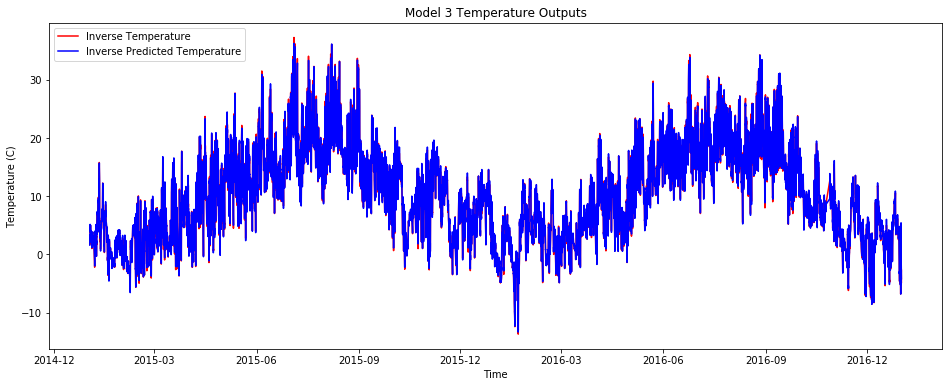

Model 3 Kaggle Prediction Test RMSE: 0.702099
Model 3 Kaggle Prediction Test MAE: 0.476677


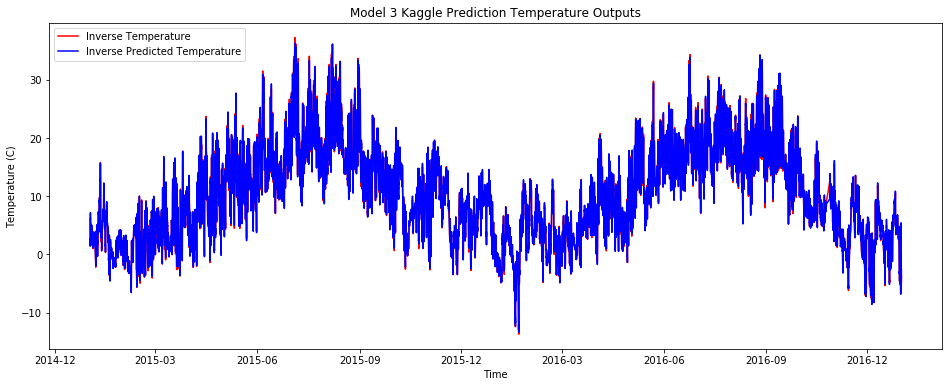

In [73]:
rmse3, mae3, pred_rmse3, pred_mae3 = create_and_save_pred_data(model3, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 3)

In [74]:
model_nums.append(3)
scores.append(score3)
pred_scores.append(pred_score3)
rmse_vals.append(rmse3)
pred_rmse_vals.append(pred_rmse3)
mae_vals.append(mae3)
pred_mae_vals.append(pred_mae3)


# Model 4 - 1 LSTM Layer With 10 Nodes, 20 Epochs, Batch Size 10

In [75]:
model4 = Sequential()
model4.add(LSTM(10, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model4.add(Dense(1))

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                1000      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 1,011
Trainable params: 1,011
Non-trainable params: 0
_________________________________________________________________


In [76]:
model4.compile(loss = 'mae', optimizer = 'adam')

In [77]:
batch_model4 = 10
model4_history = model4.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model4, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0152 - val_loss: 0.0088
Epoch 2/20
52542/52542 [==============================] - 67s 1ms/step - loss: 0.0096 - val_loss: 0.0130
Epoch 3/20
52542/52542 [==============================] - 67s 1ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 4/20
52542/52542 [==============================] - 67s 1ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 5/20
52542/52542 [==============================] - 67s 1ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 6/20
52542/52542 [==============================] - 68s 1ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 7/20
52542/52542 [==============================] - 68s 1ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/20
52542/52542 [==============================] - 68s 1ms/step - loss: 0.0088 - val_loss: 0.0092
Epoch 9/20
52542/52542 [==============================] - 68s 1ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch

In [78]:
model4.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model4.h5')

model4_hist_dict = model4_history.history
model4_hist_json = json.dumps(model4_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model4_hist.json', 'w')
f.write(model4_hist_json)
f.close()


In [79]:
#model4 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model4.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model4_hist.json', 'r')
#model4_hist_json = f.read()
#f.close()
#model4_hist_dict = json.loads(model4_hist_json)

#print(model4.summary())
#print(model4_hist_dict)


17447/17447 [==============================] - 3s 191us/step
Model 4 Test Loss Score:  0.009310623775541376


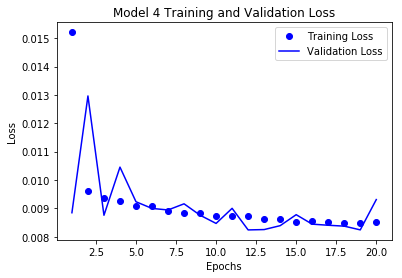

17471/17471 [==============================] - 3s 191us/step
Model 4 Kaggle Test Loss Score:  0.009308914158377177


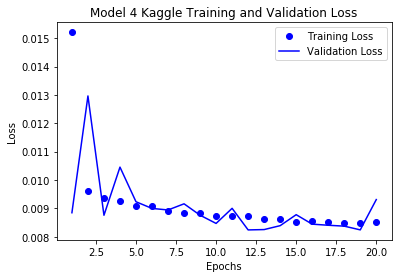

In [80]:
score4, pred_score4 = evaluate_model(model4, model4_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model4, 4)

Model 4 Test RMSE: 0.776805
Model 4 Test MAE: 0.559010




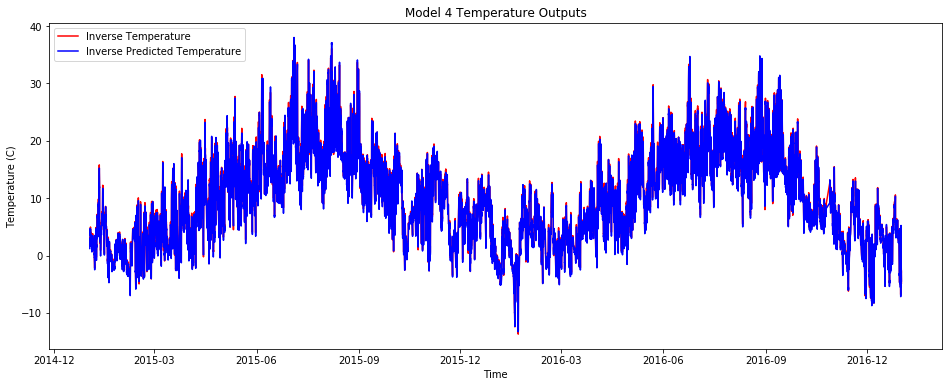

Model 4 Kaggle Prediction Test RMSE: 0.776631
Model 4 Kaggle Prediction Test MAE: 0.558907


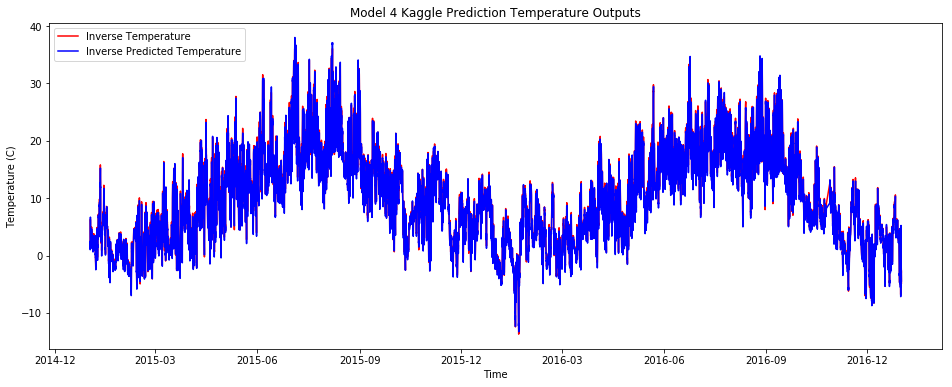

In [81]:
rmse4, mae4, pred_rmse4, pred_mae4 = create_and_save_pred_data(model4, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 4)

In [82]:
model_nums.append(4)
scores.append(score4)
pred_scores.append(pred_score4)
rmse_vals.append(rmse4)
pred_rmse_vals.append(pred_rmse4)
mae_vals.append(mae4)
pred_mae_vals.append(pred_mae4)

# Model 5 - 2 LSTM Layer With 20 Nodes Each, 20 Epochs, Batch Size 10

In [83]:
model5 = Sequential()
model5.add(LSTM(20, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences=True))
model5.add(LSTM(20))
model5.add(Dense(1))

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 24, 20)            2800      
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 6,101
Trainable params: 6,101
Non-trainable params: 0
_________________________________________________________________


In [84]:
model5.compile(loss = 'mae', optimizer = 'adam')

In [85]:
batch_model5 = 10
model5_history = model5.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model5, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 112s 2ms/step - loss: 0.0149 - val_loss: 0.0090
Epoch 2/20
52542/52542 [==============================] - 112s 2ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 3/20
52542/52542 [==============================] - 111s 2ms/step - loss: 0.0095 - val_loss: 0.0085
Epoch 4/20
52542/52542 [==============================] - 112s 2ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 5/20
52542/52542 [==============================] - 110s 2ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 6/20
52542/52542 [==============================] - 110s 2ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 7/20
52542/52542 [==============================] - 111s 2ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 8/20
52542/52542 [==============================] - 110s 2ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 9/20
52542/52542 [==============================] - 111s 2ms/step - loss: 0.0088 - val_loss: 0.0

In [86]:
model5.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model5.h5')

model5_hist_dict = model5_history.history
model5_hist_json = json.dumps(model5_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model5_hist.json', 'w')
f.write(model5_hist_json)
f.close()

In [87]:
#model5 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model5.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model5_hist.json', 'r')
#model5_hist_json = f.read()
#f.close()
#model5_hist_dict = json.loads(model5_hist_json)

#print(model5.summary())
#print(model5_hist_dict)


17447/17447 [==============================] - 6s 370us/step
Model 5 Test Loss Score:  0.008093469262109442


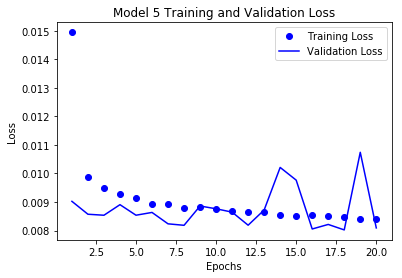

17471/17471 [==============================] - 7s 377us/step
Model 5 Kaggle Test Loss Score:  0.008092802731185076


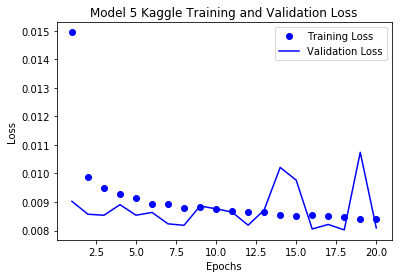

In [88]:
score5, pred_score5 = evaluate_model(model5, model5_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model5, 5)

Model 5 Test RMSE: 0.708208
Model 5 Test MAE: 0.485932




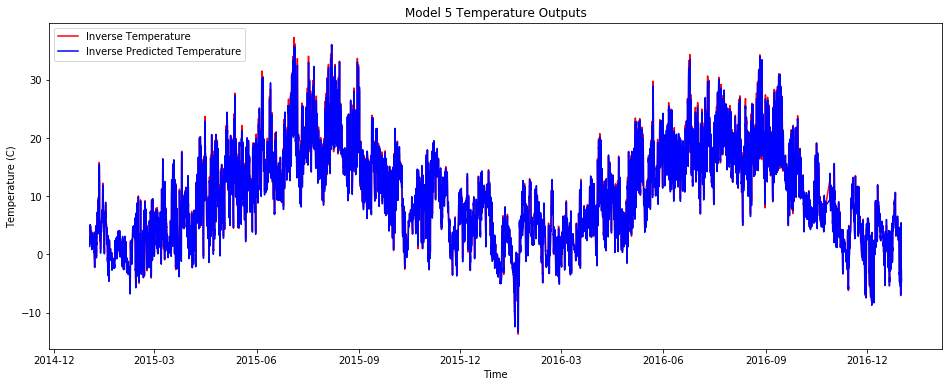

Model 5 Kaggle Prediction Test RMSE: 0.708068
Model 5 Kaggle Prediction Test MAE: 0.485892


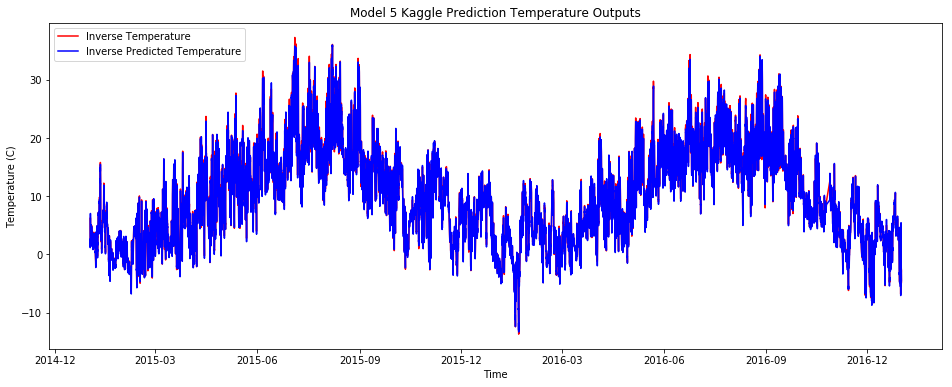

In [89]:
rmse5, mae5, pred_rmse5, pred_mae5 = create_and_save_pred_data(model5, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 5)

In [90]:
model_nums.append(5)
scores.append(score5)
pred_scores.append(pred_score5)
rmse_vals.append(rmse5)
pred_rmse_vals.append(pred_rmse5)
mae_vals.append(mae5)
pred_mae_vals.append(pred_mae5)

# Model 6 - 1 LSTM Layer With 50 Nodes, 1 Additional Dense Layer With 50 Nodes, 20 Epochs, Batch Size 10

In [91]:
model6 = Sequential()
model6.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model6.add(Dense(50))
model6.add(Dense(1))

model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 15,601
Trainable params: 15,601
Non-trainable params: 0
_________________________________________________________________


In [92]:
model6.compile(loss = 'mae', optimizer = 'adam')

In [93]:
batch_model6 = 10
model6_history = model6.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model6, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 2/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0102 - val_loss: 0.0140
Epoch 3/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0096 - val_loss: 0.0089
Epoch 4/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 5/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 6/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 7/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 9/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0089 - val_loss: 0.0112
Epoch

In [94]:
model6.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model6.h5')

model6_hist_dict = model6_history.history
model6_hist_json = json.dumps(model6_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model6_hist.json', 'w')
f.write(model6_hist_json)
f.close()

In [95]:
#model6 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model6.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model6_hist.json', 'r')
#model6_hist_json = f.read()
#f.close()
#model6_hist_dict = json.loads(model6_hist_json)

#print(model6.summary())
#print(model6_hist_dict)


17447/17447 [==============================] - 4s 216us/step
Model 6 Test Loss Score:  0.0080902893080328


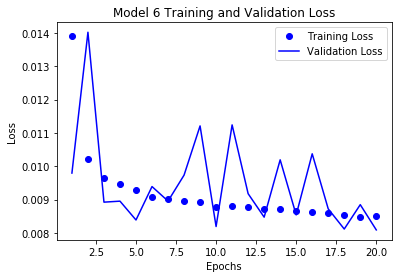

17471/17471 [==============================] - 4s 220us/step
Model 6 Kaggle Test Loss Score:  0.008089530787350583


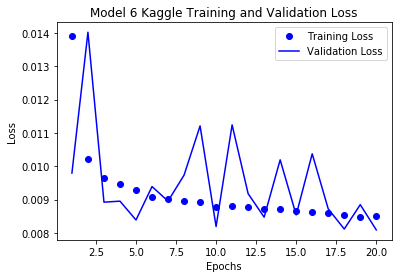

In [96]:
score6, pred_score6 = evaluate_model(model6, model6_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model6, 6)

Model 6 Test RMSE: 0.706730
Model 6 Test MAE: 0.485741




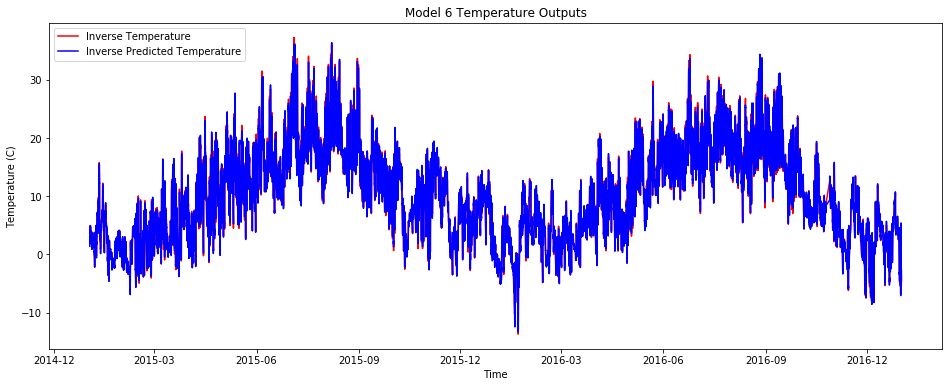

Model 6 Kaggle Prediction Test RMSE: 0.706594
Model 6 Kaggle Prediction Test MAE: 0.485695


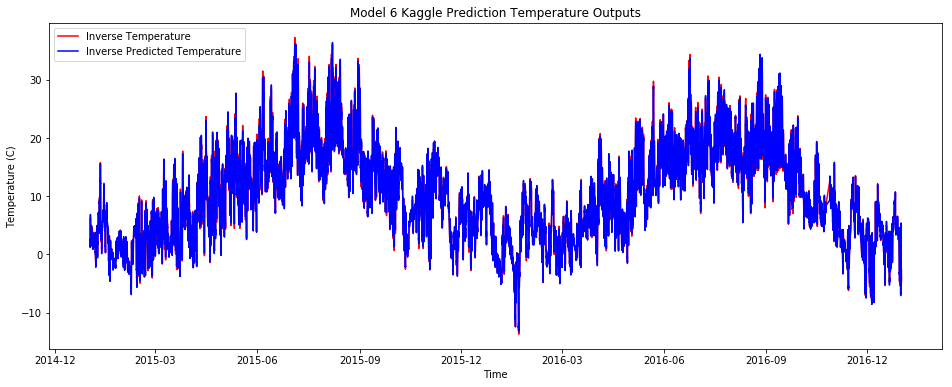

In [97]:
rmse6, mae6, pred_rmse6, pred_mae6 = create_and_save_pred_data(model6, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 6)

In [98]:
model_nums.append(6)
scores.append(score6)
pred_scores.append(pred_score6)
rmse_vals.append(rmse6)
pred_rmse_vals.append(pred_rmse6)
mae_vals.append(mae6)
pred_mae_vals.append(pred_mae6)

# Model 7 - 1 LSTM Layer With 50 Nodes, 1 Dense Layer With 50 Nodes, 30% Dense Layer Dropout, 20 Epochs, Batch Size 10

In [99]:
model7 = Sequential()
model7.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model7.add(Dense(50))
model7.add(Dropout(0.3))
model7.add(Dense(1))

model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 15,601
Trainable params: 15,601
Non-trainable params: 0
_________________________________________________________________


In [100]:
model7.compile(loss = 'mae', optimizer = 'adam')

In [101]:
batch_model7 = 10
model7_history = model7.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model7, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0284 - val_loss: 0.0125
Epoch 2/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0149 - val_loss: 0.0114
Epoch 3/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0146 - val_loss: 0.0100
Epoch 4/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0142 - val_loss: 0.0086
Epoch 5/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0141 - val_loss: 0.0091
Epoch 6/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0140 - val_loss: 0.0108
Epoch 7/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0139 - val_loss: 0.0085
Epoch 8/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0139 - val_loss: 0.0085
Epoch 9/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0138 - val_loss: 0.0102
Epoch

In [102]:
model7.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model7.h5')

model7_hist_dict = model7_history.history
model7_hist_json = json.dumps(model7_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model7_hist.json', 'w')
f.write(model7_hist_json)
f.close()

In [103]:
#model7 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model7.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model7_hist.json', 'r')
#model7_hist_json = f.read()
#f.close()
#model7_hist_dict = json.loads(model7_hist_json)

#print(model7.summary())
#print(model7_hist_dict)


17447/17447 [==============================] - 4s 218us/step
Model 7 Test Loss Score:  0.008967605382397825


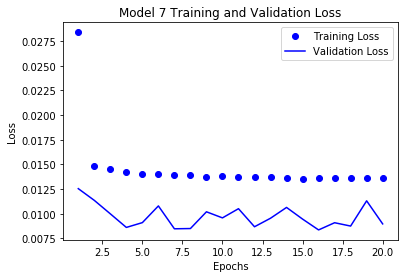

17471/17471 [==============================] - 4s 225us/step
Model 7 Kaggle Test Loss Score:  0.00896681019007839


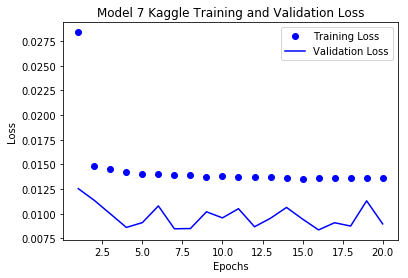

In [104]:
score7, pred_score7 = evaluate_model(model7, model7_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model7, 7)

Model 7 Test RMSE: 0.751973
Model 7 Test MAE: 0.538415




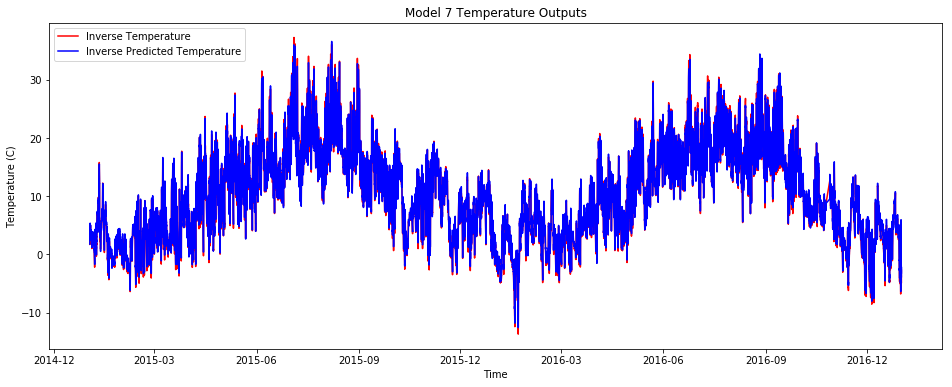

Model 7 Kaggle Prediction Test RMSE: 0.751858
Model 7 Kaggle Prediction Test MAE: 0.538367


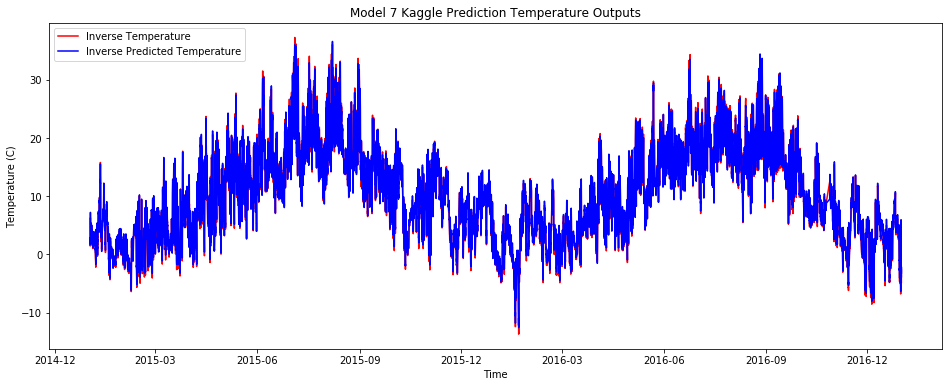

In [105]:
rmse7, mae7, pred_rmse7, pred_mae7 = create_and_save_pred_data(model7, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 7)

In [106]:
model_nums.append(7)
scores.append(score7)
pred_scores.append(pred_score7)
rmse_vals.append(rmse7)
pred_rmse_vals.append(pred_rmse7)
mae_vals.append(mae7)
pred_mae_vals.append(pred_mae7)

# Model 8 - 1 LSTM Layer With 50 Nodes, LSTM Activation ReLU, 20 Epochs, Batch Size 10

In [107]:
model8 = Sequential()
model8.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), activation = 'relu'))
model8.add(Dense(1))

model8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [108]:
model8.compile(loss = 'mae', optimizer = 'adam')

In [109]:
batch_model8 = 10
model8_history = model8.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model8, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0139 - val_loss: 0.0109
Epoch 2/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0099 - val_loss: 0.0111
Epoch 3/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0094 - val_loss: 0.0113
Epoch 4/20
52542/52542 [==============================] - 68s 1ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 5/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 6/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 7/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0088 - val_loss: 0.0102
Epoch 8/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 9/20
52542/52542 [==============================] - 69s 1ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch

In [110]:
model8.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model8.h5')

model8_hist_dict = model8_history.history
model8_hist_json = json.dumps(model8_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model8_hist.json', 'w')
f.write(model8_hist_json)
f.close()

In [111]:
#model8 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model8.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model8_hist.json', 'r')
#model8_hist_json = f.read()
#f.close()
#model8_hist_dict = json.loads(model8_hist_json)

#print(model8.summary())
#print(model8_hist_dict)


17447/17447 [==============================] - 4s 224us/step
Model 8 Test Loss Score:  0.009113395455641769


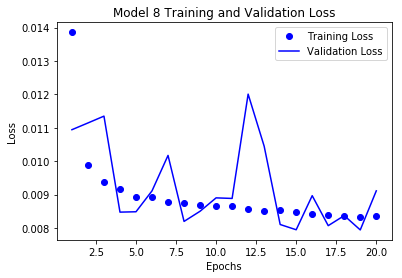

17471/17471 [==============================] - 4s 215us/step
Model 8 Kaggle Test Loss Score:  0.009114246754140253


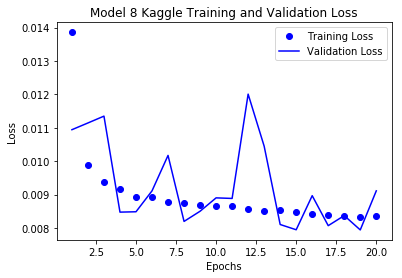

In [112]:
score8, pred_score8 = evaluate_model(model8, model8_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model8, 8)

Model 8 Test RMSE: 0.764299
Model 8 Test MAE: 0.547168




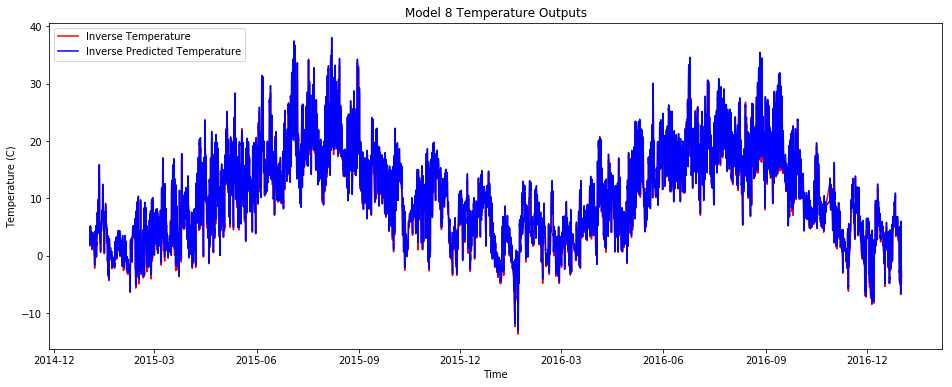

Model 8 Kaggle Prediction Test RMSE: 0.764225
Model 8 Kaggle Prediction Test MAE: 0.547219


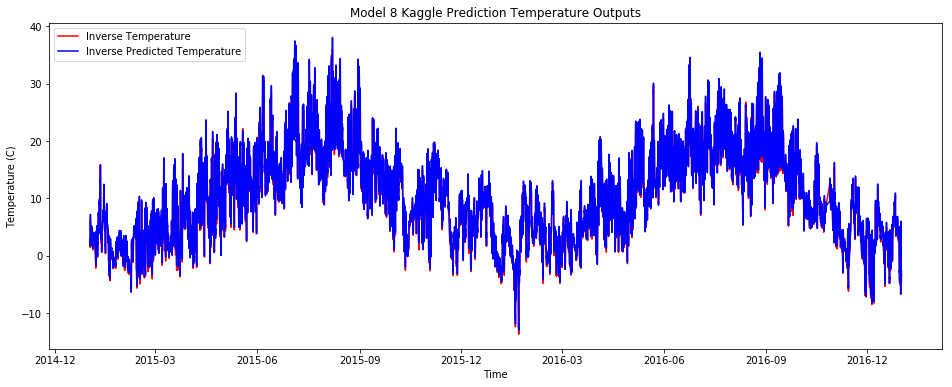

In [113]:
rmse8, mae8, pred_rmse8, pred_mae8 = create_and_save_pred_data(model8, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 8)

In [114]:
model_nums.append(8)
scores.append(score8)
pred_scores.append(pred_score8)
rmse_vals.append(rmse8)
pred_rmse_vals.append(pred_rmse8)
mae_vals.append(mae8)
pred_mae_vals.append(pred_mae8)

# Model 9 - 1 LSTM Layer With 50 Nodes, Dense Activation ReLU, 20 Epochs, Batch Size 10

In [115]:
model9 = Sequential()
model9.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model9.add(Dense(1, activation = 'relu'))

model9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [116]:
model9.compile(loss = 'mae', optimizer = 'adam')

In [117]:
batch_model9 = 10
model9_history = model8.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model9, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 2/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 3/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 4/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 5/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 6/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0083 - val_loss: 0.0091
Epoch 7/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 8/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 9/20
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch

In [118]:
model9.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model9.h5')

model9_hist_dict = model9_history.history
model9_hist_json = json.dumps(model9_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model9_hist.json', 'w')
f.write(model9_hist_json)
f.close()

In [119]:
#model9 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model9.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model9_hist.json', 'r')
#model9_hist_json = f.read()
#f.close()
#model9_hist_dict = json.loads(model9_hist_json)

#print(model9.summary())
#print(model9_hist_dict)


17447/17447 [==============================] - 4s 236us/step
Model 9 Test Loss Score:  0.061764768026744604


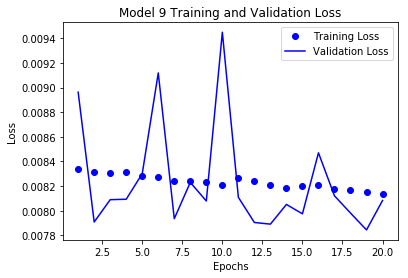

17471/17471 [==============================] - 4s 213us/step
Model 9 Kaggle Test Loss Score:  0.06180642559125642


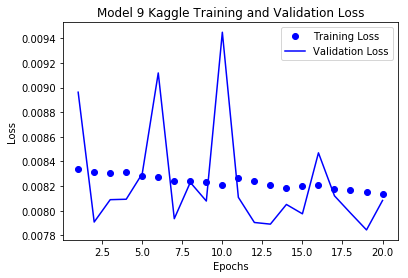

In [120]:
score9, pred_score9 = evaluate_model(model9, model9_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model9, 9)

Model 9 Test RMSE: 4.436731
Model 9 Test MAE: 3.708357




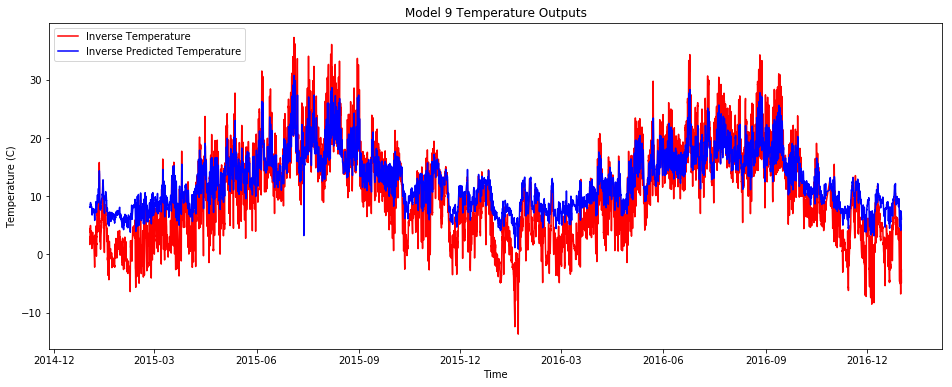

Model 9 Kaggle Prediction Test RMSE: 4.438673
Model 9 Kaggle Prediction Test MAE: 3.710858


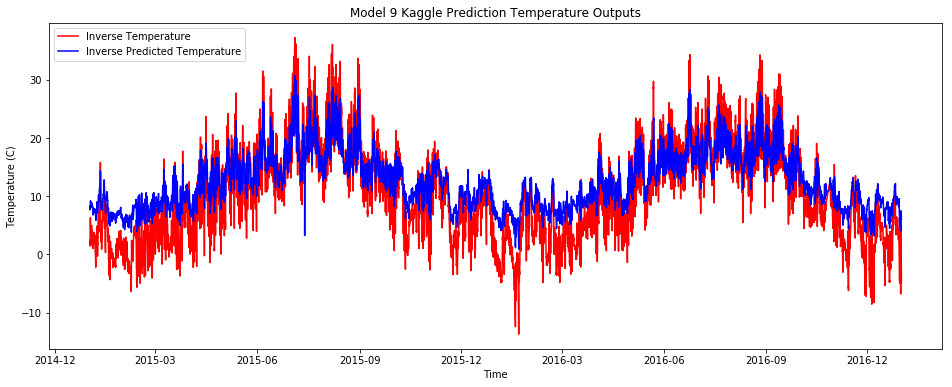

In [121]:
rmse9, mae9, pred_rmse9, pred_mae9 = create_and_save_pred_data(model9, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 9)

In [122]:
model_nums.append(9)
scores.append(score9)
pred_scores.append(pred_score9)
rmse_vals.append(rmse9)
pred_rmse_vals.append(pred_rmse9)
mae_vals.append(mae9)
pred_mae_vals.append(pred_mae9)

# Model 10 - 1 LSTM Layer With 50 Nodes, 20 Epochs, Batch Size 5

In [123]:
model10 = Sequential()
model10.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model10.add(Dense(1))

model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [124]:
model10.compile(loss = 'mae', optimizer = 'adam')

In [125]:
batch_model10 = 5
model10_history = model10.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model10, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 140s 3ms/step - loss: 0.0131 - val_loss: 0.0095
Epoch 2/20
52542/52542 [==============================] - 140s 3ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 3/20
52542/52542 [==============================] - 140s 3ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 4/20
52542/52542 [==============================] - 143s 3ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 5/20
52542/52542 [==============================] - 145s 3ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 6/20
52542/52542 [==============================] - 142s 3ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 7/20
52542/52542 [==============================] - 141s 3ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 8/20
52542/52542 [==============================] - 140s 3ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 9/20
52542/52542 [==============================] - 140s 3ms/step - loss: 0.0087 - val_loss: 0.0

In [126]:
model10.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model10.h5')

model10_hist_dict = model10_history.history
model10_hist_json = json.dumps(model10_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model10_hist.json', 'w')
f.write(model10_hist_json)
f.close()

In [127]:
#model10 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model10.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model10_hist.json', 'r')
#model10_hist_json = f.read()
#f.close()
#model10_hist_dict = json.loads(model10_hist_json)

#print(model10.summary())
#print(model10_hist_dict)


17447/17447 [==============================] - 7s 415us/step
Model 10 Test Loss Score:  0.010022366925251014


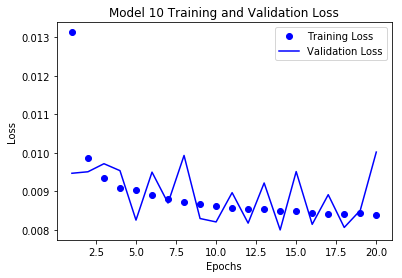

17471/17471 [==============================] - 7s 399us/step
Model 10 Kaggle Test Loss Score:  0.010021299363071454


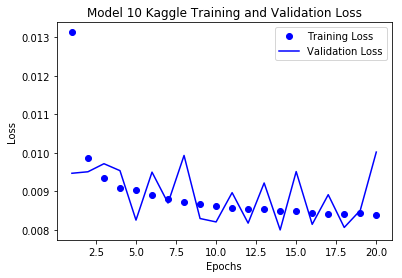

In [128]:
score10, pred_score10 = evaluate_model(model10, model10_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model10, 10)

Model 10 Test RMSE: 0.798108
Model 10 Test MAE: 0.601743




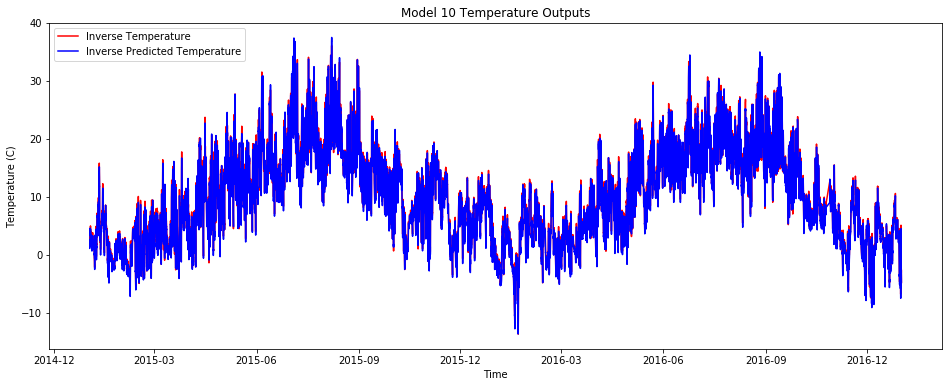

Model 10 Kaggle Prediction Test RMSE: 0.797996
Model 10 Kaggle Prediction Test MAE: 0.601679


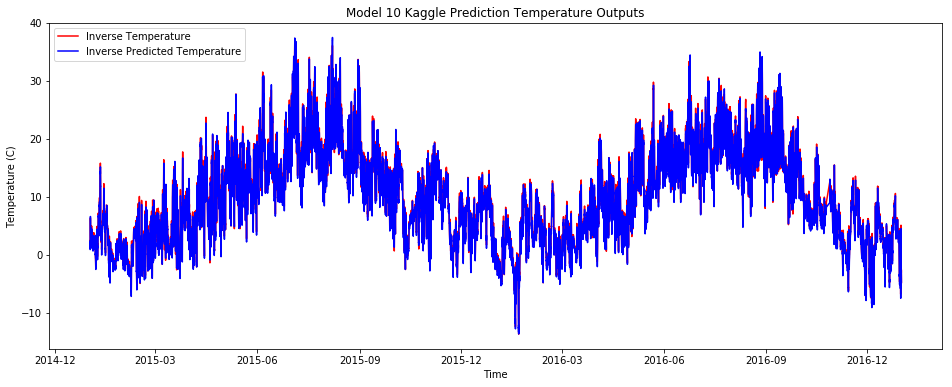

In [129]:
rmse10, mae10, pred_rmse10, pred_mae10 = create_and_save_pred_data(model10, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 10)

In [130]:
model_nums.append(10)
scores.append(score10)
pred_scores.append(pred_score10)
rmse_vals.append(rmse10)
pred_rmse_vals.append(pred_rmse10)
mae_vals.append(mae10)
pred_mae_vals.append(pred_mae10)

# Model 11 - 1 LSTM Layer With 50 Nodes, 20 Epochs, Batch Size 100

In [131]:
model11 = Sequential()
model11.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model11.add(Dense(1))

model11.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [132]:
model11.compile(loss = 'mae', optimizer = 'adam')

In [133]:
batch_model11 = 100
model11_history = model11.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model11, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 11s 206us/step - loss: 0.0212 - val_loss: 0.0102
Epoch 2/20
52542/52542 [==============================] - 9s 176us/step - loss: 0.0099 - val_loss: 0.0089
Epoch 3/20
52542/52542 [==============================] - 9s 179us/step - loss: 0.0092 - val_loss: 0.0104
Epoch 4/20
52542/52542 [==============================] - 9s 180us/step - loss: 0.0089 - val_loss: 0.0096
Epoch 5/20
52542/52542 [==============================] - 10s 185us/step - loss: 0.0089 - val_loss: 0.0085
Epoch 6/20
52542/52542 [==============================] - 9s 174us/step - loss: 0.0088 - val_loss: 0.0091
Epoch 7/20
52542/52542 [==============================] - 10s 181us/step - loss: 0.0087 - val_loss: 0.0086
Epoch 8/20
52542/52542 [==============================] - 9s 178us/step - loss: 0.0087 - val_loss: 0.0088
Epoch 9/20
52542/52542 [==============================] - 9s 175us/step - loss: 0.0087 - val_loss: 

In [134]:
model11.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model11.h5')

model11_hist_dict = model11_history.history
model11_hist_json = json.dumps(model11_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model11_hist.json', 'w')
f.write(model11_hist_json)
f.close()

In [135]:
#model11 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model11.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model11_hist.json', 'r')
#model11_hist_json = f.read()
#f.close()
#model11_hist_dict = json.loads(model11_hist_json)

#print(model11.summary())
#print(model11_hist_dict)


17447/17447 [==============================] - 1s 47us/step
Model 11 Test Loss Score:  0.00815896959173059


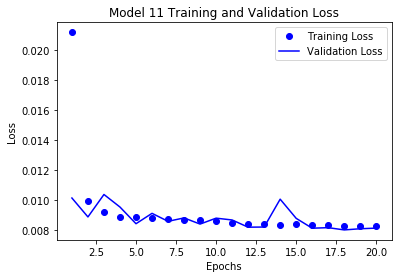

17471/17471 [==============================] - 1s 47us/step
Model 11 Kaggle Test Loss Score:  0.008158163718248497


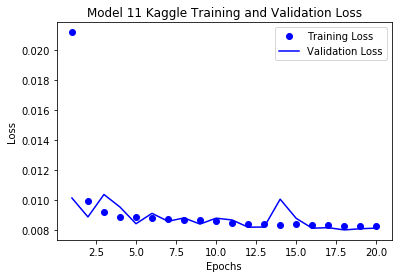

In [136]:
score11, pred_score11 = evaluate_model(model11, model11_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model11, 11)

Model 11 Test RMSE: 0.733627
Model 11 Test MAE: 0.489865




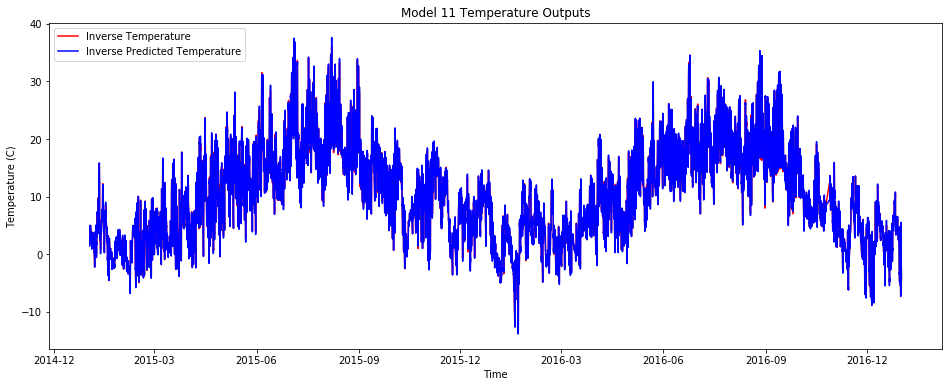

Model 11 Kaggle Prediction Test RMSE: 0.733457
Model 11 Kaggle Prediction Test MAE: 0.489816


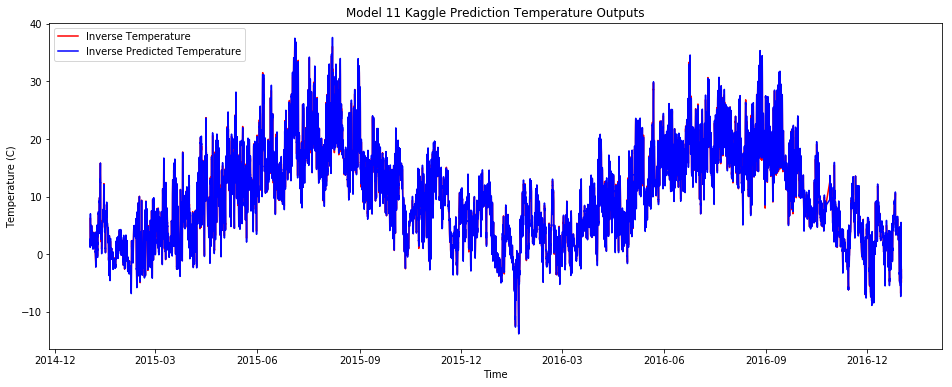

In [137]:
rmse11, mae11, pred_rmse11, pred_mae11 = create_and_save_pred_data(model11, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 11)

In [138]:
model_nums.append(11)
scores.append(score11)
pred_scores.append(pred_score11)
rmse_vals.append(rmse11)
pred_rmse_vals.append(pred_rmse11)
mae_vals.append(mae11)
pred_mae_vals.append(pred_mae11)

# Model 12 - 1 LSTM Layer With 50 Nodes, 20% LSTM Input Dropouts, 20 Epochs, Batch Size 10

In [139]:
model12 = Sequential()
model12.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), dropout = 0.2))
model12.add(Dense(1))

model12.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [140]:
model12.compile(loss = 'mae', optimizer = 'adam')

In [141]:
batch_model12 = 10
model12_history = model12.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model12, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0287 - val_loss: 0.0257
Epoch 2/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0182 - val_loss: 0.0659
Epoch 3/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0142 - val_loss: 0.0915
Epoch 4/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0129 - val_loss: 0.0850
Epoch 5/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0123 - val_loss: 0.0951
Epoch 6/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0120 - val_loss: 0.0886
Epoch 7/20
52542/52542 [==============================] - 70s 1ms/step - loss: 0.0117 - val_loss: 0.0886
Epoch 8/20
52542/52542 [==============================] - 71s 1ms/step - loss: 0.0114 - val_loss: 0.1007
Epoch 9/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0112 - val_loss: 0.1000
Epoch

In [142]:
model12.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model12.h5')

model12_hist_dict = model12_history.history
model12_hist_json = json.dumps(model12_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model12_hist.json', 'w')
f.write(model12_hist_json)
f.close()

In [143]:
#model12 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model12.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model12_hist.json', 'r')
#model12_hist_json = f.read()
#f.close()
#model12_hist_dict = json.loads(model12_hist_json)

#print(model12.summary())
#print(model12_hist_dict)


17447/17447 [==============================] - 4s 236us/step
Model 12 Test Loss Score:  0.10405109140082691


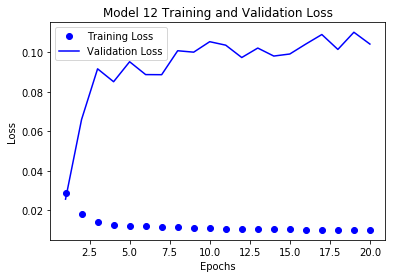

17471/17471 [==============================] - 4s 237us/step
Model 12 Kaggle Test Loss Score:  0.10402045281163938


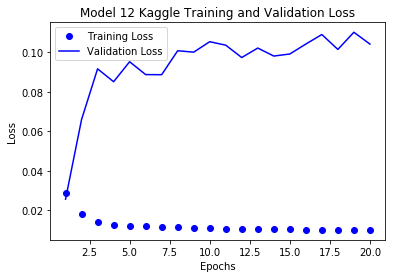

In [144]:
score12, pred_score12 = evaluate_model(model12, model12_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model12, 12)

Model 12 Test RMSE: 6.422033
Model 12 Test MAE: 6.247228




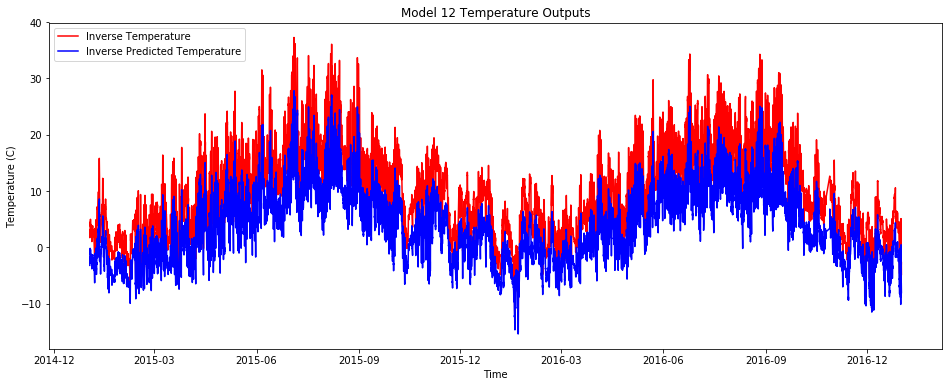

Model 12 Kaggle Prediction Test RMSE: 6.420228
Model 12 Kaggle Prediction Test MAE: 6.245388


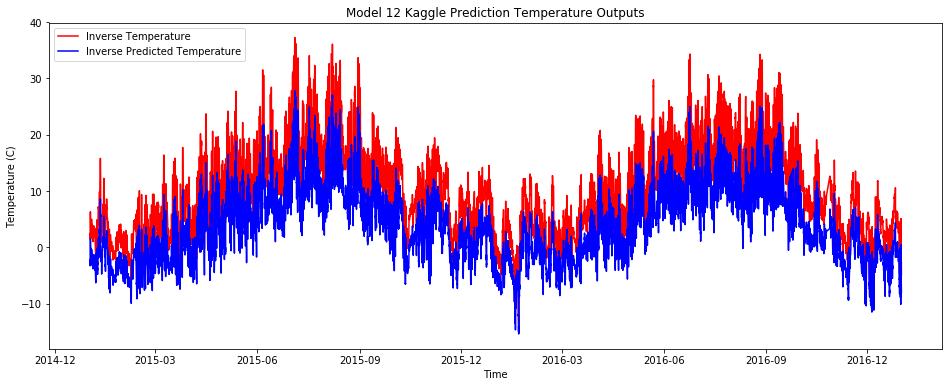

In [145]:
rmse12, mae12, pred_rmse12, pred_mae12 = create_and_save_pred_data(model12, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 12)

In [146]:
model_nums.append(12)
scores.append(score12)
pred_scores.append(pred_score12)
rmse_vals.append(rmse12)
pred_rmse_vals.append(pred_rmse12)
mae_vals.append(mae12)
pred_mae_vals.append(pred_mae12)

# Model 13 - 1 LSTM Layer With 50 Nodes, 20% LSTM Recurrent Dropouts, 20 Epochs, Batch Size 10

In [147]:
model13 = Sequential()
model13.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), recurrent_dropout = 0.2))
model13.add(Dense(1))

model13.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [148]:
model13.compile(loss = 'mae', optimizer = 'adam')

In [149]:
batch_model13 = 10
model13_history = model13.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model13, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 79s 1ms/step - loss: 0.0154 - val_loss: 0.0112
Epoch 2/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0106 - val_loss: 0.0093
Epoch 3/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 4/20
52542/52542 [==============================] - 78s 1ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 5/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 6/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 7/20
52542/52542 [==============================] - 79s 1ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 8/20
52542/52542 [==============================] - 79s 2ms/step - loss: 0.0092 - val_loss: 0.0103
Epoch 9/20
52542/52542 [==============================] - 81s 2ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch

In [150]:
model13.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model13.h5')

model13_hist_dict = model13_history.history
model13_hist_json = json.dumps(model13_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model13_hist.json', 'w')
f.write(model13_hist_json)
f.close()

In [151]:
#model13 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model13.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model13_hist.json', 'r')
#model13_hist_json = f.read()
#f.close()
#model13_hist_dict = json.loads(model13_hist_json)

#print(model13.summary())
#print(model13_hist_dict)


17447/17447 [==============================] - 4s 241us/step
Model 13 Test Loss Score:  0.008271498148808749


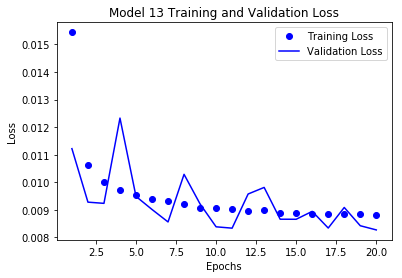

17471/17471 [==============================] - 4s 240us/step
Model 13 Kaggle Test Loss Score:  0.008270294384263887


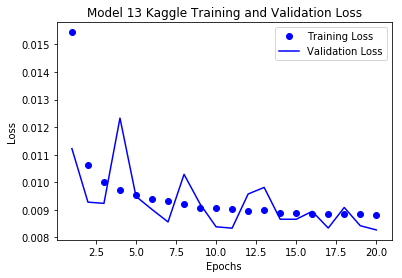

In [152]:
score13, pred_score13 = evaluate_model(model13, model13_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model13, 13)

Model 13 Test RMSE: 0.732423
Model 13 Test MAE: 0.496621




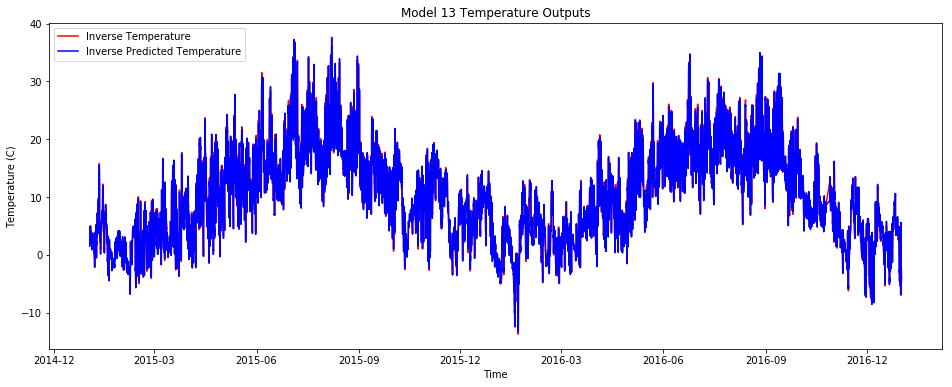

Model 13 Kaggle Prediction Test RMSE: 0.732261
Model 13 Kaggle Prediction Test MAE: 0.496548


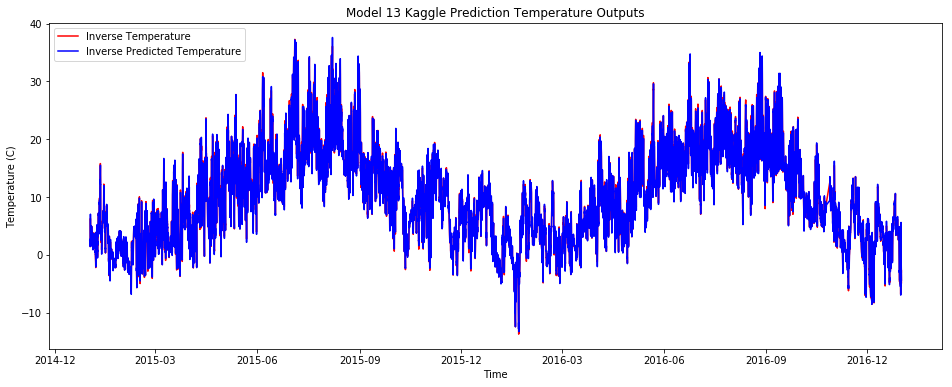

In [153]:
rmse13, mae13, pred_rmse13, pred_mae13 = create_and_save_pred_data(model13, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 13)

In [154]:
model_nums.append(13)
scores.append(score13)
pred_scores.append(pred_score13)
rmse_vals.append(rmse13)
pred_rmse_vals.append(pred_rmse13)
mae_vals.append(mae13)
pred_mae_vals.append(pred_mae13)

# Model 14 - 1 LSTM Layer With 50 Nodes, L2 Kernel Regularizer With Lambda 0.001, 20 Epochs, Batch Size 10

In [155]:
model14 = Sequential()
model14.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), kernel_regularizer = 
                 keras.regularizers.l2(0.001)))
model14.add(Dense(1))

model14.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [156]:
model14.compile(loss = 'mae', optimizer = 'adam')

In [157]:
batch_model14 = 10
model14_history = model14.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model14, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0203 - val_loss: 0.0128
Epoch 2/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0121 - val_loss: 0.0100
Epoch 3/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0113 - val_loss: 0.0098
Epoch 4/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 5/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0106 - val_loss: 0.0093
Epoch 6/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 7/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0102 - val_loss: 0.0148
Epoch 8/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0100 - val_loss: 0.0110
Epoch 9/20
52542/52542 [==============================] - 72s 1ms/step - loss: 0.0099 - val_loss: 0.0113
Epoch

In [158]:
model14.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model14.h5')

model14_hist_dict = model14_history.history
model14_hist_json = json.dumps(model14_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model14_hist.json', 'w')
f.write(model14_hist_json)
f.close()

In [159]:
#model14 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model14.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model14_hist.json', 'r')
#model14_hist_json = f.read()
#f.close()
#model14_hist_dict = json.loads(model14_hist_json)

#print(model14.summary())
#print(model14_hist_dict)


17447/17447 [==============================] - 4s 226us/step
Model 14 Test Loss Score:  0.009643146030686191


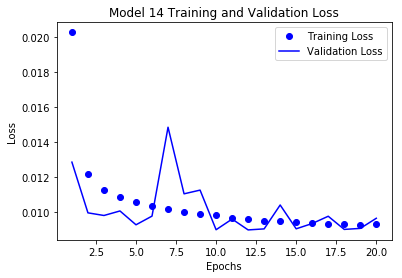

17471/17471 [==============================] - 4s 227us/step
Model 14 Kaggle Test Loss Score:  0.009641196219346832


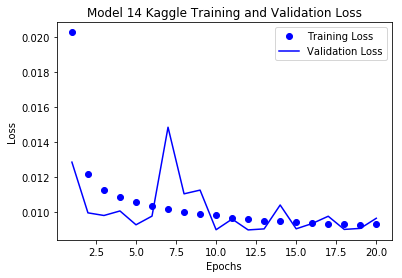

In [160]:
score14, pred_score14 = evaluate_model(model14, model14_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model14, 14)

Model 14 Test RMSE: 0.781005
Model 14 Test MAE: 0.551275




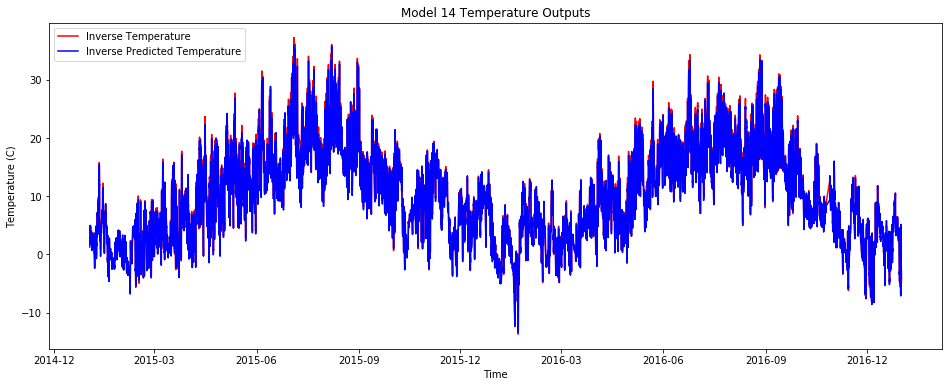

Model 14 Kaggle Prediction Test RMSE: 0.780789
Model 14 Kaggle Prediction Test MAE: 0.551158


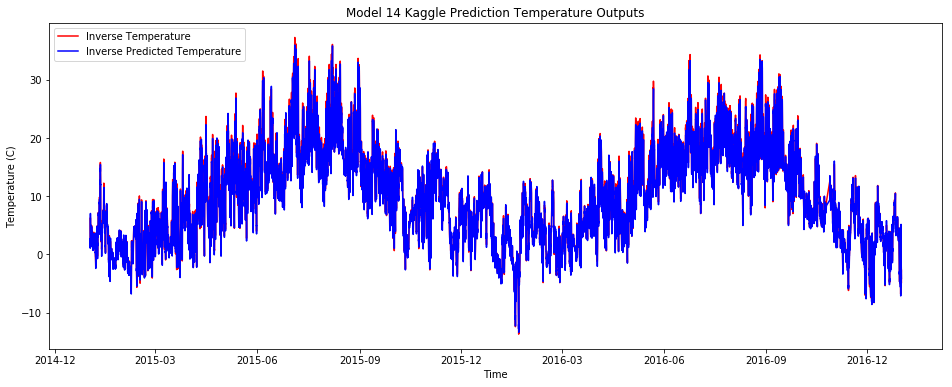

In [161]:
rmse14, mae14, pred_rmse14, pred_mae14 = create_and_save_pred_data(model14, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 14)

In [162]:
model_nums.append(14)
scores.append(score14)
pred_scores.append(pred_score14)
rmse_vals.append(rmse14)
pred_rmse_vals.append(pred_rmse14)
mae_vals.append(mae14)
pred_mae_vals.append(pred_mae14)

# Model 15 - 1 LSTM Layer With 50 Nodes, L2 Kernel Regularizer With Lambda 0.1, 20 Epochs, Batch Size 10

In [163]:
model15 = Sequential()
model15.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), kernel_regularizer = 
                 keras.regularizers.l2(0.1)))
model15.add(Dense(1))

model15.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [164]:
model15.compile(loss = 'mae', optimizer = 'adam')

In [165]:
batch_model15 = 10
model15_history = model15.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model15, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0626 - val_loss: 0.0214
Epoch 2/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0180 - val_loss: 0.0152
Epoch 3/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0159 - val_loss: 0.0177
Epoch 4/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0149 - val_loss: 0.0138
Epoch 5/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0146 - val_loss: 0.0166
Epoch 6/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 7/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0141 - val_loss: 0.0132
Epoch 8/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 9/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0137 - val_loss: 0.0165
Epoch

In [166]:
model15.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model15.h5')

model15_hist_dict = model15_history.history
model15_hist_json = json.dumps(model15_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model15_hist.json', 'w')
f.write(model15_hist_json)
f.close()

In [167]:
#model15 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model15.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model15_hist.json', 'r')
#model15_hist_json = f.read()
#f.close()
#model15_hist_dict = json.loads(model15_hist_json)

#print(model15.summary())
#print(model15_hist_dict)


17447/17447 [==============================] - 4s 223us/step
Model 15 Test Loss Score:  0.011823725233857711


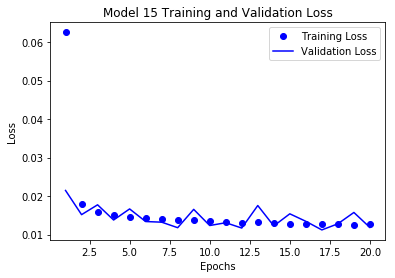

17471/17471 [==============================] - 4s 230us/step
Model 15 Kaggle Test Loss Score:  0.011823112589458147


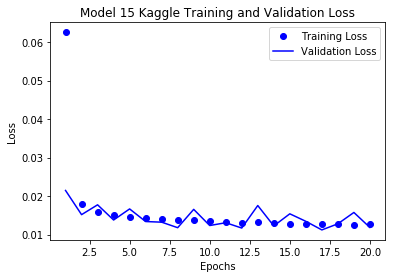

In [168]:
score15, pred_score15 = evaluate_model(model15, model15_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model15, 15)

Model 15 Test RMSE: 0.810058
Model 15 Test MAE: 0.588220




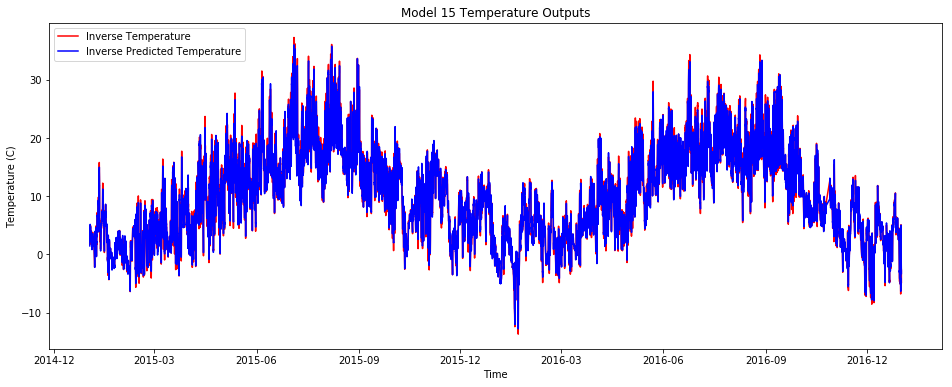

Model 15 Kaggle Prediction Test RMSE: 0.810015
Model 15 Kaggle Prediction Test MAE: 0.588183


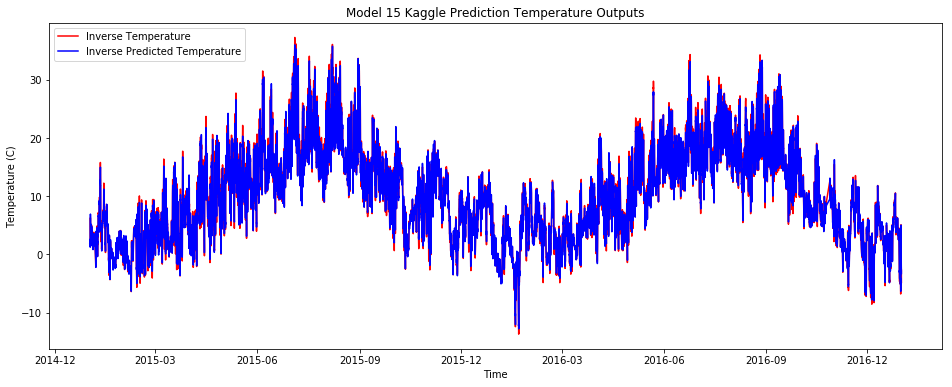

In [169]:
rmse15, mae15, pred_rmse15, pred_mae15 = create_and_save_pred_data(model15, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 15)

In [170]:
model_nums.append(15)
scores.append(score15)
pred_scores.append(pred_score15)
rmse_vals.append(rmse15)
pred_rmse_vals.append(pred_rmse15)
mae_vals.append(mae15)
pred_mae_vals.append(pred_mae15)

# Model 16 - 1 LSTM Layer With 50 Nodes, L1 Kernel Regularizer With Lambda 0.001, 20 Epochs, Batch Size 10

In [171]:
model16 = Sequential()
model16.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), kernel_regularizer = 
                 keras.regularizers.l1(0.001)))
model16.add(Dense(1))

model16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [172]:
model16.compile(loss = 'mae', optimizer = 'adam')

In [173]:
batch_model16 = 10
model16_history = model16.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model16, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0412 - val_loss: 0.0174
Epoch 2/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 3/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0135 - val_loss: 0.0120
Epoch 4/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 5/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 6/20
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0115 - val_loss: 0.0125
Epoch 7/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0114 - val_loss: 0.0106
Epoch 8/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 9/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch

In [174]:
model16.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model16.h5')

model16_hist_dict = model16_history.history
model16_hist_json = json.dumps(model16_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model16_hist.json', 'w')
f.write(model16_hist_json)
f.close()

In [175]:
#model16 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model16.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model16_hist.json', 'r')
#model16_hist_json = f.read()
#f.close()
#model16_hist_dict = json.loads(model16_hist_json)

#print(model16.summary())
#print(model16_hist_dict)

17447/17447 [==============================] - 4s 222us/step
Model 16 Test Loss Score:  0.010911752910864037


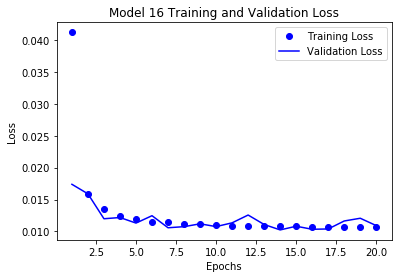

17471/17471 [==============================] - 4s 231us/step
Model 16 Kaggle Test Loss Score:  0.010911359133523068


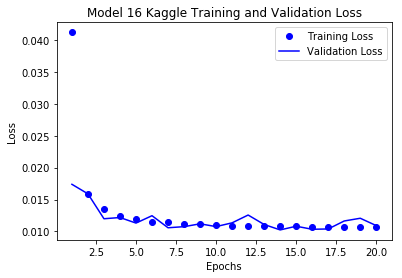

In [176]:
score16, pred_score16 = evaluate_model(model16, model16_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model16, 16)

Model 16 Test RMSE: 0.787244
Model 16 Test MAE: 0.554076




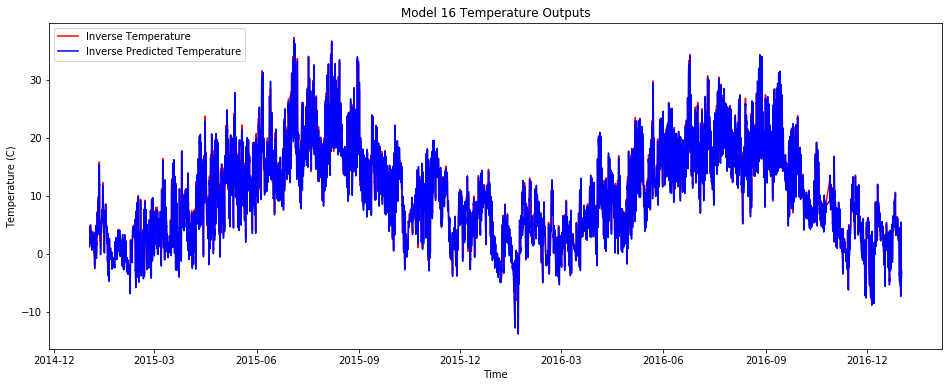

Model 16 Kaggle Prediction Test RMSE: 0.787142
Model 16 Kaggle Prediction Test MAE: 0.554052


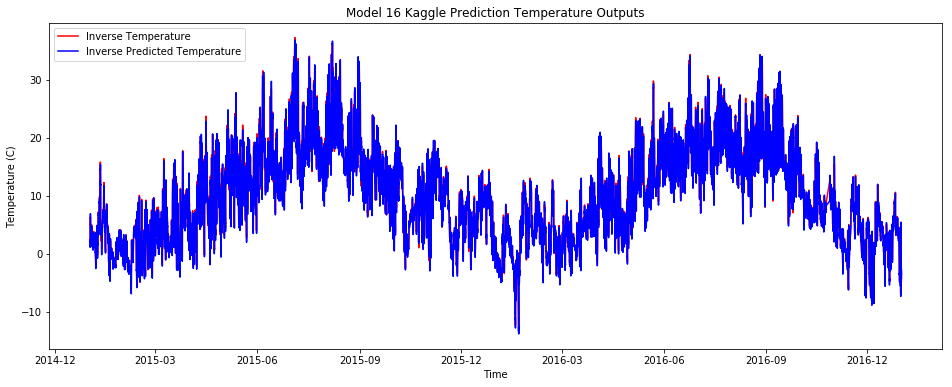

In [177]:
rmse16, mae16, pred_rmse16, pred_mae16 = create_and_save_pred_data(model16, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 16)

In [178]:
model_nums.append(16)
scores.append(score16)
pred_scores.append(pred_score16)
rmse_vals.append(rmse16)
pred_rmse_vals.append(pred_rmse16)
mae_vals.append(mae16)
pred_mae_vals.append(pred_mae16)

# Model 17 - 1 LSTM Layer With 50 Nodes, L1 Kernel Regularizer With Lambda 0.1, 20 Epochs, Batch Size 10

In [179]:
model17 = Sequential()
model17.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), kernel_regularizer = 
                 keras.regularizers.l1(0.1)))
model17.add(Dense(1))

model17.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [180]:
model17.compile(loss = 'mae', optimizer = 'adam')

In [181]:
batch_model17 = 10
model17_history = model17.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model17, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 79s 1ms/step - loss: 0.3633 - val_loss: 0.0726
Epoch 2/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0707 - val_loss: 0.0628
Epoch 3/20
52542/52542 [==============================] - 78s 1ms/step - loss: 0.0622 - val_loss: 0.0570
Epoch 4/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0593 - val_loss: 0.0617
Epoch 5/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0581 - val_loss: 0.0531
Epoch 6/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0576 - val_loss: 0.0538
Epoch 7/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0572 - val_loss: 0.0540
Epoch 8/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0567 - val_loss: 0.0527
Epoch 9/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0567 - val_loss: 0.0544
Epoch

In [182]:
model17.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model17.h5')

model17_hist_dict = model17_history.history
model17_hist_json = json.dumps(model17_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model17_hist.json', 'w')
f.write(model17_hist_json)
f.close()

In [183]:
#model17 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model17.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model17_hist.json', 'r')
#model17_hist_json = f.read()
#f.close()
#model17_hist_dict = json.loads(model17_hist_json)

#print(model17.summary())
#print(model17_hist_dict)

17447/17447 [==============================] - 4s 235us/step
Model 17 Test Loss Score:  0.054046257282387065


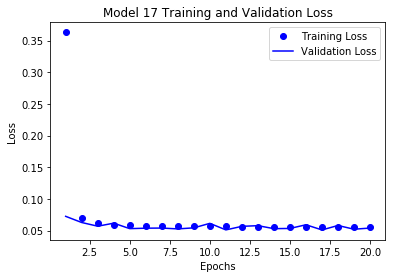

17471/17471 [==============================] - 4s 225us/step
Model 17 Kaggle Test Loss Score:  0.05404068787141532


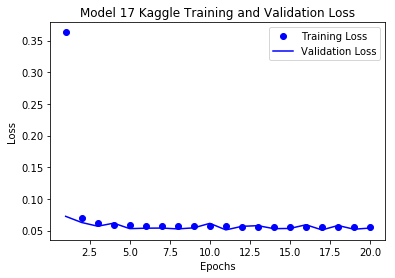

In [184]:
score17, pred_score17 = evaluate_model(model17, model17_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model17, 17)

Model 17 Test RMSE: 1.183093
Model 17 Test MAE: 0.906647




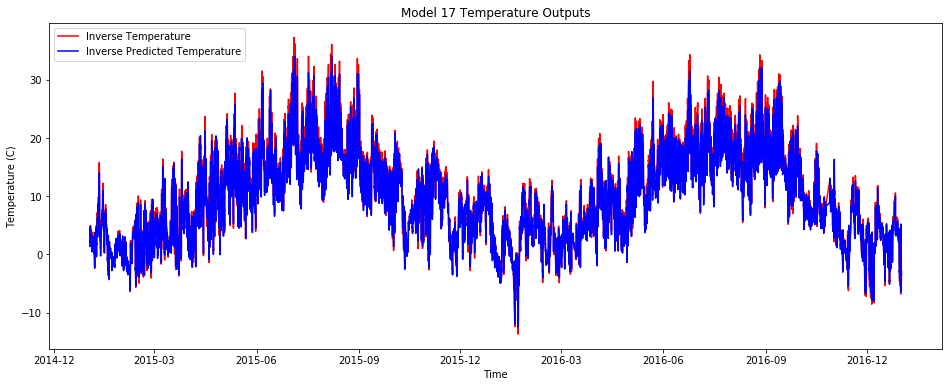

Model 17 Kaggle Prediction Test RMSE: 1.182887
Model 17 Kaggle Prediction Test MAE: 0.906312


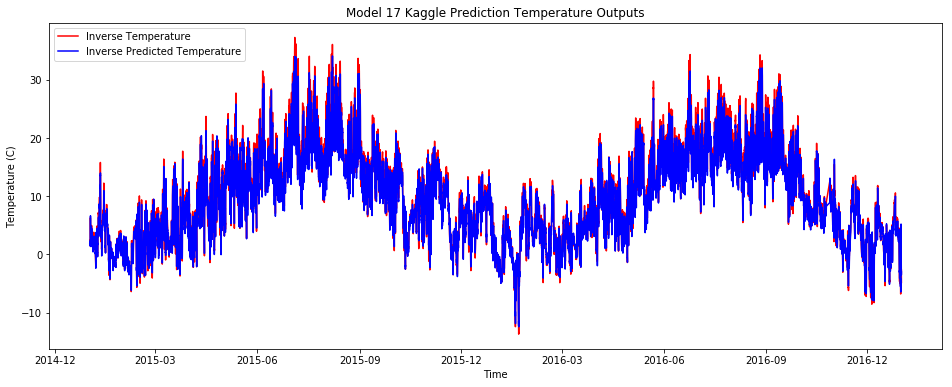

In [185]:
rmse17, mae17, pred_rmse17, pred_mae17 = create_and_save_pred_data(model17, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 17)

In [186]:
model_nums.append(17)
scores.append(score17)
pred_scores.append(pred_score17)
rmse_vals.append(rmse17)
pred_rmse_vals.append(pred_rmse17)
mae_vals.append(mae17)
pred_mae_vals.append(pred_mae17)

# Model 18 - 1 LSTM Layer With 50 Nodes, L2 Recurrent Regularizer With Lambda 0.001, 20 Epochs, Batch Size 10

In [187]:
model18 = Sequential()
model18.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), recurrent_regularizer = 
                 keras.regularizers.l2(0.001)))
model18.add(Dense(1))

model18.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [188]:
model18.compile(loss = 'mae', optimizer = 'adam')

In [189]:
batch_model18 = 10
model18_history = model18.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model18, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0196 - val_loss: 0.0110
Epoch 2/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0113 - val_loss: 0.0095
Epoch 3/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 4/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 5/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0098 - val_loss: 0.0104
Epoch 6/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0097 - val_loss: 0.0119
Epoch 7/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 8/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 9/20
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch

In [190]:
model18.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model18.h5')

model18_hist_dict = model18_history.history
model18_hist_json = json.dumps(model18_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model18_hist.json', 'w')
f.write(model18_hist_json)
f.close()

In [191]:
#model18 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model18.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model18_hist.json', 'r')
#model18_hist_json = f.read()
#f.close()
#model18_hist_dict = json.loads(model18_hist_json)

#print(model18.summary())
#print(model18_hist_dict)

17447/17447 [==============================] - 4s 223us/step
Model 18 Test Loss Score:  0.00865949981555741


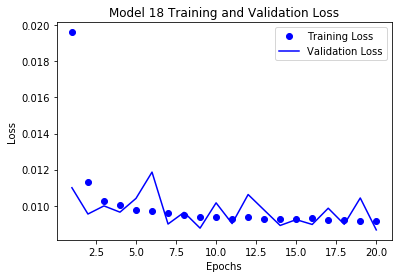

17471/17471 [==============================] - 4s 236us/step
Model 18 Kaggle Test Loss Score:  0.008658582233040174


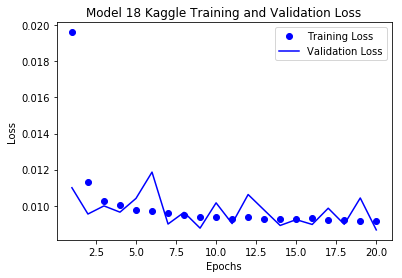

In [192]:
score18, pred_score18 = evaluate_model(model18, model18_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model18, 18)

Model 18 Test RMSE: 0.749671
Model 18 Test MAE: 0.507362




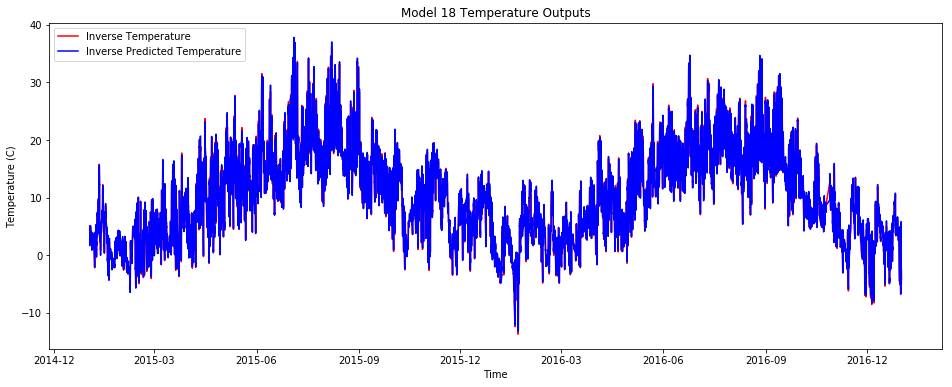

Model 18 Kaggle Prediction Test RMSE: 0.749529
Model 18 Kaggle Prediction Test MAE: 0.507307


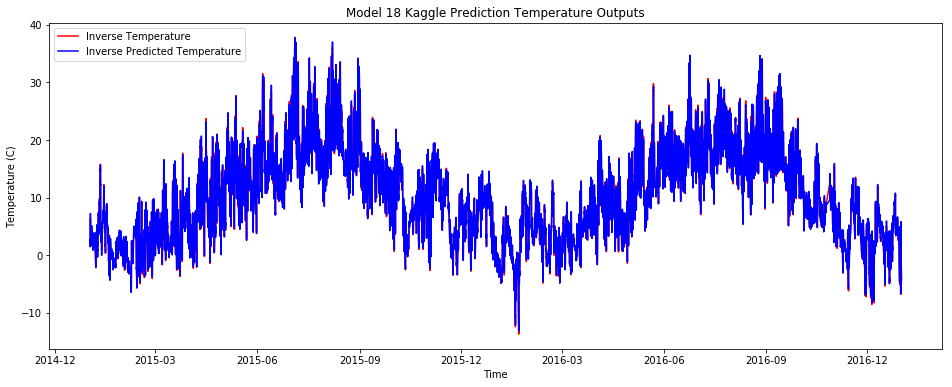

In [193]:
rmse18, mae18, pred_rmse18, pred_mae18 = create_and_save_pred_data(model18, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 18)

In [194]:
model_nums.append(18)
scores.append(score18)
pred_scores.append(pred_score18)
rmse_vals.append(rmse18)
pred_rmse_vals.append(pred_rmse18)
mae_vals.append(mae18)
pred_mae_vals.append(pred_mae18)

# Model 19 - 1 LSTM Layer With 50 Nodes, L2 Recurrent Regularizer With Lambda 0.1, 20 Epochs, Batch Size 10

In [195]:
model19 = Sequential()
model19.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), recurrent_regularizer = 
                 keras.regularizers.l2(0.1)))
model19.add(Dense(1))

model19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [196]:
model19.compile(loss = 'mae', optimizer = 'adam')

In [197]:
batch_model19 = 10
model19_history = model19.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model19, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 78s 1ms/step - loss: 0.0621 - val_loss: 0.0119
Epoch 2/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0117 - val_loss: 0.0100
Epoch 3/20
52542/52542 [==============================] - 78s 1ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 4/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 5/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 6/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 7/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 8/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0101 - val_loss: 0.0093
Epoch 9/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch

In [198]:
model19.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model19.h5')

model19_hist_dict = model19_history.history
model19_hist_json = json.dumps(model19_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model19_hist.json', 'w')
f.write(model19_hist_json)
f.close()

In [199]:
#model19 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model19.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model19_hist.json', 'r')
#model19_hist_json = f.read()
#f.close()
#model19_hist_dict = json.loads(model19_hist_json)

#print(model19.summary())
#print(model19_hist_dict)

17447/17447 [==============================] - 4s 235us/step
Model 19 Test Loss Score:  0.0092331633088626


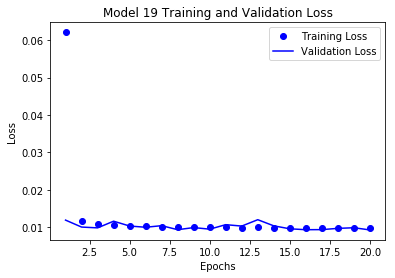

17471/17471 [==============================] - 4s 224us/step
Model 19 Kaggle Test Loss Score:  0.009233430677971154


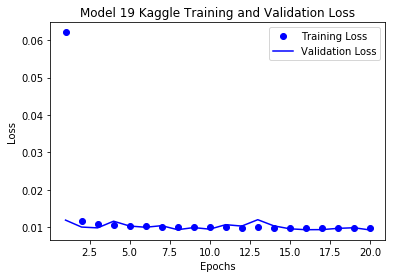

In [200]:
score19, pred_score19 = evaluate_model(model19, model19_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model19, 19)

Model 19 Test RMSE: 0.809772
Model 19 Test MAE: 0.553451




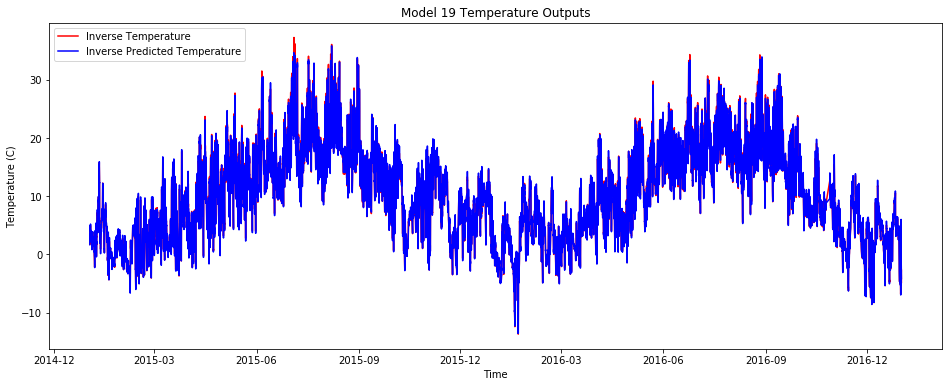

Model 19 Kaggle Prediction Test RMSE: 0.809732
Model 19 Kaggle Prediction Test MAE: 0.553467


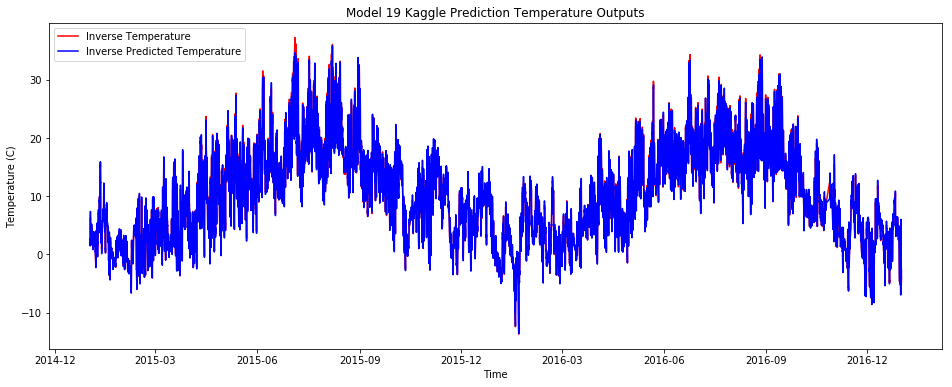

In [201]:
rmse19, mae19, pred_rmse19, pred_mae19 = create_and_save_pred_data(model19, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 19)

In [202]:
model_nums.append(19)
scores.append(score19)
pred_scores.append(pred_score19)
rmse_vals.append(rmse19)
pred_rmse_vals.append(pred_rmse19)
mae_vals.append(mae19)
pred_mae_vals.append(pred_mae19)

# Model 20 - 1 LSTM Layer With 50 Nodes, L1 Recurrent Regularizer With Lambda 0.001, 20 Epochs, Batch Size 10

In [203]:
model20 = Sequential()
model20.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), recurrent_regularizer = 
                 keras.regularizers.l1(0.001)))
model20.add(Dense(1))

model20.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [204]:
model20.compile(loss = 'mae', optimizer = 'adam')

In [205]:
batch_model20 = 10
model20_history = model20.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model20, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0331 - val_loss: 0.0166
Epoch 2/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0129 - val_loss: 0.0113
Epoch 3/20
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 4/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 5/20
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 6/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 7/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 8/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 9/20
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch

In [206]:
model20.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model20.h5')

model20_hist_dict = model20_history.history
model20_hist_json = json.dumps(model20_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model20_hist.json', 'w')
f.write(model20_hist_json)
f.close()

In [209]:
#model20 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model20.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model20_hist.json', 'r')
#model20_hist_json = f.read()
#f.close()
#model20_hist_dict = json.loads(model20_hist_json)

#print(model20.summary())
#print(model20_hist_dict)

17447/17447 [==============================] - 4s 253us/step
Model 20 Test Loss Score:  0.009859038248043562


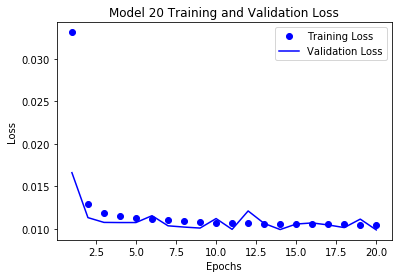

17471/17471 [==============================] - 5s 269us/step
Model 20 Kaggle Test Loss Score:  0.009859051692526792


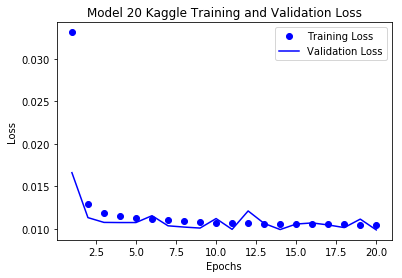

In [210]:
score20, pred_score20 = evaluate_model(model20, model20_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model20, 20)

Model 20 Test RMSE: 0.770337
Model 20 Test MAE: 0.525869




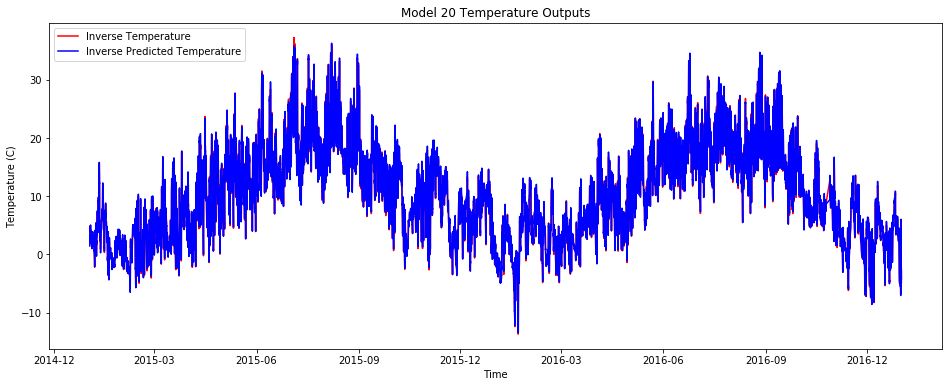

Model 20 Kaggle Prediction Test RMSE: 0.770277
Model 20 Kaggle Prediction Test MAE: 0.525870


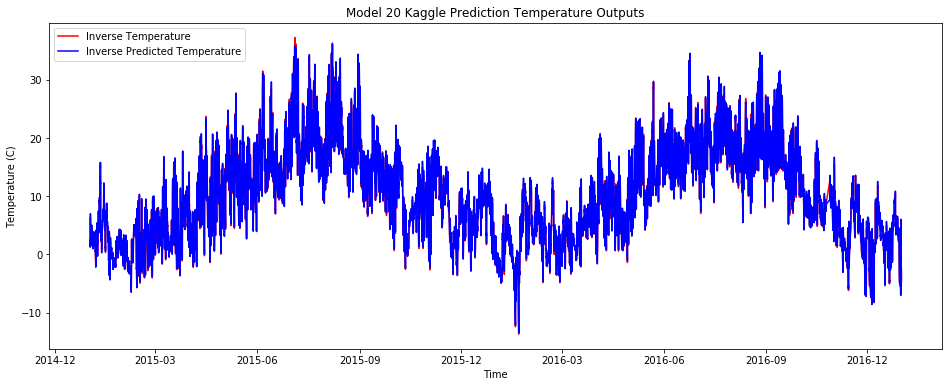

In [211]:
rmse20, mae20, pred_rmse20, pred_mae20 = create_and_save_pred_data(model20, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 20)

In [212]:
model_nums.append(20)
scores.append(score20)
pred_scores.append(pred_score20)
rmse_vals.append(rmse20)
pred_rmse_vals.append(pred_rmse20)
mae_vals.append(mae20)
pred_mae_vals.append(pred_mae20)

# Model 21 - 1 LSTM Layer With 50 Nodes, L1 Recurrent Regularizer With Lambda 0.1, 20 Epochs, Batch Size 10

In [213]:
model21 = Sequential()
model21.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), recurrent_regularizer = 
                 keras.regularizers.l1(0.1)))
model21.add(Dense(1))

model21.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [214]:
model21.compile(loss = 'mae', optimizer = 'adam')

In [215]:
batch_model21 = 10
model21_history = model21.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model21, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.6186 - val_loss: 0.1299
Epoch 2/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.1214 - val_loss: 0.1222
Epoch 3/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.1203 - val_loss: 0.1181
Epoch 4/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.1196 - val_loss: 0.1179
Epoch 5/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.1191 - val_loss: 0.1216
Epoch 6/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.1189 - val_loss: 0.1206
Epoch 7/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.1188 - val_loss: 0.1216
Epoch 8/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.1184 - val_loss: 0.1192
Epoch 9/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.1180 - val_loss: 0.1169
Epoch

In [216]:
model21.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model21.h5')

model21_hist_dict = model21_history.history
model21_hist_json = json.dumps(model21_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model21_hist.json', 'w')
f.write(model21_hist_json)
f.close()

In [219]:
#model21 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model21.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model21_hist.json', 'r')
#model21_hist_json = f.read()
#f.close()
#model21_hist_dict = json.loads(model21_hist_json)

#print(model21.summary())
#print(model21_hist_dict)

17447/17447 [==============================] - 4s 237us/step
Model 21 Test Loss Score:  0.11858629209097322


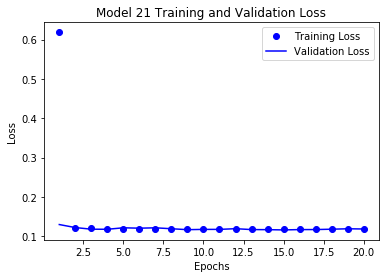

17471/17471 [==============================] - 4s 233us/step
Model 21 Kaggle Test Loss Score:  0.11858720965540598


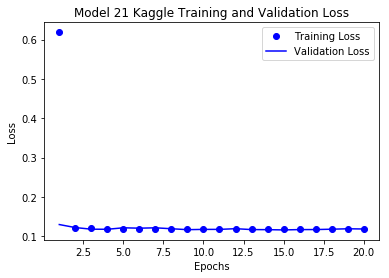

In [220]:
score21, pred_score21 = evaluate_model(model21, model21_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model21, 21)

Model 21 Test RMSE: 0.804205
Model 21 Test MAE: 0.577961




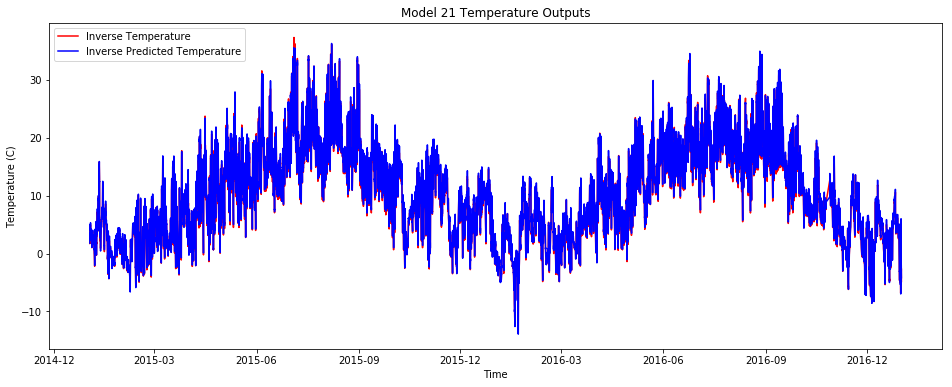

Model 21 Kaggle Prediction Test RMSE: 0.804209
Model 21 Kaggle Prediction Test MAE: 0.578016


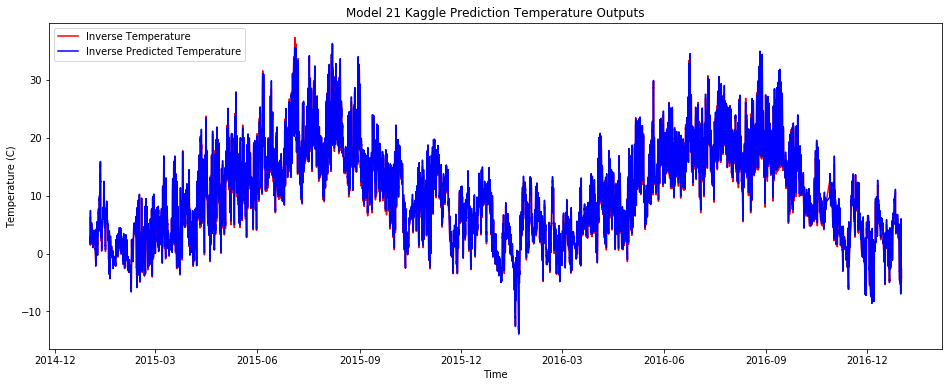

In [221]:
rmse21, mae21, pred_rmse21, pred_mae21 = create_and_save_pred_data(model21, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 21)

In [222]:
model_nums.append(21)
scores.append(score21)
pred_scores.append(pred_score21)
rmse_vals.append(rmse21)
pred_rmse_vals.append(pred_rmse21)
mae_vals.append(mae21)
pred_mae_vals.append(pred_mae21)

# Model 22 - 2 LSTM Layer With 50 Nodes Each, 1 Additional Dense Layer With 50 Nodes, 20 Epochs, Batch Size 10

In [228]:
model22 = Sequential()
model22.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences = True))
model22.add(LSTM(50, return_sequences = False))
model22.add(Dense(50))
model22.add(Dense(1))

model22.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 24, 50)            13000     
_________________________________________________________________
lstm_27 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_26 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 51        
Total params: 35,801
Trainable params: 35,801
Non-trainable params: 0
_________________________________________________________________


In [229]:
model22.compile(loss = 'mae', optimizer = 'adam')

In [230]:
batch_model22 = 10
model22_history = model22.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model22, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 124s 2ms/step - loss: 0.0145 - val_loss: 0.0089
Epoch 2/20
52542/52542 [==============================] - 124s 2ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 3/20
52542/52542 [==============================] - 123s 2ms/step - loss: 0.0100 - val_loss: 0.0103
Epoch 4/20
52542/52542 [==============================] - 124s 2ms/step - loss: 0.0097 - val_loss: 0.0135
Epoch 5/20
52542/52542 [==============================] - 123s 2ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 6/20
52542/52542 [==============================] - 123s 2ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 7/20
52542/52542 [==============================] - 122s 2ms/step - loss: 0.0092 - val_loss: 0.0101
Epoch 8/20
52542/52542 [==============================] - 123s 2ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 9/20
52542/52542 [==============================] - 124s 2ms/step - loss: 0.0090 - val_loss: 0.0

In [231]:
model22.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model22.h5')

model22_hist_dict = model22_history.history
model22_hist_json = json.dumps(model22_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model22_hist.json', 'w')
f.write(model22_hist_json)
f.close()

In [232]:
#model22 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model22.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model22_hist.json', 'r')
#model22_hist_json = f.read()
#f.close()
#model22_hist_dict = json.loads(model22_hist_json)

#print(model22.summary())
#print(model22_hist_dict)

17447/17447 [==============================] - 8s 431us/step
Model 22 Test Loss Score:  0.007942722120597781


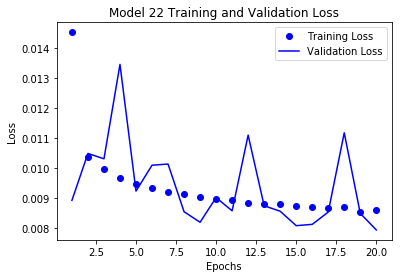

17471/17471 [==============================] - 7s 428us/step
Model 22 Kaggle Test Loss Score:  0.007942498501350878


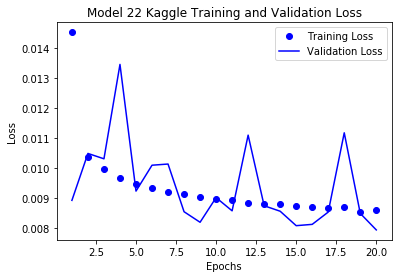

In [233]:
score22, pred_score22 = evaluate_model(model22, model22_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model22, 22)

Model 22 Test RMSE: 0.710774
Model 22 Test MAE: 0.476881




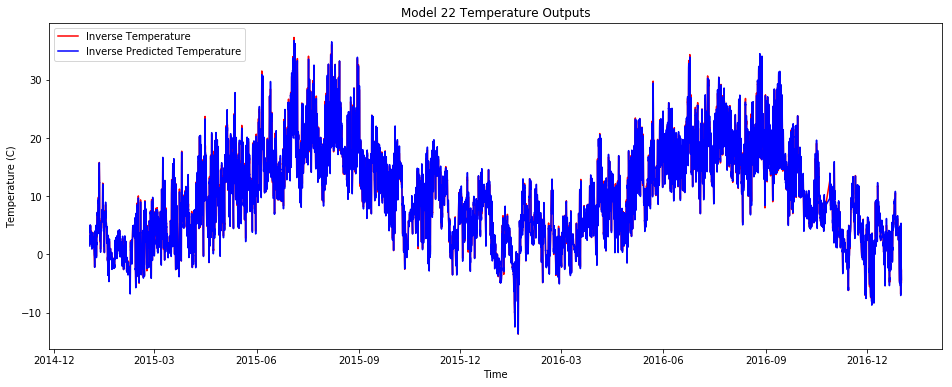

Model 22 Kaggle Prediction Test RMSE: 0.710663
Model 22 Kaggle Prediction Test MAE: 0.476868


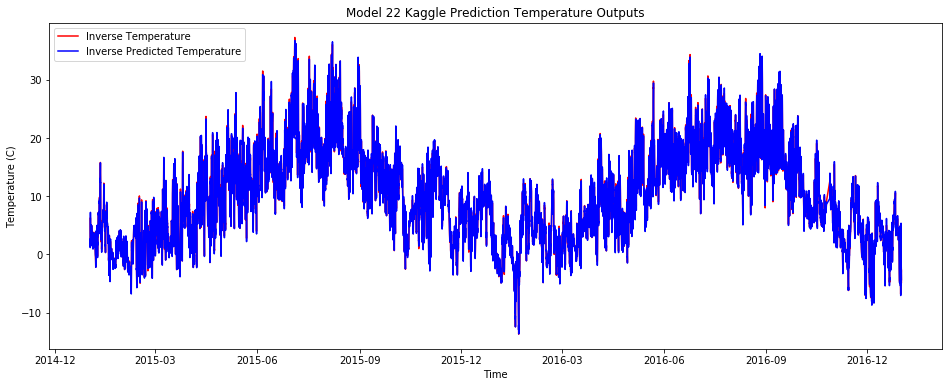

In [234]:
rmse22, mae22, pred_rmse22, pred_mae22 = create_and_save_pred_data(model22, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 22)

In [235]:
model_nums.append(22)
scores.append(score22)
pred_scores.append(pred_score22)
rmse_vals.append(rmse22)
pred_rmse_vals.append(pred_rmse22)
mae_vals.append(mae22)
pred_mae_vals.append(pred_mae22)

# Model 23 - 2 LSTM Layer With 20 Nodes Each, 1 Additional Dense Layer With 50 Nodes, 20 Epochs, Batch Size 10

In [236]:
model23 = Sequential()
model23.add(LSTM(20, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences=True))
model23.add(LSTM(20, return_sequences=False))
model23.add(Dense(50))
model23.add(Dense(1))

model23.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 24, 20)            2800      
_________________________________________________________________
lstm_29 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_28 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 51        
Total params: 7,181
Trainable params: 7,181
Non-trainable params: 0
_________________________________________________________________


In [237]:
model23.compile(loss = 'mae', optimizer = 'adam')

In [238]:
batch_model23 = 10
model23_history = model23.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model23, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 120s 2ms/step - loss: 0.0154 - val_loss: 0.0100
Epoch 2/20
52542/52542 [==============================] - 118s 2ms/step - loss: 0.0102 - val_loss: 0.0085
Epoch 3/20
52542/52542 [==============================] - 119s 2ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 4/20
52542/52542 [==============================] - 119s 2ms/step - loss: 0.0097 - val_loss: 0.0087
Epoch 5/20
52542/52542 [==============================] - 119s 2ms/step - loss: 0.0095 - val_loss: 0.0084
Epoch 6/20
52542/52542 [==============================] - 119s 2ms/step - loss: 0.0093 - val_loss: 0.0116
Epoch 7/20
52542/52542 [==============================] - 120s 2ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 8/20
52542/52542 [==============================] - 121s 2ms/step - loss: 0.0091 - val_loss: 0.0083
Epoch 9/20
52542/52542 [==============================] - 120s 2ms/step - loss: 0.0090 - val_loss: 0.0

In [239]:
model23.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model23.h5')

model23_hist_dict = model23_history.history
model23_hist_json = json.dumps(model23_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model23_hist.json', 'w')
f.write(model23_hist_json)
f.close()

In [240]:
#model23 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model23.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model23_hist.json', 'r')
#model23_hist_json = f.read()
#f.close()
#model23_hist_dict = json.loads(model23_hist_json)

#print(model23.summary())
#print(model23_hist_dict)

17447/17447 [==============================] - 7s 403us/step
Model 23 Test Loss Score:  0.0089307572904178


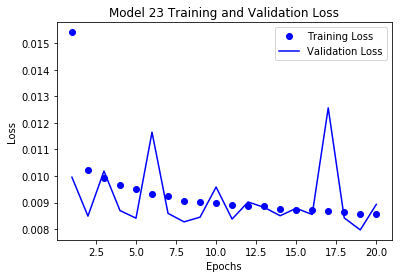

17471/17471 [==============================] - 7s 389us/step
Model 23 Kaggle Test Loss Score:  0.008929406691337901


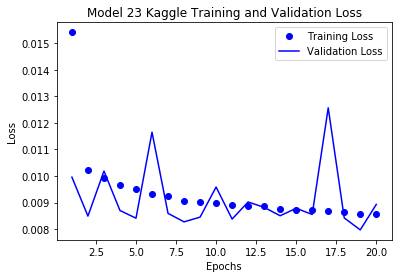

In [241]:
score23, pred_score23 = evaluate_model(model23, model23_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model23, 23)

Model 23 Test RMSE: 0.765746
Model 23 Test MAE: 0.536203




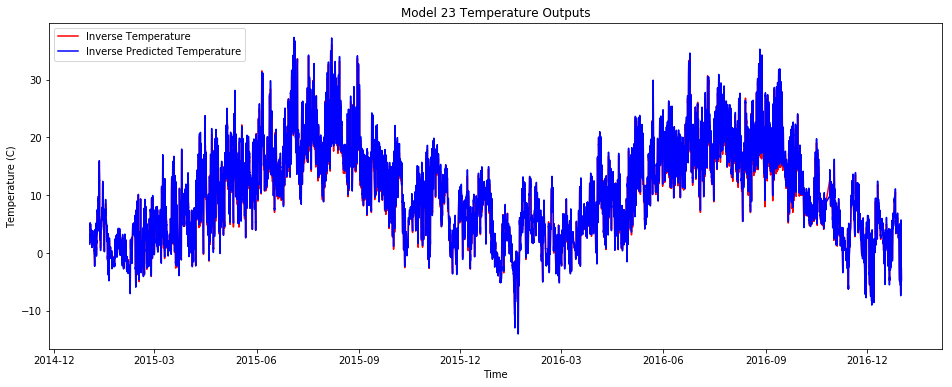

Model 23 Kaggle Prediction Test RMSE: 0.765591
Model 23 Kaggle Prediction Test MAE: 0.536122


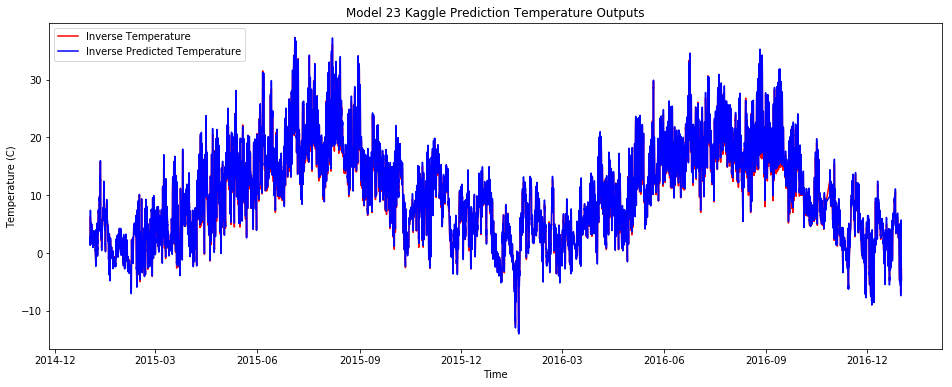

In [242]:
rmse23, mae23, pred_rmse23, pred_mae23 = create_and_save_pred_data(model23, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 23)

In [243]:
model_nums.append(23)
scores.append(score23)
pred_scores.append(pred_score23)
rmse_vals.append(rmse23)
pred_rmse_vals.append(pred_rmse23)
mae_vals.append(mae23)
pred_mae_vals.append(pred_mae23)

# Model 24 - 1 LSTM Layer With 50 Nodes, 1 Additional Dense Layer With 100 Nodes, 20 Epochs, Batch Size 10

In [244]:
model24 = Sequential()
model24.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model24.add(Dense(100))
model24.add(Dense(1))

model24.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_30 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 101       
Total params: 18,201
Trainable params: 18,201
Non-trainable params: 0
_________________________________________________________________


In [245]:
model24.compile(loss = 'mae', optimizer = 'adam')

In [246]:
batch_model24 = 10
model24_history = model24.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model24, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 80s 2ms/step - loss: 0.0139 - val_loss: 0.0102
Epoch 2/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0106 - val_loss: 0.0086
Epoch 3/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0099 - val_loss: 0.0150
Epoch 4/20
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 5/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 6/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 7/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 8/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 9/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch

In [247]:
model24.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model24.h5')

model24_hist_dict = model24_history.history
model24_hist_json = json.dumps(model24_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model24_hist.json', 'w')
f.write(model24_hist_json)
f.close()

In [248]:
#model24 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model24.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model24_hist.json', 'r')
#model24_hist_json = f.read()
#f.close()
#model24_hist_dict = json.loads(model24_hist_json)

#print(model24.summary())
#print(model24_hist_dict)

17447/17447 [==============================] - 4s 236us/step
Model 24 Test Loss Score:  0.00900838814078538


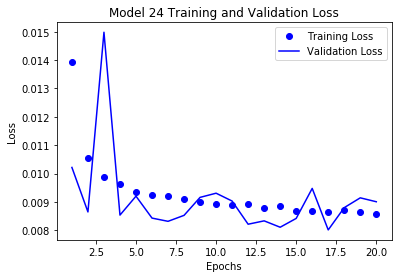

17471/17471 [==============================] - 4s 239us/step
Model 24 Kaggle Test Loss Score:  0.009006953600159833


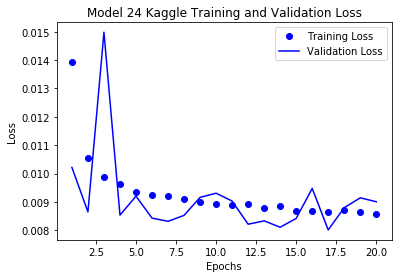

In [249]:
score24, pred_score24 = evaluate_model(model24, model24_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model24, 24)

Model 24 Test RMSE: 0.749776
Model 24 Test MAE: 0.540864




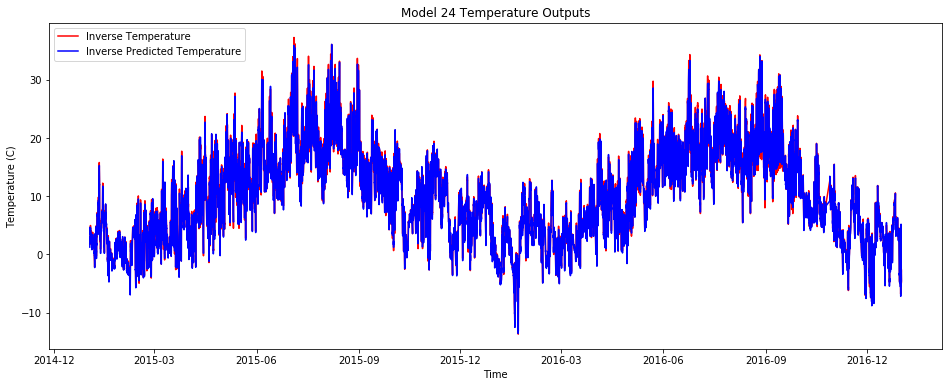

Model 24 Kaggle Prediction Test RMSE: 0.749653
Model 24 Kaggle Prediction Test MAE: 0.540777


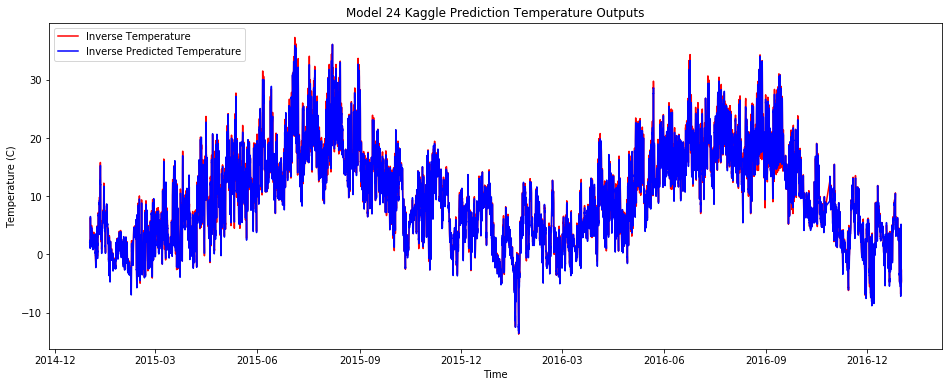

In [250]:
rmse24, mae24, pred_rmse24, pred_mae24 = create_and_save_pred_data(model24, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 24)

In [251]:
model_nums.append(24)
scores.append(score24)
pred_scores.append(pred_score24)
rmse_vals.append(rmse24)
pred_rmse_vals.append(pred_rmse24)
mae_vals.append(mae24)
pred_mae_vals.append(pred_mae24)

# Model 25 - 1 LSTM Layer With 50 Nodes, 1 Additional Dense Layer With 100 Nodes, 30% Dense Layer Dropout, 20 Epochs, Batch Size 10

In [252]:
model25 = Sequential()
model25.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model25.add(Dense(100))
model25.add(Dropout(0.3))
model25.add(Dense(1))

model25.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_32 (Dense)             (None, 100)               5100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 18,201
Trainable params: 18,201
Non-trainable params: 0
_________________________________________________________________


In [253]:
model25.compile(loss = 'mae', optimizer = 'adam')

In [254]:
batch_model25 = 10
model25_history = model25.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model25, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 79s 1ms/step - loss: 0.0276 - val_loss: 0.0105
Epoch 2/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0139 - val_loss: 0.0100
Epoch 3/20
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0129 - val_loss: 0.0097
Epoch 4/20
52542/52542 [==============================] - 78s 1ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 5/20
52542/52542 [==============================] - 82s 2ms/step - loss: 0.0125 - val_loss: 0.0090
Epoch 6/20
52542/52542 [==============================] - 79s 2ms/step - loss: 0.0123 - val_loss: 0.0126
Epoch 7/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 8/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 9/20
52542/52542 [==============================] - 78s 1ms/step - loss: 0.0121 - val_loss: 0.0102
Epoch

In [255]:
model25.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model25.h5')

model25_hist_dict = model25_history.history
model25_hist_json = json.dumps(model25_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model25_hist.json', 'w')
f.write(model25_hist_json)
f.close()

In [256]:
#model25 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model25.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model25_hist.json', 'r')
#model25_hist_json = f.read()
#f.close()
#model25_hist_dict = json.loads(model25_hist_json)

#print(model25.summary())
#print(model25_hist_dict)

17447/17447 [==============================] - 4s 239us/step
Model 25 Test Loss Score:  0.008844872902816804


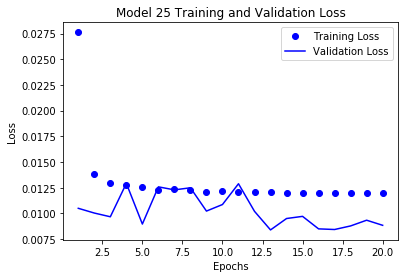

17471/17471 [==============================] - 4s 249us/step
Model 25 Kaggle Test Loss Score:  0.008842730778889162


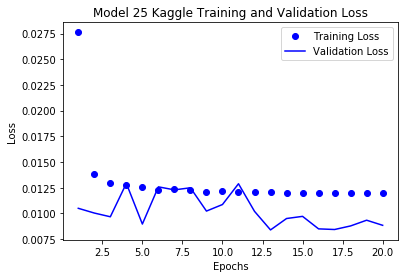

In [257]:
score25, pred_score25 = evaluate_model(model25, model25_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model25, 25)

Model 25 Test RMSE: 0.759355
Model 25 Test MAE: 0.531046




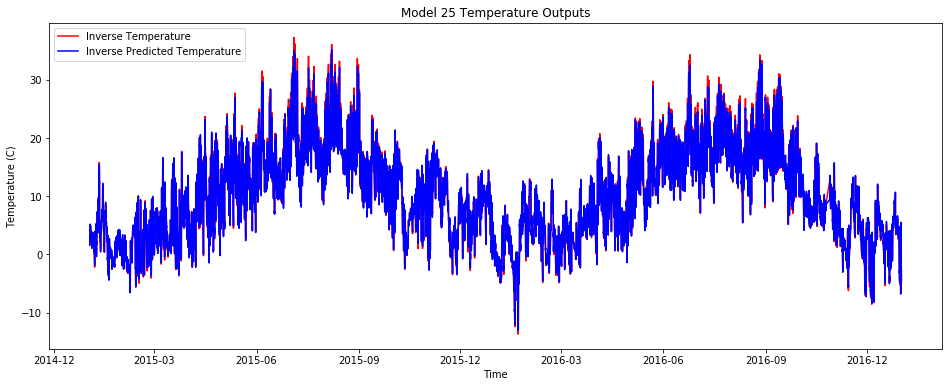

Model 25 Kaggle Prediction Test RMSE: 0.759158
Model 25 Kaggle Prediction Test MAE: 0.530918


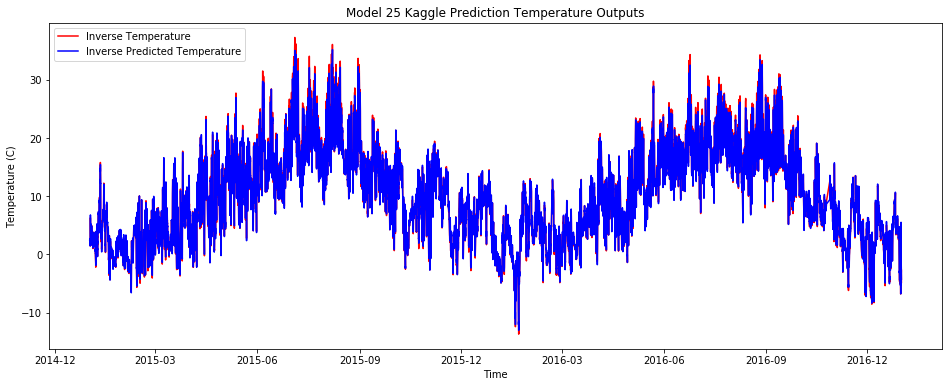

In [258]:
rmse25, mae25, pred_rmse25, pred_mae25 = create_and_save_pred_data(model25, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 25)

In [259]:
model_nums.append(25)
scores.append(score25)
pred_scores.append(pred_score25)
rmse_vals.append(rmse25)
pred_rmse_vals.append(pred_rmse25)
mae_vals.append(mae25)
pred_mae_vals.append(pred_mae25)

# Model 26 - 2 LSTM Layers With 50 and 25 Nodes, 20 Epochs, Batch Size 10

In [260]:
model26 = Sequential()
model26.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences=True))
model26.add(LSTM(25))
model26.add(Dense(1))

model26.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 24, 50)            13000     
_________________________________________________________________
lstm_33 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 26        
Total params: 20,626
Trainable params: 20,626
Non-trainable params: 0
_________________________________________________________________


In [261]:
model26.compile(loss = 'mae', optimizer = 'adam')

In [262]:
batch_model26 = 10
model26_history = model26.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model26, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 123s 2ms/step - loss: 0.0136 - val_loss: 0.0109
Epoch 2/20
52542/52542 [==============================] - 121s 2ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 3/20
52542/52542 [==============================] - 122s 2ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 4/20
52542/52542 [==============================] - 123s 2ms/step - loss: 0.0092 - val_loss: 0.0104
Epoch 5/20
52542/52542 [==============================] - 125s 2ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 6/20
52542/52542 [==============================] - 125s 2ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 7/20
52542/52542 [==============================] - 124s 2ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 8/20
52542/52542 [==============================] - 122s 2ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 9/20
52542/52542 [==============================] - 123s 2ms/step - loss: 0.0088 - val_loss: 0.0

In [263]:
model26.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model26.h5')

model26_hist_dict = model26_history.history
model26_hist_json = json.dumps(model26_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model26_hist.json', 'w')
f.write(model26_hist_json)
f.close()

In [264]:
#model26 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model26.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model26_hist.json', 'r')
#model26_hist_json = f.read()
#f.close()
#model26_hist_dict = json.loads(model26_hist_json)

#print(model26.summary())
#print(model26_hist_dict)

17447/17447 [==============================] - 7s 419us/step
Model 26 Test Loss Score:  0.008263923388728014


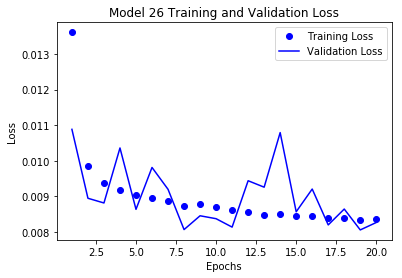

17471/17471 [==============================] - 7s 413us/step
Model 26 Kaggle Test Loss Score:  0.008263275889138938


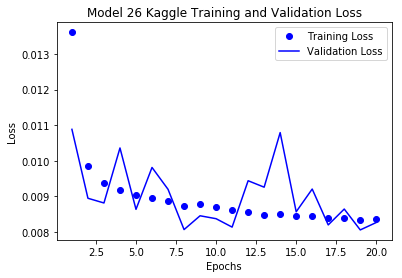

In [265]:
score26, pred_score26 = evaluate_model(model26, model26_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model26, 26)

Model 26 Test RMSE: 0.719792
Model 26 Test MAE: 0.496166




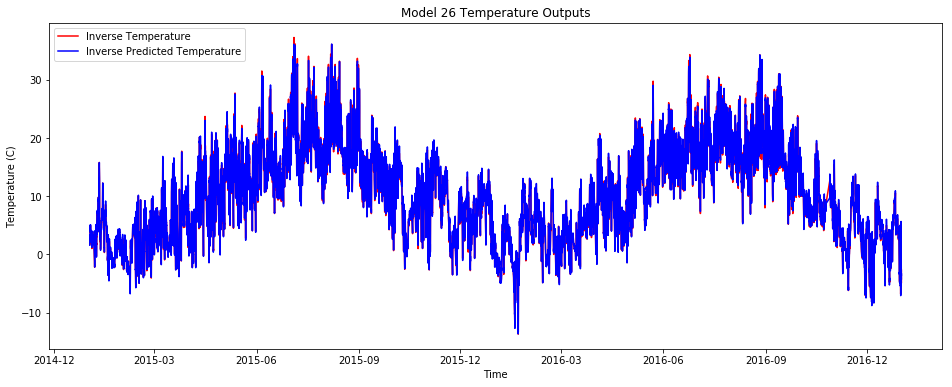

Model 26 Kaggle Prediction Test RMSE: 0.719682
Model 26 Kaggle Prediction Test MAE: 0.496127


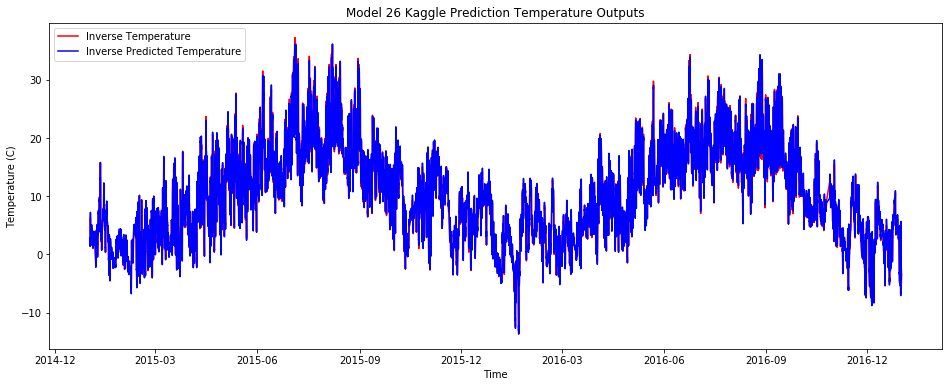

In [266]:
rmse26, mae26, pred_rmse26, pred_mae26 = create_and_save_pred_data(model26, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 26)

In [267]:
model_nums.append(26)
scores.append(score26)
pred_scores.append(pred_score26)
rmse_vals.append(rmse26)
pred_rmse_vals.append(pred_rmse26)
mae_vals.append(mae26)
pred_mae_vals.append(pred_mae26)

# Model 27 - 2 LSTM Layers With 50 and 150 Nodes, 20 Epochs, Batch Size 10

In [268]:
model27 = Sequential()
model27.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences=True))
model27.add(LSTM(150))
model27.add(Dense(1))

model27.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 24, 50)            13000     
_________________________________________________________________
lstm_35 (LSTM)               (None, 150)               120600    
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 151       
Total params: 133,751
Trainable params: 133,751
Non-trainable params: 0
_________________________________________________________________


In [269]:
model27.compile(loss = 'mae', optimizer = 'adam')

In [270]:
batch_model27 = 10
model27_history = model27.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model27, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 159s 3ms/step - loss: 0.0135 - val_loss: 0.0086
Epoch 2/20
52542/52542 [==============================] - 156s 3ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 3/20
52542/52542 [==============================] - 157s 3ms/step - loss: 0.0096 - val_loss: 0.0087
Epoch 4/20
52542/52542 [==============================] - 158s 3ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 5/20
52542/52542 [==============================] - 160s 3ms/step - loss: 0.0092 - val_loss: 0.0100
Epoch 6/20
52542/52542 [==============================] - 161s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/20
52542/52542 [==============================] - 160s 3ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 8/20
52542/52542 [==============================] - 158s 3ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 9/20
52542/52542 [==============================] - 158s 3ms/step - loss: 0.0088 - val_loss: 0.0

In [271]:
model27.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model27.h5')

model27_hist_dict = model27_history.history
model27_hist_json = json.dumps(model27_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model27_hist.json', 'w')
f.write(model27_hist_json)
f.close()

In [272]:
#model27 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model27.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model27_hist.json', 'r')
#model27_hist_json = f.read()
#f.close()
#model27_hist_dict = json.loads(model27_hist_json)

#print(model27.summary())
#print(model27_hist_dict)

17447/17447 [==============================] - 11s 621us/step
Model 27 Test Loss Score:  0.008108683438981674


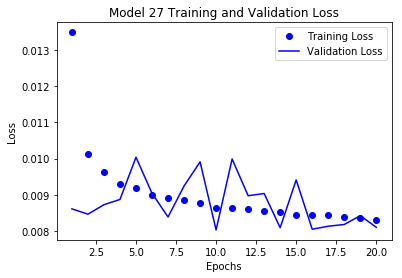

17471/17471 [==============================] - 11s 610us/step
Model 27 Kaggle Test Loss Score:  0.008107229157752997


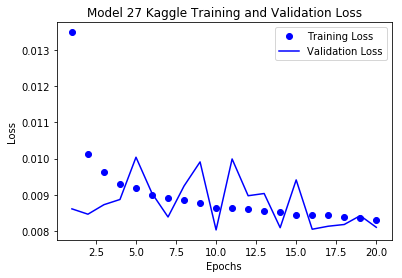

In [273]:
score27, pred_score27 = evaluate_model(model27, model27_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model27, 27)

Model 27 Test RMSE: 0.713485
Model 27 Test MAE: 0.486845




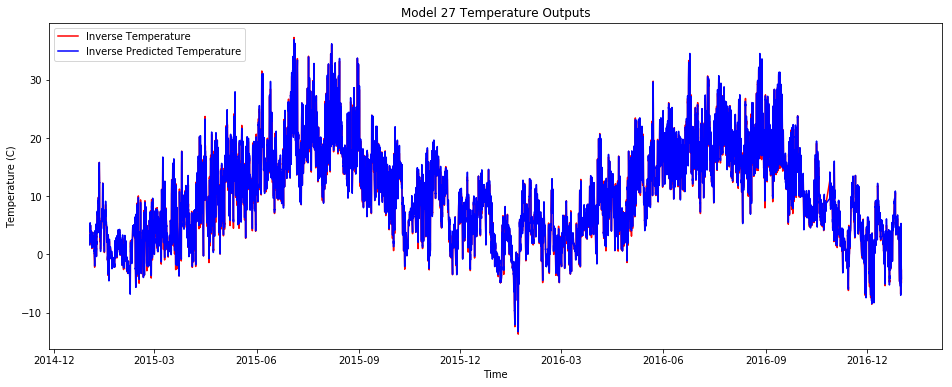

Model 27 Kaggle Prediction Test RMSE: 0.713323
Model 27 Kaggle Prediction Test MAE: 0.486758


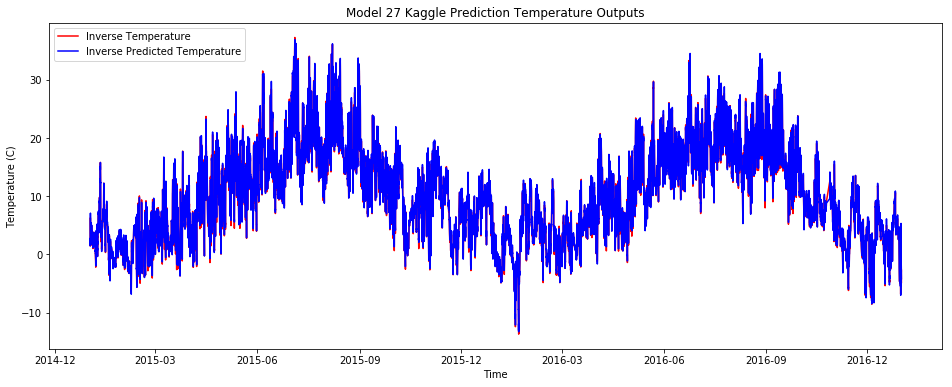

In [274]:
rmse27, mae27, pred_rmse27, pred_mae27 = create_and_save_pred_data(model27, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 27)

In [275]:
model_nums.append(27)
scores.append(score27)
pred_scores.append(pred_score27)
rmse_vals.append(rmse27)
pred_rmse_vals.append(pred_rmse27)
mae_vals.append(mae27)
pred_mae_vals.append(pred_mae27)

# Model 28 - 3 LSTM Layers With 50 Each, 20 Epochs, Batch Size 10

In [276]:
model28 = Sequential()
model28.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences=True))
model28.add(LSTM(50, return_sequences=True))
model28.add(LSTM(50))
model28.add(Dense(1))

model28.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 24, 50)            13000     
_________________________________________________________________
lstm_37 (LSTM)               (None, 24, 50)            20200     
_________________________________________________________________
lstm_38 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 51        
Total params: 53,451
Trainable params: 53,451
Non-trainable params: 0
_________________________________________________________________


In [277]:
model28.compile(loss = 'mae', optimizer = 'adam')

In [278]:
batch_model28 = 10
model28_history = model28.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model28, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 173s 3ms/step - loss: 0.0158 - val_loss: 0.0172
Epoch 2/20
52542/52542 [==============================] - 170s 3ms/step - loss: 0.0102 - val_loss: 0.0140
Epoch 3/20
52542/52542 [==============================] - 169s 3ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 4/20
52542/52542 [==============================] - 170s 3ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 5/20
52542/52542 [==============================] - 170s 3ms/step - loss: 0.0092 - val_loss: 0.0082
Epoch 6/20
52542/52542 [==============================] - 175s 3ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 7/20
52542/52542 [==============================] - 173s 3ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 8/20
52542/52542 [==============================] - 170s 3ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 9/20
52542/52542 [==============================] - 171s 3ms/step - loss: 0.0088 - val_loss: 0.0

In [279]:
model28.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model28.h5')

model28_hist_dict = model28_history.history
model28_hist_json = json.dumps(model28_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model28_hist.json', 'w')
f.write(model28_hist_json)
f.close()

In [280]:
#model28 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model28.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model28_hist.json', 'r')
#model28_hist_json = f.read()
#f.close()
#model28_hist_dict = json.loads(model28_hist_json)

#print(model28.summary())
#print(model28_hist_dict)

17447/17447 [==============================] - 11s 613us/step
Model 28 Test Loss Score:  0.007925127821567913


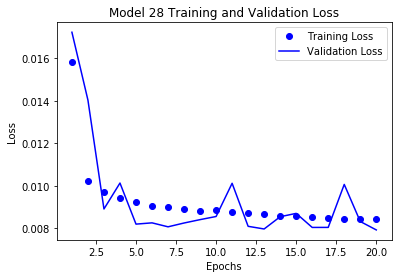

17471/17471 [==============================] - 11s 617us/step
Model 28 Kaggle Test Loss Score:  0.007923995449659925


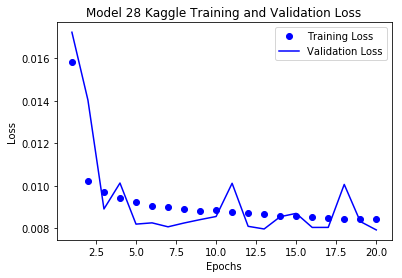

In [281]:
score28, pred_score28 = evaluate_model(model28, model28_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model28, 28)

Model 28 Test RMSE: 0.700962
Model 28 Test MAE: 0.475825




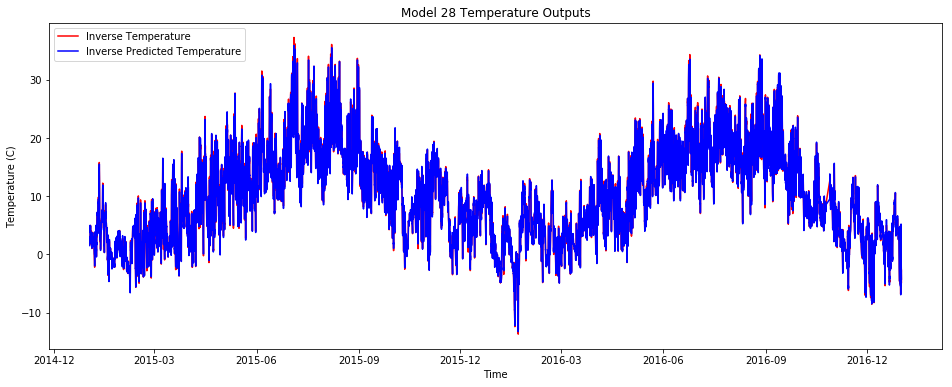

Model 28 Kaggle Prediction Test RMSE: 0.700791
Model 28 Kaggle Prediction Test MAE: 0.475757


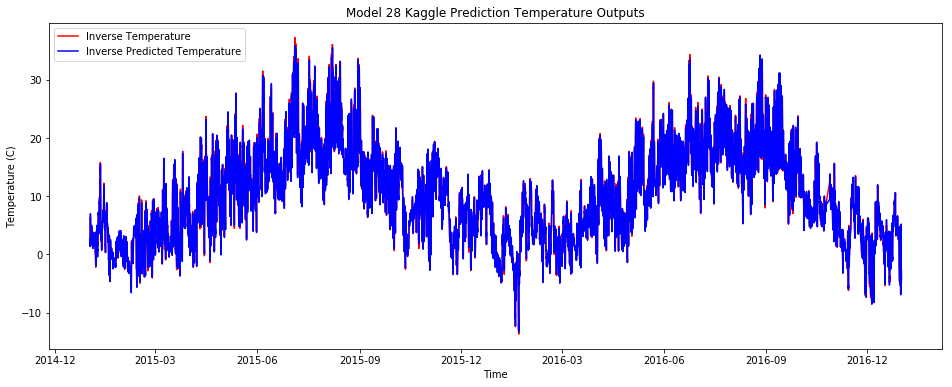

In [282]:
rmse28, mae28, pred_rmse28, pred_mae28 = create_and_save_pred_data(model28, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 28)

In [283]:
model_nums.append(28)
scores.append(score28)
pred_scores.append(pred_score28)
rmse_vals.append(rmse28)
pred_rmse_vals.append(pred_rmse28)
mae_vals.append(mae28)
pred_mae_vals.append(pred_mae28)

# Model 29 - 1 LSTM Layer With 50 Nodes, SGD Optimizer, 20 Epochs, Batch Size 10

In [284]:
model29 = Sequential()
model29.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model29.add(Dense(1))

model29.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [285]:
model29.compile(loss = 'mae', optimizer = 'sgd')

In [286]:
batch_model29 = 10
model29_history = model29.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model29, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 80s 2ms/step - loss: 0.0297 - val_loss: 0.0239
Epoch 2/20
52542/52542 [==============================] - 78s 1ms/step - loss: 0.0188 - val_loss: 0.0208
Epoch 3/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0158 - val_loss: 0.0286
Epoch 4/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0142 - val_loss: 0.0253
Epoch 5/20
52542/52542 [==============================] - 79s 2ms/step - loss: 0.0134 - val_loss: 0.0237
Epoch 6/20
52542/52542 [==============================] - 78s 1ms/step - loss: 0.0128 - val_loss: 0.0104
Epoch 7/20
52542/52542 [==============================] - 79s 1ms/step - loss: 0.0124 - val_loss: 0.0155
Epoch 8/20
52542/52542 [==============================] - 78s 1ms/step - loss: 0.0120 - val_loss: 0.0195
Epoch 9/20
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0117 - val_loss: 0.0122
Epoch

In [287]:
model29.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model29.h5')

model29_hist_dict = model29_history.history
model29_hist_json = json.dumps(model29_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model29_hist.json', 'w')
f.write(model29_hist_json)
f.close()

In [288]:
#model29 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model29.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model29_hist.json', 'r')
#model29_hist_json = f.read()
#f.close()
#model29_hist_dict = json.loads(model29_hist_json)

#print(model29.summary())
#print(model29_hist_dict)

17447/17447 [==============================] - 4s 248us/step
Model 29 Test Loss Score:  0.016790456789788435


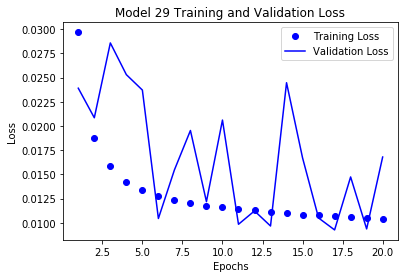

17471/17471 [==============================] - 4s 243us/step
Model 29 Kaggle Test Loss Score:  0.016790549434993546


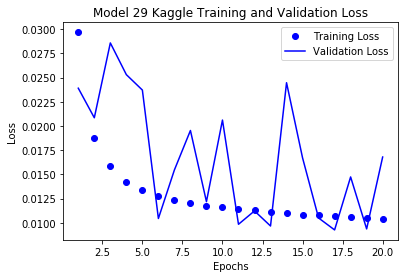

In [289]:
score29, pred_score29 = evaluate_model(model29, model29_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model29, 29)

Model 29 Test RMSE: 1.191018
Model 29 Test MAE: 1.008099




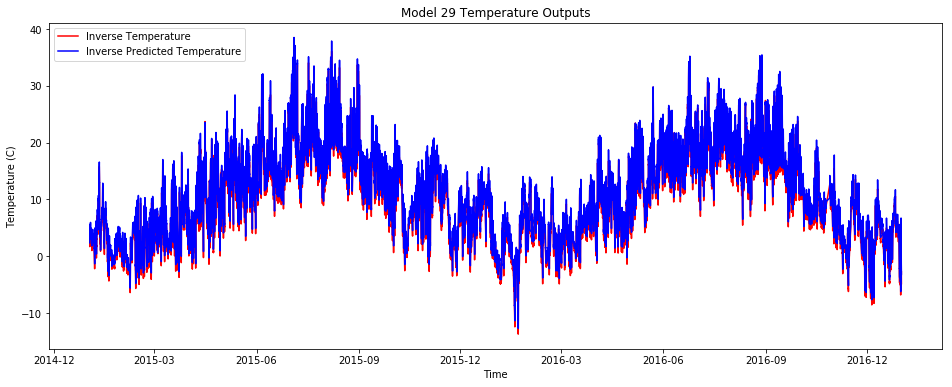

Model 29 Kaggle Prediction Test RMSE: 1.191009
Model 29 Kaggle Prediction Test MAE: 1.008105


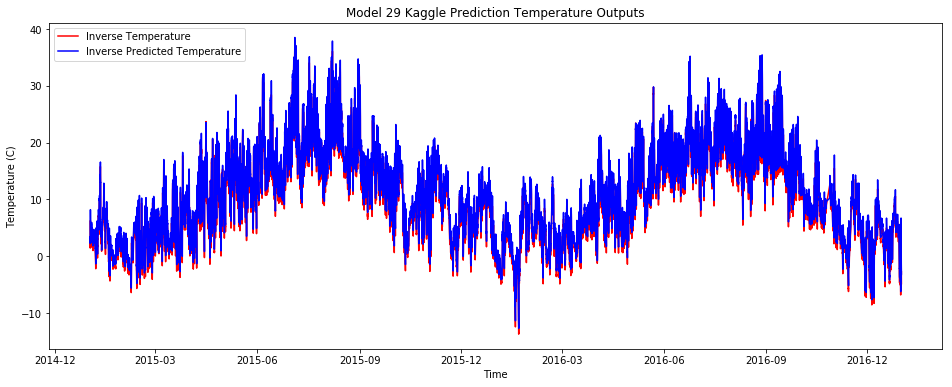

In [290]:
rmse29, mae29, pred_rmse29, pred_mae29 = create_and_save_pred_data(model29, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 29)

In [291]:
model_nums.append(29)
scores.append(score29)
pred_scores.append(pred_score29)
rmse_vals.append(rmse29)
pred_rmse_vals.append(pred_rmse29)
mae_vals.append(mae29)
pred_mae_vals.append(pred_mae29)

# Model 30 - 1 LSTM Layer With 50 Nodes, 100 Epochs, Batch Size 10

In [292]:
model30 = Sequential()
model30.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2])))
model30.add(Dense(1))

model30.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [293]:
model30.compile(loss = 'mae', optimizer = 'adam')

In [294]:
batch_model30 = 10
model30_history = model30.fit(train_x_np, train_y_np, epochs = 100, batch_size = batch_model30, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/100
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0135 - val_loss: 0.0102
Epoch 2/100
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0097 - val_loss: 0.0104
Epoch 3/100
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 4/100
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 5/100
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 6/100
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 7/100
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0087 - val_loss: 0.0104
Epoch 8/100
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 9/100
52542/52542 [==============================] - 77s 1ms/step - loss: 0.0086 - val_loss: 0.0

52542/52542 [==============================] - 75s 1ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 78/100
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 79/100
52542/52542 [==============================] - 76s 1ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 80/100
52542/52542 [==============================] - 75s 1ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 81/100
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 82/100
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 83/100
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 84/100
52542/52542 [==============================] - 74s 1ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 85/100
52542/52542 [==============================] - 73s 1ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 86/100
52542/52542 [========================

In [295]:
model30.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model30.h5')

model30_hist_dict = model30_history.history
model30_hist_json = json.dumps(model30_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model30_hist.json', 'w')
f.write(model30_hist_json)
f.close()

In [296]:
#model30 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model30.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model30_hist.json', 'r')
#model30_hist_json = f.read()
#f.close()
#model30_hist_dict = json.loads(model30_hist_json)

#print(model30.summary())
#print(model30_hist_dict)

17447/17447 [==============================] - 4s 243us/step
Model 30 Test Loss Score:  0.009269349509556555


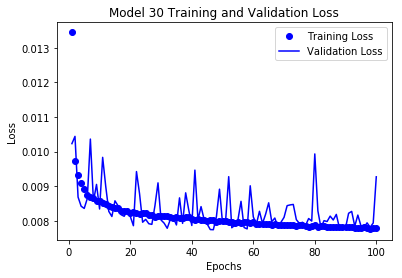

17471/17471 [==============================] - 4s 250us/step
Model 30 Kaggle Test Loss Score:  0.009267967748389337


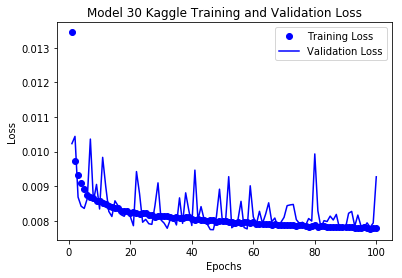

In [297]:
score30, pred_score30 = evaluate_model(model30, model30_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model30, 30)

Model 30 Test RMSE: 0.769873
Model 30 Test MAE: 0.556532




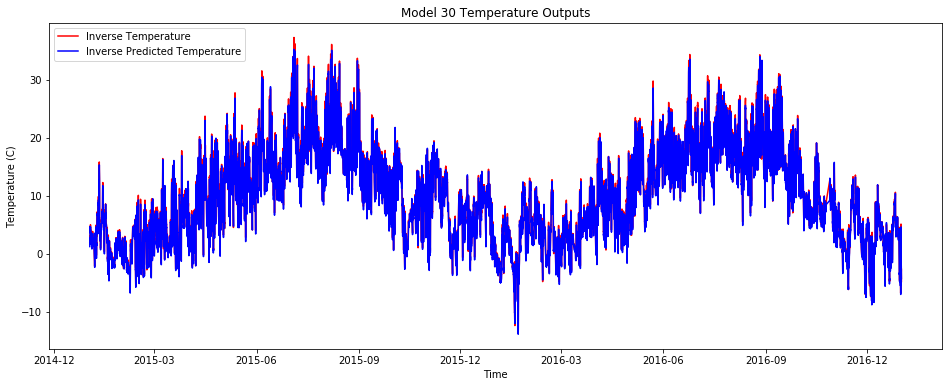

Model 30 Kaggle Prediction Test RMSE: 0.769723
Model 30 Kaggle Prediction Test MAE: 0.556449


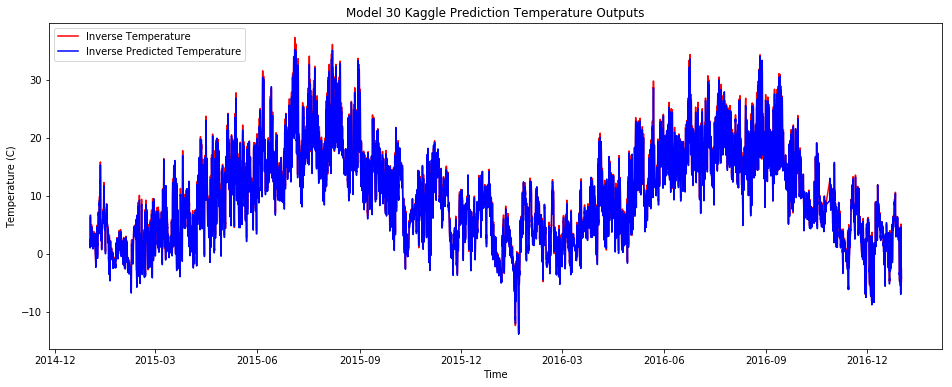

In [298]:
rmse30, mae30, pred_rmse30, pred_mae30 = create_and_save_pred_data(model30, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 30)

In [299]:
model_nums.append(30)
scores.append(score30)
pred_scores.append(pred_score30)
rmse_vals.append(rmse30)
pred_rmse_vals.append(pred_rmse30)
mae_vals.append(mae30)
pred_mae_vals.append(pred_mae30)

# Model 31 - 3 LSTM Layer With 50 Nodes, 1 Additional Dense Layer With 50 Nodes, 20 Epochs, Batch Size 10

In [300]:
model31 = Sequential()
model31.add(LSTM(50, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences=True))
model31.add(LSTM(50, return_sequences=True))
model31.add(LSTM(50, return_sequences=False))
model31.add(Dense(50))
model31.add(Dense(1))

model31.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 24, 50)            13000     
_________________________________________________________________
lstm_42 (LSTM)               (None, 24, 50)            20200     
_________________________________________________________________
lstm_43 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_39 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 51        
Total params: 56,001
Trainable params: 56,001
Non-trainable params: 0
_________________________________________________________________


In [301]:
model31.compile(loss = 'mae', optimizer = 'adam')

In [302]:
batch_model31 = 10
model31_history = model31.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model31, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 180s 3ms/step - loss: 0.0158 - val_loss: 0.0108
Epoch 2/20
52542/52542 [==============================] - 178s 3ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 3/20
52542/52542 [==============================] - 177s 3ms/step - loss: 0.0101 - val_loss: 0.0126
Epoch 4/20
52542/52542 [==============================] - 176s 3ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 5/20
52542/52542 [==============================] - 177s 3ms/step - loss: 0.0095 - val_loss: 0.0085
Epoch 6/20
52542/52542 [==============================] - 177s 3ms/step - loss: 0.0095 - val_loss: 0.0084
Epoch 7/20
52542/52542 [==============================] - 178s 3ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 8/20
52542/52542 [==============================] - 176s 3ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 9/20
52542/52542 [==============================] - 176s 3ms/step - loss: 0.0091 - val_loss: 0.0

In [303]:
model31.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model31.h5')

model31_hist_dict = model31_history.history
model31_hist_json = json.dumps(model31_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model31_hist.json', 'w')
f.write(model31_hist_json)
f.close()

In [304]:
#model31 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model31.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model31_hist.json', 'r')
#model31_hist_json = f.read()
#f.close()
#model31_hist_dict = json.loads(model31_hist_json)

#print(model31.summary())
#print(model31_hist_dict)

17447/17447 [==============================] - 11s 634us/step
Model 31 Test Loss Score:  0.008853643805834518


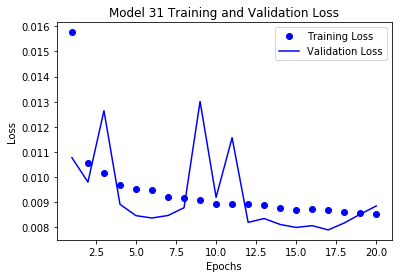

17471/17471 [==============================] - 11s 630us/step
Model 31 Kaggle Test Loss Score:  0.008851709616199438


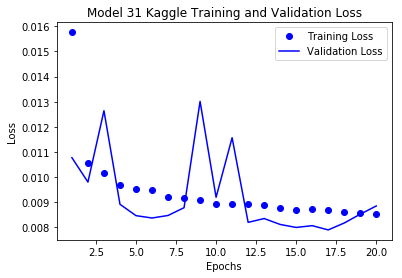

In [305]:
score31, pred_score31 = evaluate_model(model31, model31_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model31, 31)

Model 31 Test RMSE: 0.743692
Model 31 Test MAE: 0.531573




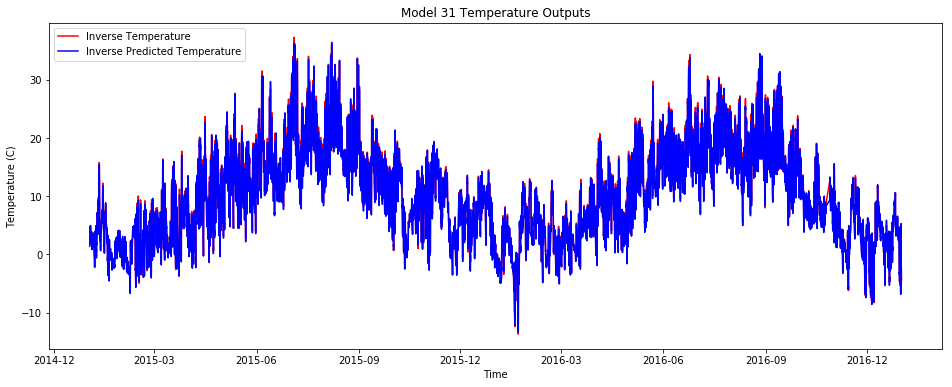

Model 31 Kaggle Prediction Test RMSE: 0.743502
Model 31 Kaggle Prediction Test MAE: 0.531457


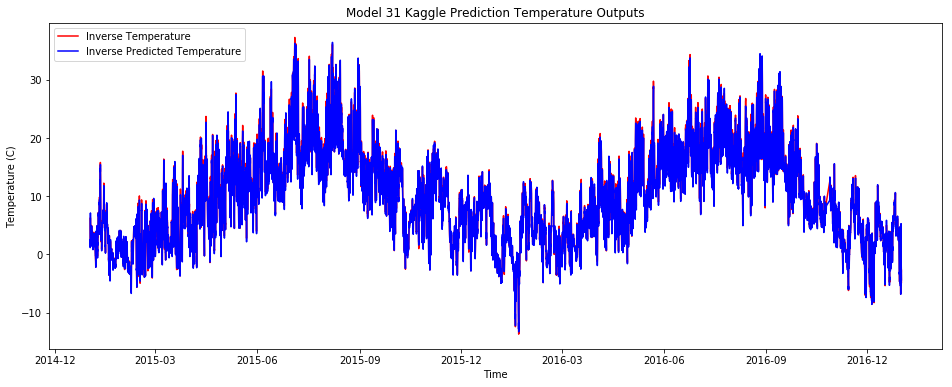

In [308]:
rmse31, mae31, pred_rmse31, pred_mae31 = create_and_save_pred_data(model31, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 31)

In [309]:
model_nums.append(31)
scores.append(score31)
pred_scores.append(pred_score31)
rmse_vals.append(rmse31)
pred_rmse_vals.append(pred_rmse31)
mae_vals.append(mae31)
pred_mae_vals.append(pred_mae31)

# Model 32 - 3 LSTM Layer With 20 Nodes, 20 Epochs, Batch Size 10

In [310]:
model32 = Sequential()
model32.add(LSTM(20, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences=True))
model32.add(LSTM(20, return_sequences=True))
model32.add(LSTM(20))
model32.add(Dense(1))

model32.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 24, 20)            2800      
_________________________________________________________________
lstm_45 (LSTM)               (None, 24, 20)            3280      
_________________________________________________________________
lstm_46 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 21        
Total params: 9,381
Trainable params: 9,381
Non-trainable params: 0
_________________________________________________________________


In [311]:
model32.compile(loss = 'mae', optimizer = 'adam')

In [312]:
batch_model32 = 10
model32_history = model32.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model32, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 221s 4ms/step - loss: 0.0162 - val_loss: 0.0106
Epoch 2/20
52542/52542 [==============================] - 160s 3ms/step - loss: 0.0101 - val_loss: 0.0117
Epoch 3/20
52542/52542 [==============================] - 163s 3ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 4/20
52542/52542 [==============================] - 161s 3ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 5/20
52542/52542 [==============================] - 163s 3ms/step - loss: 0.0093 - val_loss: 0.0104
Epoch 6/20
52542/52542 [==============================] - 164s 3ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 7/20
52542/52542 [==============================] - 162s 3ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 8/20
52542/52542 [==============================] - 161s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 9/20
52542/52542 [==============================] - 161s 3ms/step - loss: 0.0089 - val_loss: 0.0

In [313]:
model32.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model32.h5')

model32_hist_dict = model32_history.history
model32_hist_json = json.dumps(model32_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model32_hist.json', 'w')
f.write(model32_hist_json)
f.close()

In [314]:
#model32 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model32.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model32_hist.json', 'r')
#model32_hist_json = f.read()
#f.close()
#model32_hist_dict = json.loads(model32_hist_json)

#print(model32.summary())
#print(model32_hist_dict)

17447/17447 [==============================] - 10s 576us/step
Model 32 Test Loss Score:  0.008759738672035729


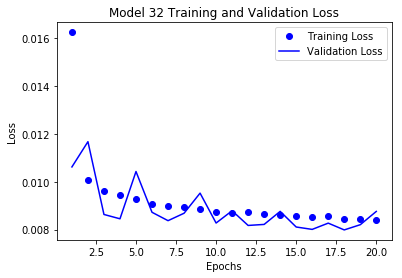

17471/17471 [==============================] - 10s 594us/step
Model 32 Kaggle Test Loss Score:  0.008758143466752794


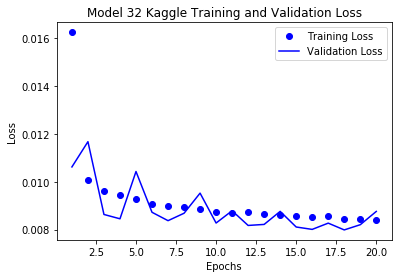

In [315]:
score32, pred_score32 = evaluate_model(model32, model32_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model32, 32)

Model 32 Test RMSE: 0.741844
Model 32 Test MAE: 0.525935




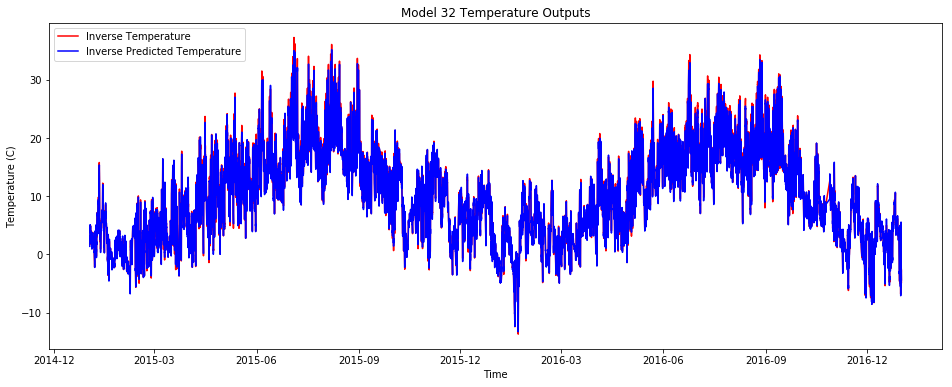

Model 32 Kaggle Prediction Test RMSE: 0.741678
Model 32 Kaggle Prediction Test MAE: 0.525839


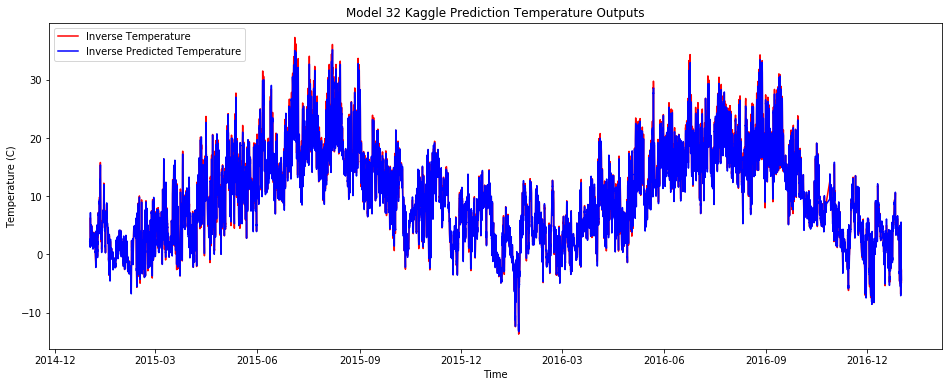

In [316]:
rmse32, mae32, pred_rmse32, pred_mae32 = create_and_save_pred_data(model32, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 32)

In [317]:
model_nums.append(32)
scores.append(score32)
pred_scores.append(pred_score32)
rmse_vals.append(rmse32)
pred_rmse_vals.append(pred_rmse32)
mae_vals.append(mae32)
pred_mae_vals.append(pred_mae32)

# Model 33 - 3 LSTM Layer With 20 Nodes, 1 Additional Dense Layer With 50 Nodes, 20 Epochs, Batch Size 10

In [318]:
model33 = Sequential()
model33.add(LSTM(20, input_shape=(train_x_np.shape[1], train_x_np.shape[2]), return_sequences=True))
model33.add(LSTM(20, return_sequences=True))
model33.add(LSTM(20, return_sequences=False))
model33.add(Dense(50))
model33.add(Dense(1))

model33.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 24, 20)            2800      
_________________________________________________________________
lstm_48 (LSTM)               (None, 24, 20)            3280      
_________________________________________________________________
lstm_49 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_42 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 51        
Total params: 10,461
Trainable params: 10,461
Non-trainable params: 0
_________________________________________________________________


In [319]:
model33.compile(loss = 'mae', optimizer = 'adam')

In [320]:
batch_model33 = 10
model33_history = model33.fit(train_x_np, train_y_np, epochs = 20, batch_size = batch_model33, 
                          validation_data = (test_x_np, test_y_np))

Train on 52542 samples, validate on 17447 samples
Epoch 1/20
52542/52542 [==============================] - 170s 3ms/step - loss: 0.0188 - val_loss: 0.0133
Epoch 2/20
52542/52542 [==============================] - 167s 3ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 3/20
52542/52542 [==============================] - 166s 3ms/step - loss: 0.0100 - val_loss: 0.0114
Epoch 4/20
52542/52542 [==============================] - 165s 3ms/step - loss: 0.0098 - val_loss: 0.0087
Epoch 5/20
52542/52542 [==============================] - 166s 3ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 6/20
52542/52542 [==============================] - 167s 3ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 7/20
52542/52542 [==============================] - 167s 3ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 8/20
52542/52542 [==============================] - 166s 3ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 9/20
52542/52542 [==============================] - 168s 3ms/step - loss: 0.0091 - val_loss: 0.0

In [321]:
model33.save('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model33.h5')

model33_hist_dict = model33_history.history
model33_hist_json = json.dumps(model33_hist_dict)
f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model33_hist.json', 'w')
f.write(model33_hist_json)
f.close()

In [322]:
#model33 = keras.models.load_model('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model33.h5')

#f = open('C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\model33_hist.json', 'r')
#model33_hist_json = f.read()
#f.close()
#model33_hist_dict = json.loads(model33_hist_json)

#print(model33.summary())
#print(model33_hist_dict)

17447/17447 [==============================] - 10s 576us/step
Model 33 Test Loss Score:  0.008125799641409973


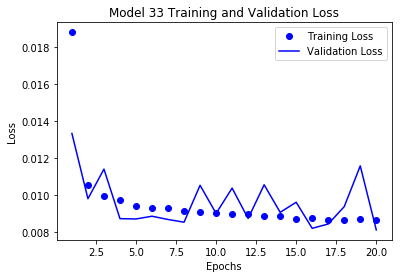

17471/17471 [==============================] - 10s 587us/step
Model 33 Kaggle Test Loss Score:  0.008124943675935395


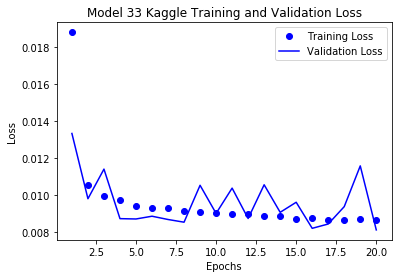

In [323]:
score33, pred_score33 = evaluate_model(model33, model33_hist_dict, test_x_np, test_y_np, pred_test_x_np, pred_test_y_np, 
                                     batch_model33, 33)

Model 33 Test RMSE: 0.713595
Model 33 Test MAE: 0.487873




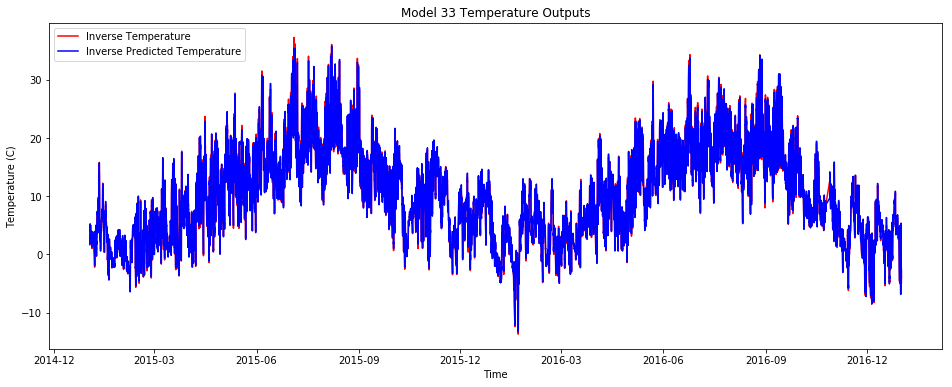

Model 33 Kaggle Prediction Test RMSE: 0.713447
Model 33 Kaggle Prediction Test MAE: 0.487822


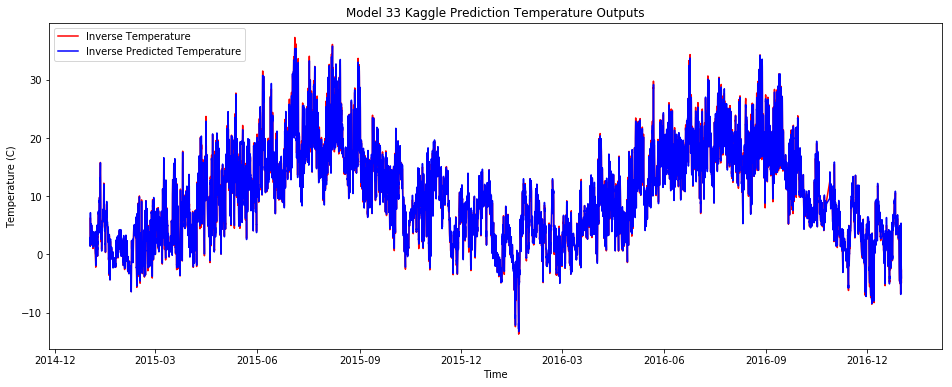

In [324]:
rmse33, mae33, pred_rmse33, pred_mae33 = create_and_save_pred_data(model33, test_x_np, test_norm_df, test_y_np, 
                                    pred_test_x_np, pred_test_norm_df, pred_test_y_np, 33)

In [325]:
model_nums.append(33)
scores.append(score33)
pred_scores.append(pred_score33)
rmse_vals.append(rmse33)
pred_rmse_vals.append(pred_rmse33)
mae_vals.append(mae33)
pred_mae_vals.append(pred_mae33)

# Compile, Plot, and Save Results

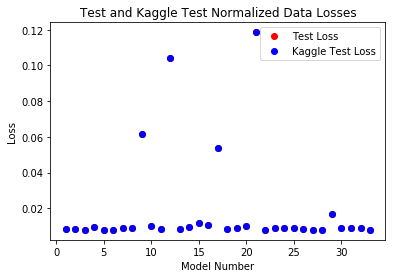

In [326]:
# "bo" is for "blue dot"
plt.plot(model_nums, scores, 'ro', label = 'Test Loss')

# b is for "solid blue line"
plot_title = 'Test and Kaggle Test Normalized Data Losses'
plt.plot(model_nums, pred_scores, 'bo', label = 'Kaggle Test Loss')
plt.title(plot_title)
plt.xlabel('Model Number')
plt.ylabel('Loss')
plt.legend()

plt.show()   


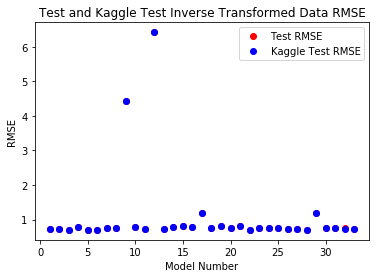

In [327]:
# "bo" is for "blue dot"
plt.plot(model_nums, rmse_vals, 'ro', label = 'Test RMSE')

# b is for "solid blue line"
plot_title = 'Test and Kaggle Test Inverse Transformed Data RMSE'
plt.plot(model_nums, pred_rmse_vals, 'bo', label = 'Kaggle Test RMSE')
plt.title(plot_title)
plt.xlabel('Model Number')
plt.ylabel('RMSE')
plt.legend()

plt.show()   

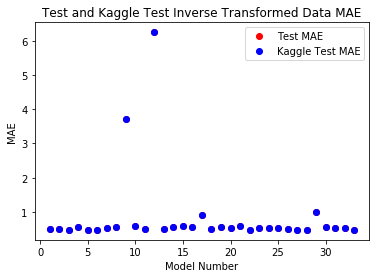

In [328]:
# "bo" is for "blue dot"
plt.plot(model_nums, mae_vals, 'ro', label = 'Test MAE')

# b is for "solid blue line"
plot_title = 'Test and Kaggle Test Inverse Transformed Data MAE'
plt.plot(model_nums, pred_mae_vals, 'bo', label = 'Kaggle Test MAE')
plt.title(plot_title)
plt.xlabel('Model Number')
plt.ylabel('MAE')
plt.legend()

plt.show()   

In [329]:
results_df = pd.DataFrame(model_nums, columns = ['model_nums'])
results_df['scores'] = scores
results_df['pred_scores'] = pred_scores
results_df['rmse_vals'] = rmse_vals
results_df['pred_rmse_vals'] = pred_rmse_vals
results_df['mae_vals'] = mae_vals
results_df['pred_mae_vals'] = pred_mae_vals


In [346]:
min_vals = results_df.min()
pred_mae_min = min_vals[6]
min_ndxs = results_df.idxmin()
model_min = min_ndxs[6]

print('Minimum MAE: %.6f' % pred_mae_min)
print('Model with Minimum MAE: %d' % model_min)


Minimum MAE: 0.475757
Model with Minimum MAE: 27


In [349]:
results_df

model_nums    scores  pred_scores  rmse_vals  pred_rmse_vals  mae_vals  \
0            1  0.008439     0.008438   0.727960        0.727830  0.506676   
1            2  0.008203     0.008202   0.716376        0.716250  0.492503   
2            3  0.007940     0.007939   0.702191        0.702099  0.476696   
3            4  0.009311     0.009309   0.776805        0.776631  0.559010   
4            5  0.008093     0.008093   0.708208        0.708068  0.485932   
5            6  0.008090     0.008090   0.706730        0.706594  0.485741   
6            7  0.008968     0.008967   0.751973        0.751858  0.538415   
7            8  0.009113     0.009114   0.764299        0.764225  0.547168   
8            9  0.061765     0.061806   4.436731        4.438673  3.708357   
9           10  0.010022     0.010021   0.798108        0.797996  0.601743   
10          11  0.008159     0.008158   0.733627        0.733457  0.489865   
11          12  0.104051     0.104020   6.422033        6.420228  6.247228   
12          13  0.008271     0.008270   0.732423        0.732261  0.496621   
13          14  0.009643     0.009641   0.781005        0.780789  0.551275   
14          15  0.011824     0.011823   0.810058        0.810015  0.588220   
15          16  0.010912     0.010911   0.787244        0.787142  0.554076   
16          17  0.054046     0.054041   1.183093        1.182887  0.906647   
17          18  0.008659     0.008659   0.749671        0.749529  0.507362   
18          19  0.009233     0.009233   0.809772        0.809732  0.553451   
19          20  0.009859     0.009859   0.770337        0.770277  0.525869   
20          21  0.118586     0.118587   0.804205        0.804209  0.577961   
21          22  0.007943     0.007942   0.710774        0.710663  0.476881   
22          23  0.008931     0.008929   0.765746        0.765591  0.536203   
23          24  0.009008     0.009007   0.749776        0.749653  0.540864   
24          25  0.008845     0.008843   0.759355        0.759158  0.531046   
25          26  0.008264     0.008263   0.719792        0.719682  0.496166   
26          27  0.008109     0.008107   0.713485        0.713323  0.486845   
27          28  0.007925     0.007924   0.700962        0.700791  0.475825   
28          29  0.016790     0.016791   1.191018        1.191009  1.008099   
29          30  0.009269     0.009268   0.769873        0.769723  0.556532   
30          31  0.008854     0.008852   0.743692        0.743502  0.531573   
31          32  0.008760     0.008758   0.741844        0.741678  0.525935   
32          33  0.008126     0.008125   0.713595        0.713447  0.487873   

    pred_mae_vals  
0        0.506628  
1        0.492466  
2        0.476677  
3        0.558907  
4        0.485892  
5        0.485695  
6        0.538367  
7        0.547219  
8        3.710858  
9        0.601679  
10       0.489816  
11       6.245388  
12       0.496548  
13       0.551158  
14       0.588183  
15       0.554052  
16       0.906312  
17       0.507307  
18       0.553467  
19       0.525870  
20       0.578016  
21       0.476868  
22       0.536122  
23       0.540777  
24       0.530918  
25       0.496127  
26       0.486758  
27       0.475757  
28       1.008105  
29       0.556449  
30       0.531457  
31       0.525839  
32       0.487822

In [350]:
res_out_file = 'C:\\DePaulCoursework\\Fall 2018 CSC 578\\Assignments\\Final Project\\Outputs\\All_Model_Results.csv'
results_df.to_csv(res_out_file, header  = True, index  = False)
